In [77]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.solvers.mosek import MosekSolver


p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [78]:
E

array([[1.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 4.663, 2.33 ],
       [0.   , 0.   , 2.33 , 1.33 ]])

In [79]:
A

array([[-0.   , -0.   ,  1.   , -0.   ],
       [-0.   , -0.   , -0.   ,  1.   ],
       [24.525,  9.81 , -0.1  , -0.   ],
       [ 9.81 ,  9.81 , -0.   , -0.1  ]])

In [80]:
K

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [3]:
K_casted = np.insert(K, 1, 0)
K_casted = np.insert(K_casted, 3, 0)
K_casted

array([-278.44223126,    0.        , -112.29125985,    0.        ,
       -119.72457377,  -56.82824017])

In [4]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [5]:
t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")

x = np.hstack([t1, t2, td1, td2])
V_candidate = x.T@E.T@P@E@x
Polynomial(V_candidate)

<Polynomial "80.91247036766552*td2^2 + 325.76452518070187*td1 * td2 + 328.06019370446921*td1^2 + 325.00590715317509*t2 * td2 + 654.32926244338728*t2 * td1 + 327.48490678102974*t2^2 + 754.43992843215551*t1 * td2 + 1519.4572447750918*t1 * td1 + 1515.5320202469929*t1 * t2 + 1760.7194856732497*t1^2">

In [6]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)

    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - rho) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
#     prog.AddSosConstraint(Vdot + Polynomial((x-x_0).dot(x-x_0)) + lambda_*(V + 362) + \
#                           lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
    prog.AddLinearCost(-rho)
    #prog.AddLinearConstraint(rho, 0, positive_infinity)
    
    
        
    solver = MosekSolver()
    result = solver.Solve(prog)

    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def verify_V_positive_definite(x, V): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    s_deg = max(V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(x), s_deg)
    
    prog.AddSosConstraint(V + lambda_s*trig + lambda_s2*trig2)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
    print("V assertion solution status: " + str(k))
    
    assert result.is_success()
    
    print('Reached here means result is success')

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 1
V assertion solution status: 1
Reached here means result is success
0.0017623894685293298


$ V(x)=(4176.408784909 - 3521.438971346c1_{0} - 654.969813562c2_{0} + 1515.532020247s1_{0} s2_{0} + 1519.457244775s1_{0} \dot{t1}_{0} + 754.439928432s1_{0} \dot{t2}_{0} + 654.329262443s2_{0} \dot{t1}_{0} + 325.005907153s2_{0} \dot{t2}_{0} + 325.764525181\dot{t1}_{0} \dot{t2}_{0} + 328.060193704\dot{t1}_{0}^{2} + 80.912470368\dot{t2}_{0}^{2})$

In [29]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    #rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    rho = 1e-6
    prog.AddSosConstraint(-Vdot + lambda_*(V - rho) \
                         + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        #verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 5


AssertionError: 

In [12]:
list(V.indeterminates())

[Variable('s1(0)', Continuous),
 Variable('c1(0)', Continuous),
 Variable('s2(0)', Continuous),
 Variable('c2(0)', Continuous),
 Variable('\dot{t1}(0)', Continuous),
 Variable('\dot{t2}(0)', Continuous)]

In [13]:
var_list = list(V.indeterminates())
s1 = var_list[0]
c1 = var_list[1]
s2 = var_list[2]
c2 = var_list[3]
td1 = var_list[4]
td2 = var_list[5]

env = {s1:0, c1:1, s2:0, c2:1, td1:0, td2:0}


V.Evaluate(env)


4.547473508864641e-13

In [14]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
    
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    
    failed_V = []
    success_V = []
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        #print(np.random.randn(2))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.append(np.random.randn(2,), np.zeros(3))
        
        env[s1] = np.sin(trial[0] - np.pi)
        env[c1] = np.cos(trial[0] - np.pi)
        env[s2] = np.sin(trial[1])
        env[c2] = np.cos(trial[1])
        env[td1] = trial[2]
        env[td2] = trial[3]
        
        V_evaluated = V.Evaluate(env)
        
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        # teta = log.data()[0]
        t1_end = log.data()[0][-1]
        t2_end = log.data()[1][-1]
        t1d_end = log.data()[2][-1]
        t2d_end = log.data()[3][-1]
        
        if  t1_end - np.pi < 5*1e-2 and t2_end - 0 < 5e-2 and t1d_end - 0 < 5e-2 and t2d_end - 0 < 5e-2:
            points.append(trial[:-1])
            success_V.append(V_evaluated)
        else: 
            points_failed.append(trial[:-1])
            failed_V.append(V_evaluated)
        
#         avg_angle = np.average(teta[2*int(len(teta)/3):])
# #         print(avg_angle)
#         if  avg_angle - np.pi < 2*1e-2:
#             points.append(trial[:-1])
#             success_V.append(V_evaluated)
#         else: 
#             points_failed.append(trial[:-1])
#             failed_V.append(V_evaluated)
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed, failed_V, success_V

num_itr = 10000
plotting = False
max_seed = 30000

points_new, points_failed_new, failed_V_new, \
    success_V_new = acrobot_balancing_example(True, num_itr, plotting, max_seed)
points, points_failed, failed_V, success_V = acrobot_balancing_example(False, num_itr, plotting, max_seed)

Reached 0
Reached 500
Reached 1000
Reached 1500
Reached 2000
Reached 2500
Reached 3000
Reached 3500
Reached 4000
Reached 4500
Reached 5000
Reached 5500
Reached 6000
Reached 6500
Reached 7000
Reached 7500
Reached 8000
Reached 8500
Reached 9000
Reached 9500
Loop ended took 79.97414088249207
Reached 0
Reached 500
Reached 1000
Reached 1500
Reached 2000
Reached 2500
Reached 3000
Reached 3500
Reached 4000
Reached 4500
Reached 5000
Reached 5500
Reached 6000
Reached 6500
Reached 7000
Reached 7500
Reached 8000
Reached 8500
Reached 9000
Reached 9500
Loop ended took 122.74219799041748


In [15]:
points_failed = np.array(points_failed)
points = np.array(points)
points_new = np.array(points_new)
points_failed_new = np.array(points_failed_new)

In [16]:
len(points)

7509

In [17]:
len(points_new)

8734

<IPython.core.display.Javascript object>


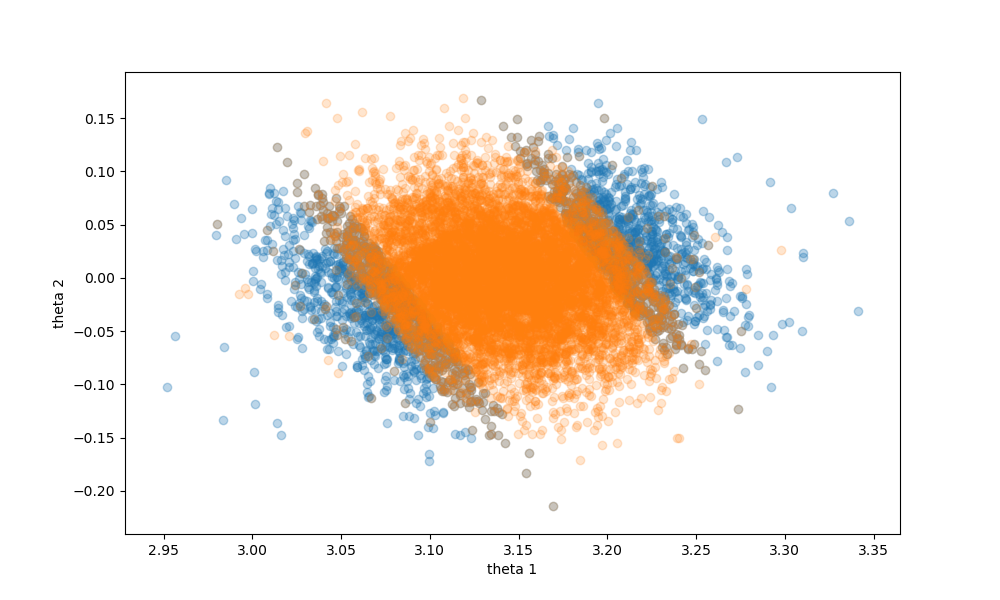

Text(0, 0.5, 'theta 2')

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

img = ax.scatter(points_failed[:, 0], points_failed[:, 1], alpha = 0.3)
img2 = ax.scatter(points_new[:, 0], points_new[:, 1], alpha=0.2)

ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [60]:
tr1 = np.linspace(np.pi/2, (3*np.pi)/2, 1000)
tr2 = np.linspace(-np.pi/2, np.pi/2, 1000)

TR1, TR2 = np.meshgrid(tr1, tr2)

In [61]:
np.shape(TR1)

(1000, 1000)

In [66]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 16
        
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    
    failed_V = []
    success_V = []
    
    tr1 = np.linspace(np.pi/2, (3*np.pi)/2, num_itr)
    tr2 = np.linspace(-np.pi/2, np.pi/2, num_itr)

    TR1, TR2 = np.meshgrid(tr1, tr2)
    
    worked_arr = np.zeros_like(TR1)
    V_eval_arr = np.zeros_like(TR1)
    for i in range(len(TR1)):
        for j in range(len(TR1[i])):
            context.SetTime(0.)

            trial = np.array([TR1[i, j], TR2[i, j], 0, 0, 0])

            context.SetContinuousState(trial)
            simulator.Initialize()
            simulator.AdvanceTo(duration)

            log = logger.FindLog(context)

            if plotting: 
                plt.figure(figsize=(5, 4))
                plt.plot(log.sample_times(), log.data().transpose())
                plt.xlabel('t')
                plt.ylabel('y(t)')
            
            state_end = log.data()[:, -1]

            diff = np.abs(state_end - UprightState().CopyToVector())
            
            tolerance = 5e-2
            
            if np.sum(diff < np.ones(4)*tolerance) == 4:
                worked_arr[i, j] = 1

        if i%1 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return TR1, TR2, worked_arr, V_eval_arr

num_itr = 300
plotting = False

TR1, TR2, worked_arr, V_eval_arr = acrobot_balancing_example(False, num_itr, plotting)

np.save('./300by300TR1.npy', TR1)
np.save('./300by300TR2.npy', TR2)
np.save('./worked_arr_300.npy', worked_arr)
np.save('./V_eval_arr_300.npy', V_eval_arr)
print('Starting Other')
TR1_new, TR2_new, worked_arr_new, \
    V_eval_arr_new = acrobot_balancing_example(True, num_itr, plotting)
np.save('./worked_arr_new_300.npy', worked_arr_new)
np.save('./V_eval_arr_new_300.npy', V_eval_arr_new)

Reached 0
Reached 1
Reached 2
Reached 3
Reached 4
Reached 5
Reached 6
Reached 7
Reached 8
Reached 9
Reached 10
Reached 11
Reached 12
Reached 13
Reached 14
Reached 15
Reached 16
Reached 17
Reached 18
Reached 19
Reached 20
Reached 21
Reached 22
Reached 23
Reached 24
Reached 25
Reached 26
Reached 27
Reached 28
Reached 29
Reached 30
Reached 31
Reached 32
Reached 33
Reached 34
Reached 35
Reached 36
Reached 37
Reached 38
Reached 39
Reached 40
Reached 41
Reached 42
Reached 43
Reached 44
Reached 45
Reached 46
Reached 47
Reached 48
Reached 49
Reached 50
Reached 51
Reached 52
Reached 53
Reached 54
Reached 55
Reached 56
Reached 57
Reached 58
Reached 59
Reached 60
Reached 61
Reached 62
Reached 63
Reached 64
Reached 65
Reached 66
Reached 67
Reached 68
Reached 69
Reached 70
Reached 71
Reached 72
Reached 73
Reached 74
Reached 75
Reached 76
Reached 77
Reached 78
Reached 79
Reached 80
Reached 81
Reached 82
Reached 83
Reached 84
Reached 85
Reached 86
Reached 87
Reached 88
Reached 89
Reached 90
Reached 9

In [67]:
V

<Polynomial "4176.408784908559*1 + 25.019636572250128*\dot{t2}(0)^2 + 102.09630966587379*\dot{t1}(0) * \dot{t2}(0) + 107.00000496053462*\dot{t1}(0)^2 + -654.96981356205947*c2(0) + 39.052540526161678*c2(0) * \dot{t2}(0)^2 + 160.62481655063513*c2(0) * \dot{t1}(0) * \dot{t2}(0) + 160.7129049879122*c2(0) * \dot{t1}(0)^2 + 16.84029326925371*c2(0)^2 * \dot{t2}(0)^2 + 63.043398964192889*c2(0)^2 * \dot{t1}(0) * \dot{t2}(0) + 60.347283756022406*c2(0)^2 * \dot{t1}(0)^2 + 178.80896401403871*s2(0) * \dot{t2}(0) + 373.6894892185075*s2(0) * \dot{t1}(0) + 146.19694313913635*s2(0) * c2(0) * \dot{t2}(0) + 280.63977322487972*s2(0) * c2(0) * \dot{t1}(0) + 3521.4389713464993*c1(0) + -414.1158172339907*s1(0) * \dot{t2}(0) + -867.76785746114444*s1(0) * \dot{t1}(0) + -340.32411119816487*s1(0) * c2(0) * \dot{t2}(0) + -651.68938731394735*s1(0) * c2(0) * \dot{t1}(0) + -1515.5320202469929*s1(0) * s2(0)">

In [68]:
success_indices_new = np.where(worked_arr_new == 1)

In [69]:
success_indices = np.where(worked_arr == 1)

In [70]:
len(success_indices_new[0])

693

In [85]:
np.save('./100by100TR1.npy', TR1)
np.save('./100by100TR2.npy', TR2)
np.save('./worked_arr.npy', worked_arr)
np.save('./V_eval_arr.npy', V_eval_arr)
np.save('./worked_arr_new.npy', worked_arr_new)
np.save('./V_eval_arr_new.npy', V_eval_arr_new)

In [76]:
TR1 = np.load('./100by100TR1.npy')
TR2 = np.load('./100by100TR2.npy')
worked_arr = np.load('./worked_arr.npy')
V_eval_arr = np.load('./V_eval_arr.npy')
worked_arr_new = np.load('./worked_arr_new.npy')
V_eval_arr_new = np.load('./V_eval_arr_new.npy')
success_indices_new = np.where(worked_arr_new == 1)
success_indices = np.where(worked_arr == 1)

In [32]:
TR1_300 = np.load('./300by300TR1.npy')
TR2_300 = np.load('./300by300TR2.npy')
worked_arr_300 = np.load('./worked_arr_300.npy')
V_eval_arr_300 = np.load('./V_eval_arr_300.npy')
worked_arr_new_300 = np.load('./worked_arr_new_300.npy')
V_eval_arr_new_300 = np.load('./V_eval_arr_new_300.npy')
success_indices_new_300 = np.where(worked_arr_new_300 == 1)
success_indices_300 = np.where(worked_arr_300 == 1)
fail_indices_new_300 = np.where(worked_arr_new_300 == 0)

<IPython.core.display.Javascript object>


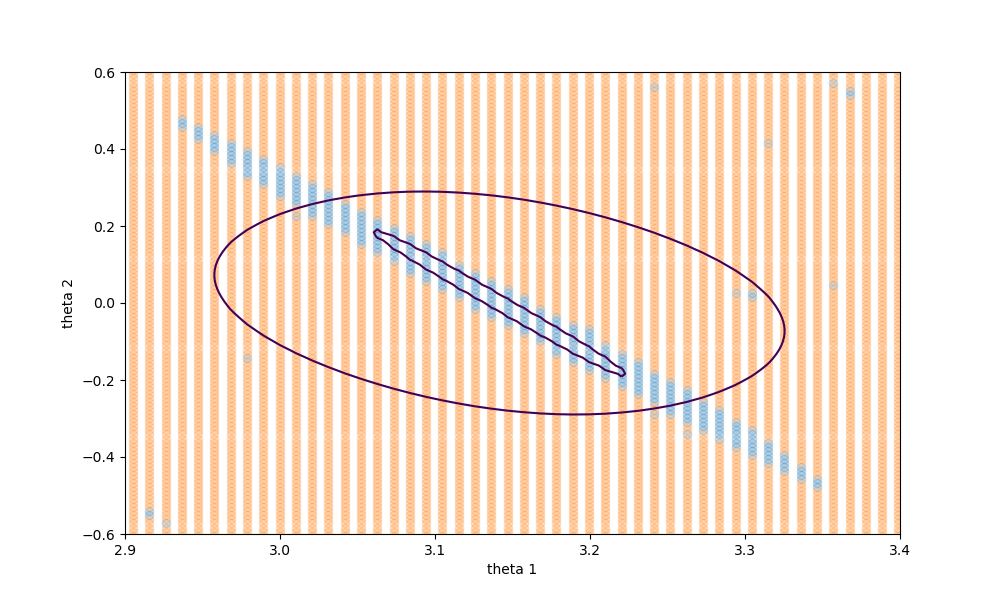

Text(0, 0.5, 'theta 2')

In [163]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
img = ax.scatter(TR1_300[success_indices_new_300], TR2_300[success_indices_new_300], alpha=0.2)
img = ax.scatter(TR1_300[fail_indices_new_300], TR2_300[fail_indices_new_300], alpha=0.2)

Vplot = np.zeros_like(TR1_300)
Vdotplot = np.zeros_like(TR1_300)
env = {s1[0]:0, c1[0]:1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}
for i in range(len(TR1_300)):
    for j in range(len(TR1_300[i])): 
        env[s1[0]] = np.sin(TR1_300[i, j])
        env[c1[0]] = np.cos(TR1_300[i, j])
        env[s2[0]] = np.sin(TR2_300[i, j])
        env[c2[0]] = np.cos(TR2_300[i, j])
        Vplot[i, j] = V.Evaluate(env)
        Vdotplot[i, j] = Vdot.Evaluate(env)

ax.contour(TR1_300,TR2_300, Vplot*100, levels=[2e-1])
ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [117]:
V.TotalDegree()

4

In [131]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

In [132]:
K2

array([[-278.4422312581945, -112.29125984628342,
        <Expression "(18.072653232496453 * (1.3300000000000001 + cos(t2)) - 34.705952348380265 * (2.6630000000000003 + 2 * cos(t2)))">,
        <Expression "(24.036628799220285 - 34.705952348380265 * (1.3300000000000001 + cos(t2)))">]],
      dtype=object)

In [133]:
def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
        
    start_time = time.time()
    
    failed_V = []
    success_V = []
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.random.randn(5,)
        
        trial = np.array([ 1.57079633, -0.17453293, 0, 0, 0])
        
        env[s1] = np.sin(trial[0] - np.pi)
        env[c1] = np.cos(trial[0] - np.pi)
        env[s2] = np.sin(trial[1])
        env[c2] = np.cos(trial[1])
        env[td1] = trial[2]
        env[td2] = trial[3]
        
        V_evaluated = V.Evaluate(env)
        
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        teta = log.data()[0]
        avg_angle = np.average(teta[2*int(len(teta)/3):])
#         print(avg_angle)
        if  avg_angle - np.pi < 2*1e-2:
            points.append(trial[:-1])
            success_V.append(V_evaluated)
        else: 
            points_failed.append(trial[:-1])
            failed_V.append(V_evaluated)
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed, failed_V, success_V

num_itr = 1
plotting = True
max_seed = 20000

_, __, ____, _____ = acrobot_balancing_example(True, num_itr, plotting, max_seed)

TypeError: unhashable type: 'numpy.ndarray'

In [103]:
UprightState().CopyToVector() + 0.05 * np.random.randn(4,)

array([ 3.09582565,  0.00313207, -0.08825696,  0.07258637])

New approach to the Acrobot

In [1]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, SolverOptions, CommonSolverOption, SolverOptions)

from pydrake.solvers.mosek import MosekSolver

import numpy as np

In [2]:
p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [3]:
# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [30]:
# def find_implicit_V(B, X, S, V): 
prog = MathematicalProgram()
t1 = prog.NewIndeterminates(1, "t1")
t2 = prog.NewIndeterminates(1, "t2")
s1 = prog.NewIndeterminates(1, "s1")
c1 = prog.NewIndeterminates(1, "c1")
s2 = prog.NewIndeterminates(1, "s2")
c2 = prog.NewIndeterminates(1, "c2")
td1 = prog.NewIndeterminates(1, "\dot{t1}")
td2 = prog.NewIndeterminates(1, "\dot{t2}")

rho = prog.NewContinuousVariables(1, 'rho')[0]
alpha = prog.NewContinuousVariables(1, 'alpha')[0]

x = np.hstack([s1, c1, s2, c2, td1, td2])
x_0 = np.array([0, -1, 0, 1, 0, 0])
z = np.hstack([t1, t2, td1, td2])

M44 = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
              [0, 0, I2 + m2*l1*lc2*c2[0], I2]])

Mdot44 = np.array([[0, 0, 0, 0], \
              [0, 0, 0, 0], \
              [0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
              [0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

Vz = Polynomial(z.T@M44.T@P@M44@z)

V = 0
for m, coeff in Vz.monomial_to_coefficient_map().items(): 
    monomial = coeff
    for i in range(len(x[:-2])): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            if d == 1:
                monomial *= -x[0]
            elif d == 2:
                monomial *= (2+2*x[1])
        elif i==1:
            if d == 1:
                monomial *= x[2]
            elif d == 2:
                monomial *= (2-2*x[3])
        elif i==2 or i==3:
            monomial *= x[i+2]**d
    V += monomial

V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)
V = V/1000

K2 = B.T@X@M44
u = -K2@z

fz = np.array([[td1[0]], \
               [td2[0]], \
               [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] - m2*gravity*(l1*s1[0] + lc2*(s1[0]*c2[0] + c1[0]*s2[0]))], \
               [- m2*l1*lc2*s2[0]*td1[0]**2 - \
            m2*gravity*lc2*(s1[0]*c2[0] + c1[0]*s2[0]) + u[0]]])

Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
Vdotz = Polynomial(Vdotz[0])

Vdot = 0
for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
    monomial = coeff
    for i in range(len(x[:-2])): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            if d == 1:
                monomial *= -x[0]
            elif d == 2:
                monomial *= (2+2*x[1])
        elif i==1:
            if d == 1:
                monomial *= x[2]
            elif d == 2:
                monomial *= (2-2*x[3])
        elif i==2 or i==3:
            monomial *= x[i+2]**d
    Vdot += monomial

Vdot = Polynomial(Vdot).RemoveTermsWithSmallCoefficients(1e-5)
Vdot = Vdot/1000

s_deg = max(V.TotalDegree()-2, 0)
lambda_trig_1 = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_trig_2 = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 4)
# lambda_ = prog.NewFreePolynomial(Variables(x), 4)

trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)

eps = 1e-5
rho = 1e-6

prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) - alpha +\
                      lambda_trig_1*trig_1 + lambda_trig_2*trig_2 + \
                      lambda_*(V - rho))

# prog.AddSosConstraint(eps*Polynomial((x-x_0).dot(x-x_0))*(V - rho) + \
#                       lambda_trig_1*trig_1 + lambda_trig_2*trig_2 - \
#                       lambda_*Vdot)

#prog.AddCost(-rho)
prog.AddCost(-alpha)
prog.AddLinearConstraint(alpha, 1e-8, float('inf'))

lambda_enforcer_trig_1 = prog.NewFreePolynomial(Variables(x), 2)
lambda_enforcer_trig_2 = prog.NewFreePolynomial(Variables(x), 2)
lambda_enforcer_range, _ = prog.NewSosPolynomial(Variables(x), 4)

# prog.AddSosConstraint(lambda_ + lambda_enforcer_trig_1*trig_1 + lambda_enforcer_trig_2*trig_2 + \
#                       lambda_enforcer_range*(V - rho))

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')
options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_INTPNT_TOL_REL_GAP", 1e-1)


solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

#print(result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-2))

assert result.is_success(), str(result.get_solver_details().solution_status)

print(rho)

1e-06


<IPython.core.display.Javascript object>


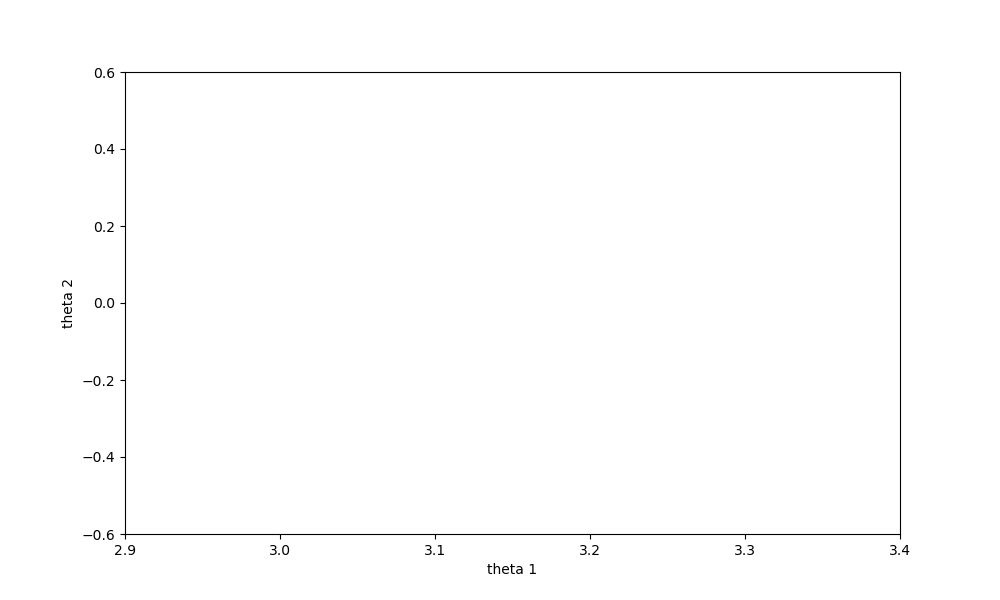

/tmp/ipykernel_13199/527296185.py:23: UserWarning: No contour levels were found within the data range.
  ax.contour(TR1_300,TR2_300, Vplot*1000, levels=[2e-3])


Text(0, 0.5, 'theta 2')

In [35]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
# img = ax.scatter(TR1_300[success_indices_new_300], TR2_300[success_indices_new_300], alpha=0.2)
# img = ax.scatter(TR1_300[fail_indices_new_300], TR2_300[fail_indices_new_300], alpha=0.2)

Vplot = np.zeros_like(TR1_300)
Vdotplot = np.zeros_like(TR1_300)
env = {s1[0]:0, c1[0]:-1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}
for i in range(len(TR1_300)):
    for j in range(len(TR1_300[i])): 
        env[s1[0]] = np.sin(TR1_300[i, j])
        env[c1[0]] = np.cos(TR1_300[i, j])
        env[s2[0]] = np.sin(TR2_300[i, j])
        env[c2[0]] = np.cos(TR2_300[i, j])
        Vplot[i, j] = V.Evaluate(env)
        Vdotplot[i, j] = Vdot.Evaluate(env)

ax.contour(TR1_300,TR2_300, Vplot*1000, levels=[2e-3])
# ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [31]:
result.GetSolution(alpha)

-4.304639489305373e-08

In [11]:
Vdot

<Polynomial "-187.66493636235563*1 + 1.4719561998485036*\dot{t2}(0)^2 + 5.3114061583703593*\dot{t1}(0) * \dot{t2}(0) + 3.7644531843906233*\dot{t1}(0)^2 + 26.397683262822806*c2(0) + 0.010821625261688722*c2(0) * \dot{t2}(0)^2 + -1.1631120532471946*c2(0) * \dot{t1}(0) * \dot{t2}(0) + -0.85913029006627939*c2(0) * \dot{t1}(0)^2 + -1.4985246261066845*c2(0)^2 * \dot{t2}(0)^2 + -4.0881378282507184*c2(0)^2 * \dot{t1}(0) * \dot{t2}(0) + -2.76833073297782*c2(0)^2 * \dot{t1}(0)^2 + 2.3447471235492277*s2(0) * \dot{t2}(0) + -0.95046795484648894*s2(0) * \dot{t1}(0) + 0.014290268836802938*s2(0) * \dot{t1}(0) * \dot{t2}(0)^2 + 0.086136466597522346*s2(0) * \dot{t1}(0)^2 * \dot{t2}(0) + 0.071846197760719446*s2(0) * \dot{t1}(0)^3 + -8.927859823889758*s2(0) * c2(0) * \dot{t2}(0) + -12.089477126199059*s2(0) * c2(0) * \dot{t1}(0) + 0.04317774112821951*s2(0) * c2(0) * \dot{t1}(0) * \dot{t2}(0)^2 + 0.097100045291629161*s2(0) * c2(0) * \dot{t1}(0)^2 * \dot{t2}(0) + 0.053922304163409603*s2(0) * c2(0) * \dot{t1}(

In [12]:
a1 = Vdot.Jacobian(x)

Vdot_Hessian = []
for element in a1: 
    Vdot_Hessian.append(element.Jacobian(x))
Vdot_Hessian = np.array(Vdot_Hessian)

In [13]:
env = {s1[0]:0, c1[0]:-1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}

Vdot_Hessian_origin = np.zeros_like(Vdot_Hessian)

for i in range(len(Vdot_Hessian)): 
    for j in range(len(Vdot_Hessian[i])): 
        Vdot_Hessian_origin[i, j] = Vdot_Hessian[i, j].Evaluate(env)
        
Vdot_Hessian_origin = np.array(Vdot_Hessian_origin, dtype=float)

In [14]:
np.linalg.eigvals(Vdot_Hessian_origin)

array([ 1.61247978e+02,  2.63785069e+01,  2.83965277e-01, -4.30228860e-02,
        0.00000000e+00,  0.00000000e+00])

In [15]:
type(Vdot_Hessian_origin[0][0])

numpy.float64

In [18]:
prog2 = MathematicalProgram()
prog2.AddIndeterminates(x)

lambda_check_2 = prog2.NewFreePolynomial(Variables(x), 3)
lambda_check_2_2 = prog2.NewFreePolynomial(Variables(x), 3)

prog2.AddSosConstraint(V  - eps*Polynomial((x-x_0).dot(x-x_0)) \
                       + lambda_check_2*trig_1 + lambda_check_2_2*trig_2)

solver = MosekSolver()
result2 = solver.Solve(prog2)

assert result2.is_success(), str(result2.get_solver_details().solution_status)

In [108]:
env = {s1[0]:0, c1[0]:-1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}
V = V - 4.547473508864641e-13
(V).Evaluate(env)

4.547473508864641e-13

In [43]:
coeff = 1e-5

def find_implicit_lambdas_M(V, Vdot, x, x_0): 
    global coeff
    
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    s_deg = max(V.TotalDegree()-2, 0)

    lambda_trig_1 = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_trig_2 = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_, _ = prog.NewSosPolynomial(Variables(x), 4)

    trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
    trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)

    eps = 1e-7

    prog.AddSosConstraint(eps*Polynomial((x-x_0).dot(x-x_0))*(V - 1) + \
                          lambda_trig_1*trig_1 + lambda_trig_2*trig_2 + \
                          -lambda_*Vdot)

    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_DATA_TOL_X", 1e-6)


    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)
    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    lambda_sol = result.GetSolution(lambda_)
    lambda_trig_1_sol = result.GetSolution(lambda_trig_1).RemoveTermsWithSmallCoefficients(coeff)
    lambda_trig_2_sol = result.GetSolution(lambda_trig_2).RemoveTermsWithSmallCoefficients(coeff)
    
    return lambda_sol, lambda_trig_1_sol, lambda_trig_2_sol
    
def find_implicit_v_M(V, Vdot, lambda_, lambda_trig_1, lambda_trig_2, x, x_0): 
    global coeff
    
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
    trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    eps = 1e-7
    
    lambda_, _ = prog.NewSosPolynomial(Variables(x), 4)
    prog.AddSosConstraint(eps*Polynomial((x-x_0).dot(x-x_0))*(V - 1)  + \
                          lambda_trig_1*trig_1 + lambda_trig_2*trig_2 + \
                          -lambda_*Vdot)
    
    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_DATA_TOL_X", 1e-6)


    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)
    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    return result.GetSolution(lambda_)
    
def alternations_implicit_M(P, B, X): 
    prog = MathematicalProgram()
    t1 = prog.NewIndeterminates(1, "t1")
    t2 = prog.NewIndeterminates(1, "t2")
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")

    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    z = np.hstack([t1, t2, td1, td2])

    M44 = np.array([[1, 0, 0, 0], \
                  [0, 1, 0, 0], \
                  [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
                  [0, 0, I2 + m2*l1*lc2*c2[0], I2]])

    Mdot44 = np.array([[0, 0, 0, 0], \
                  [0, 0, 0, 0], \
                  [0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
                  [0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

    Vz = Polynomial(z.T@M44.T@P@M44@z)

    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        monomial = coeff
        for i in range(len(x[:-2])): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                if d == 1:
                    monomial *= x[0]
                elif d == 2:
                    monomial *= (2-2*x[1])
            elif i==1:
                if d == 1:
                    monomial *= x[2]
                elif d == 2:
                    monomial *= (2-2*x[3])
            elif i==2 or i==3:
                monomial *= x[i+2]**d
        V += monomial

    V = Polynomial(V)

    K2 = B.T@X@M44
    u = -K2@z

    fz = np.array([[td1[0]], \
                   [td2[0]], \
                   [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                    m2*l1*lc2*s2[0]*td2[0]**2 + \
                        m1*gravity*lc1*s1[0] - m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))], \
                   [- m2*l1*lc2*s2[0]*td1[0]**2 - \
                m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) + u[0]]])

    Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
    Vdotz = Polynomial(Vdotz[0])

    Vdot = 0
    for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
        monomial = coeff
        for i in range(len(x[:-2])): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                if d == 1:
                    monomial *= x[0]
                elif d == 2:
                    monomial *= (2-2*x[1])
            elif i==1:
                if d == 1:
                    monomial *= x[2]
                elif d == 2:
                    monomial *= (2-2*x[3])
            elif i==2 or i==3:
                monomial *= x[i+2]**d
        Vdot += monomial

    Vdot = Polynomial(Vdot)
    
    for i in range(1): 
        lambda_, lambda_s1, lambda_s2 = find_implicit_lambdas_M(V, Vdot, x, x_0)
        print(lambda_)
        lambda_2 = find_implicit_v_M(V, Vdot, lambda_, lambda_s1, lambda_s2, x, x_0)
        
    return lambda_, lambda_s1, lambda_s2, lambda_2

lambda_, lambda_s1, lambda_s2, lambda_2 = alternations_implicit_M(P, B, X)

1.6800921867643239e-07*1 + -4.8925867854441216e-23*\dot{t2}(0) + 2.4947906092433601e-08*\dot{t2}(0)^2 + 1.4239084126021634e-25*\dot{t2}(0)^3 + 2.1895047382710857e-08*\dot{t2}(0)^4 + -6.5292335943205498e-23*\dot{t1}(0) + -8.2034207436889974e-09*\dot{t1}(0) * \dot{t2}(0) + 2.2947203074519039e-24*\dot{t1}(0) * \dot{t2}(0)^2 + 5.2595595696094796e-12*\dot{t1}(0) * \dot{t2}(0)^3 + 1.921629679585654e-08*\dot{t1}(0)^2 + -2.6641078058242464e-24*\dot{t1}(0)^2 * \dot{t2}(0) + 2.1898511922136427e-08*\dot{t1}(0)^2 * \dot{t2}(0)^2 + 1.359177763751373e-24*\dot{t1}(0)^3 + 5.7339005111802405e-12*\dot{t1}(0)^3 * \dot{t2}(0) + 2.1896978486554972e-08*\dot{t1}(0)^4 + 4.2390398944750666e-09*c2(0) + -2.4322685632258281e-22*c2(0) * \dot{t2}(0) + 3.2376922584038988e-10*c2(0) * \dot{t2}(0)^2 + -4.2657941422624747e-23*c2(0) * \dot{t2}(0)^3 + -6.3549821996421174e-23*c2(0) * \dot{t1}(0) + -8.2596986715642544e-10*c2(0) * \dot{t1}(0) * \dot{t2}(0) + -5.0628031648652115e-23*c2(0) * \dot{t1}(0) * \dot{t2}(0)^2 + -1.37

In [6]:
    
M_u_calc = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
              [0, 0, I2 + m2*l1*lc2*c2[0], I2]])

K2 = B.T@X@M_u_calc
K2 = np.insert(K2, 1, 0)
K2 = np.insert(K2, 3, 0)
u = -K2@x

M = np.array([[1, 0, 0, 0, 0, 0], \
              [0, 1, 0, 0, 0, 0], \
              [0, 0, 1, 0, 0, 0], \
              [0, 0, 0, 1, 0, 0], \
              [0, 0, 0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
              [0, 0, 0, 0, I2 + m2*l1*lc2*c2[0], I2]])

Mdot = np.array([[0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
              [0, 0, 0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

fx = np.array([[c1[0]*td1[0]], \
               [- s1[0]*td1[0]], \
               [c2[0]*td2[0]], \
               [- s2[0]*td2[0]], \
               [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                m2*l1*lc2*s2[0]*td2[0]**2 + \
                    m1*gravity*lc1*s1[0] - m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))], \
               [- m2*l1*lc2*s2[0]*td1[0]**2 - \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) + u]])

V = Polynomial(x.T@M.T@S@M@x)
Vdot = fx.T@S@M@x + x.T@Mdot.T@S@M@x + x.T@M.T@S@Mdot@x + x.T@M.T@S@fx
Vdot = Polynomial(Vdot[0])
    

# find_implicit_V(B, X, P, V)    

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 6)

In [21]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control
import pydrake

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.solvers.mosek import MosekSolver


p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [22]:
prog_create = MathematicalProgram()
x = prog_create.NewIndeterminates(4, 'X')
p1 = x[0]
p2 = x[1]
t1d = x[2]
t2d = x[3]

M = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, (1+p1**2)*(1+p2**2)*(I1+I2+m2*l1**2)+2*m2*l1*lc2*(1+p1**2)*(1-p2**2), \
                                       (1+p1**2)*(1+p2**2)*I2+m2*l1*lc2*(1-p2**2)*(1+p1**2)], 
              [0, 0, I2*(1+p1**2)*(1+p2**2)+m2*l1*lc2*(1+p1**2)*(1-p2**2), I2*(1+p1**2)*(1+p2**2)]])

f3 = -2*m2*l1*lc2*2*p2*t1d*t2d*(1+p1**2) - m2*l1*lc2*2*p2*t2d**2*(1+p1**2) - m1*gravity*lc1*2*p1*(1+p2**2) \
        +m2*gravity*(-l1*2*p1*(1+p2**2) + lc2*(-2*p1*(1-p2**2) - 2*p2*(1-p1**2))) + b1*t1d*(1+p1**2)*(1+p2**2)

f4 = m2*l1*lc2*2*p2*t1d**2*(1+p1**2) + m2*gravity*lc2*(-2*p1*(1-p2**2) - 2*p2*(1-p1**2)) \
                                                                            + b2*t2d*(1+p1**2)*(1+p2**2)

f = np.array([[0.5*(1+p1**2)*t1d], 
              [0.5*(1+p2**2)*t2d], 
              [-f3], 
              [-f4]])

p1d = 0.5*(1+p1**2)*t1d
p2d = 0.5*(1+p2**2)*t2d

Mdot = np.array([[0, 0, 0, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, (2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)*(I1+I2+m2*l1**2)\
                                 +2*m2*l1*lc2*(-2*p2*p2d+2*p1*p1d-2*p1*p2**2*p1d-2*p2*p1**2*p2d), \
                                     (2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)*I2\
                                            +m2*l1*lc1*(-2*p2*p2d+2*p1*p1d-2*p1*p2**2*p1d-2*p2*p1**2*p2d)], \
                 [0, 0, I2*(2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)\
                                             +m2*l1*lc2*(-2*p2*p2d+2*p1*p1d-2*p1*p2**2*p1d-2*p2*p1**2*p2d), \
                                                 I2*(2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)]])

env = {p1:0, p2:0, t1d:0, t2d:0}
A_general = []
for exp in f: 
    exp_curr = exp[0].Jacobian(x)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A[i, j] = elem.Evaluate(env)
        
A = np.array(A, dtype=float)


E = np.zeros_like(M)
for i, row in enumerate(M): 
    for j, elem in enumerate(row): 
        if type(elem) == pydrake.symbolic.Expression:
            E[i, j] = elem.Evaluate(env)
        else: 
            E[i, j] = M[i, j]
        
E = np.array(E, dtype=float)

B = np.array([[0], 
              [0], 
              [0], 
              [1]])

In [23]:
E

array([[1.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 4.663, 2.33 ],
       [0.   , 0.   , 2.33 , 1.33 ]])

In [24]:
A

array([[ 0.  ,  0.  ,  0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.5 ],
       [49.05, 19.62, -0.1 ,  0.  ],
       [19.62, 19.62, -0.  , -0.1 ]])

In [25]:
Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [26]:
K

array([[-523.43456244, -209.8566193 , -112.47195778,  -53.25332814]])

In [27]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([7.15599584e+03, 3.44703440e+00, 1.64267081e+00, 6.74780986e-03])

In [28]:
V = x.T@M.T@P@M@x

In [29]:
Vdot = f.T@P@M@x + x.T@Mdot.T@P@M@x + x.T@M.T@P@Mdot@x + x.T@M.T@P@f

In [30]:
Polynomial(Vdot[0]).TotalDegree()

12

In [31]:
Polynomial(V).TotalDegree()

10

In [35]:
env = {x[0]:0, x[1]:0, x[2]:0, x[3]:0}
V.Evaluate(env)

0.0

<IPython.core.display.Javascript object>


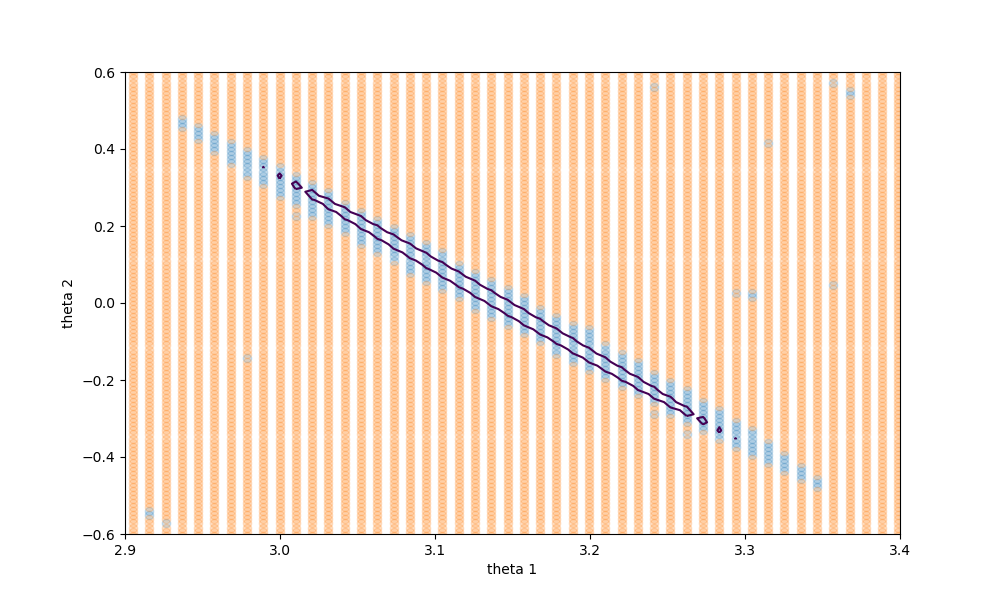

Text(0, 0.5, 'theta 2')

In [44]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
img = ax.scatter(TR1_300[success_indices_new_300], TR2_300[success_indices_new_300], alpha=0.2)
img = ax.scatter(TR1_300[fail_indices_new_300], TR2_300[fail_indices_new_300], alpha=0.2)

Vplot = np.zeros_like(TR1_300)
Vdotplot = np.zeros_like(TR1_300)
for i in range(len(TR1_300)):
    for j in range(len(TR1_300[i])): 
        env[x[0]] = np.sin(TR1_300[i, j] - np.pi)/(1 + np.cos(TR1_300[i, j] - np.pi))
        env[x[1]] = np.sin(TR2_300[i, j])/(1 + np.cos(TR2_300[i, j]))
        Vplot[i, j] = V.Evaluate(env)
        Vdotplot[i, j] = Vdot[0].Evaluate(env)

ax.contour(TR1_300,TR2_300, Vplot, levels=[0.12477635493634774])
#ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [46]:
prog_haha = MathematicalProgram()
X = prog_haha.NewIndeterminates(4, 'X')

In [47]:
exp_X = 0.12518902758103712*1 + 8.2972026350245976e-18*X(3) + \
0.013247055707218031*X(3)^2 + 5.7083640808180188e-17*X(3)^3 + 0.00068878290855035797*X(3)^4 + \
-3.1995146596834894e-18*X(3)^5 + 7.1335137242291811e-05*X(3)^6 + 4.5977623630688451e-19*X(3)^7 + \
1.0789357952013599e-05*X(3)^8 + 4.8518095398956487e-21*X(3)^9 + -5.3473017213158224e-08*X(3)^10 + \
-1.1113112428122548e-21*X(3)^11 + 1.9070948992776121e-07*X(3)^12 + -5.5686051409968009e-19*X(2) + \
0.006835723045658694*X(2) * X(3) + 8.7775660394979511e-19*X(2) * X(3)^2 + 0.007284880582309917*X(2) * \
X(3)^3 + 3.1314245285846551e-18*X(2) * X(3)^4 + 0.00041319182521095798*X(2) * X(3)^5 + \
1.2482602232561486e-18*X(2) * X(3)^6 + -4.6385624278278808e-06*X(2) * X(3)^7 + \
-9.7194763504111939e-20*X(2) * X(3)^8 + -2.4279559545456603e-06*X(2) * X(3)^9 + \
9.2196803205250703e-22*X(2) * X(3)^10 + 6.6855201864873367e-08*X(2) * X(3)^11 + \
-0.03094211766270321*X(2)^2 + -4.1143562407173278e-18*X(2)^2 * X(3) + \
0.012786196753083668*X(2)^2 * X(3)^2 + -2.3750602050766733e-17*X(2)^2 * X(3)^3 + \
0.00052061094098461631*X(2)^2 * X(3)^4 + 5.3798840254938096e-19*X(2)^2 * X(3)^5 + \
-4.1424715844640619e-05*X(2)^2 * X(3)^6 + -1.0896298559458175e-20*X(2)^2 * X(3)^7 + \
9.8030304805914132e-08*X(2)^2 * X(3)^8 + 4.3867633135745789e-21*X(2)^2 * X(3)^9 + \
1.9556455123203925e-07*X(2)^2 * X(3)^10 + -2.4256718130226756e-17*X(2)^3 + -0.00047647048922879159*X(2)^3 * X(3) + 2.9716308250285057e-18*X(2)^3 * X(3)^2 + 0.001993287727546767*X(2)^3 * X(3)^3 + 4.0311898114435791e-19*X(2)^3 * X(3)^4 + -2.4515851461872788e-05*X(2)^3 * X(3)^5 + 3.6239924620130634e-20*X(2)^3 * X(3)^6 + -1.9058617331822451e-07*X(2)^3 * X(3)^7 + 7.6043628010201538e-21*X(2)^3 * X(3)^8 + -7.0661750856298648e-08*X(2)^3 * X(3)^9 + 0.003292756640064929*X(2)^4 + -2.0293552503785445e-19*X(2)^4 * X(3) + 0.00026099440636103734*X(2)^4 * X(3)^2 + 2.7069574605941154e-18*X(2)^4 * X(3)^3 + 5.580229931711499e-05*X(2)^4 * X(3)^4 + 9.8141542215455859e-20*X(2)^4 * X(3)^5 + 5.1172907976256224e-06*X(2)^4 * X(3)^6 + 2.1035417334005993e-21*X(2)^4 * X(3)^7 + 2.9128463943875284e-07*X(2)^4 * X(3)^8 + 3.0530249256713996e-18*X(2)^5 + 0.0010369702553993799*X(2)^5 * X(3) + -1.4880069089269785e-18*X(2)^5 * X(3)^2 + 1.9899795566328155e-05*X(2)^5 * X(3)^3 + -1.013418717645158e-19*X(2)^5 * X(3)^4 + -1.4662170285511935e-06*X(2)^5 * X(3)^5 + -9.2758541149366696e-21*X(2)^5 * X(3)^6 + -5.6279238932214273e-08*X(2)^5 * X(3)^7 + -0.00023174651596785277*X(2)^6 + -2.1687334750101458e-19*X(2)^6 * X(3) + -5.127040323352997e-05*X(2)^6 * X(3)^2 + -1.3923038222735458e-19*X(2)^6 * X(3)^3 + 4.3847845880181938e-06*X(2)^6 * X(3)^4 + -1.8769475353690396e-21*X(2)^6 * X(3)^5 + 3.5608696651510214e-07*X(2)^6 * X(3)^6 + 3.3247754121392448e-20*X(2)^7 + -1.7615388419333623e-05*X(2)^7 * X(3) + -7.9566595699533785e-20*X(2)^7 * X(3)^2 + -3.4100055327853106e-06*X(2)^7 * X(3)^3 + 1.7111170726417232e-22*X(2)^7 * X(3)^4 + 1.1820606069145404e-07*X(2)^7 * X(3)^5 + 2.1473372058947767e-06*X(2)^8 + 3.8212726750268187e-20*X(2)^8 * X(3) + 3.3304230632177915e-06*X(2)^8 * X(3)^2 + 8.5652791057452085e-21*X(2)^8 * X(3)^3 + 3.8516987775375199e-07*X(2)^8 * X(3)^4 + 6.0191811579880675e-20*X(2)^9 + -4.9233631462695802e-06*X(2)^9 * X(3) + 1.8120110400674519e-20*X(2)^9 * X(3)^2 + -1.4857233659477051e-07*X(2)^9 * X(3)^3 + 2.506191062232825e-06*X(2)^10 + -6.1825447383560263e-21*X(2)^10 * X(3) + 5.0216493732956697e-07*X(2)^10 * X(3)^2 + -4.3566113484891203e-21*X(2)^11 + -8.0186634197262457e-08*X(2)^11 * X(3) + 1.8542166854655899e-07*X(2)^12 + 2.8196530022281158e-17*X(1) + 0.022326766088532613*X(1) * X(3) + -5.8585956012513543e-17*X(1) * X(3)^2 + -0.0042074107918676114*X(1) * X(3)^3 + 2.9748150649899923e-18*X(1) * X(3)^4 + 5.3187085883850817e-05*X(1) * X(3)^5 + -1.4775963765696296e-18*X(1) * X(3)^6 + -8.140013021883131e-05*X(1) * X(3)^7 + 1.5423337751612631e-19*X(1) * X(3)^8 + 7.1383513360584535e-06*X(1) * X(3)^9 + -1.0560530957756684e-21*X(1) * X(3)^10 + -1.3474865882540016e-07*X(1) * X(3)^11 + -0.021675679581004206*X(1) * X(2) + -7.9274545215850573e-18*X(1) * X(2) * X(3) + -0.0029160227075894331*X(1) * X(2) * X(3)^2 + 3.0266497819831481e-17*X(1) * X(2) * X(3)^3 + -0.0012926580799240061*X(1) * X(2) * X(3)^4 + -3.9501686688359236e-18*X(1) * X(2) * X(3)^5 + -0.00020368969276745856*X(1) * X(2) * X(3)^6 + 2.5270024215199541e-19*X(1) * X(2) * X(3)^7 + 1.7292374361298522e-05*X(1) * X(2) * X(3)^8 + -3.0961806127082819e-20*X(1) * X(2) * X(3)^9 + -3.7543911781598125e-07*X(1) * X(2) * X(3)^10 + -3.42126895526499e-17*X(1) * X(2)^2 + -0.012038472592216454*X(1) * X(2)^2 * X(3) + 3.7503682287137535e-17*X(1) * X(2)^2 * X(3)^2 + -0.0012997462730320523*X(1) * X(2)^2 * X(3)^3 + -9.3949058010497644e-18*X(1) * X(2)^2 * X(3)^4 + -0.00044712270779819353*X(1) * X(2)^2 * X(3)^5 + 2.2961332963233864e-20*X(1) * X(2)^2 * X(3)^6 + 1.4298913225981614e-05*X(1) * X(2)^2 * X(3)^7 + -3.4978445191442468e-21*X(1) * X(2)^2 * X(3)^8 + -3.2871089611155472e-07*X(1) * X(2)^2 * X(3)^9 + -0.0014989815867398194*X(1) * X(2)^3 + -1.9791344790495466e-17*X(1) * X(2)^3 * X(3) + -0.0025069151279621085*X(1) * X(2)^3 * X(3)^2 + -6.0629228372374316e-18*X(1) * X(2)^3 * X(3)^3 + -0.00054196419643250549*X(1) * X(2)^3 * X(3)^4 + 3.264352054606525e-19*X(1) * X(2)^3 * X(3)^5 + -1.2771250183106491e-05*X(1) * X(2)^3 * X(3)^6 + 1.45924725382123e-20*X(1) * X(2)^3 * X(3)^7 + -1.9993751848318407e-07*X(1) * X(2)^3 * X(3)^8 + 1.971392363736628e-17*X(1) * X(2)^4 + 0.0025874761535455621*X(1) * X(2)^4 * X(3) + -6.1751695862020832e-18*X(1) * X(2)^4 * X(3)^2 + -0.00044004931194456049*X(1) * X(2)^4 * X(3)^3 + 6.3309766058664608e-19*X(1) * X(2)^4 * X(3)^4 + -2.1679986482480237e-05*X(1) * X(2)^4 * X(3)^5 + 3.5703681500822334e-20*X(1) * X(2)^4 * X(3)^6 + -2.0286623921710776e-07*X(1) * X(2)^4 * X(3)^7 + 0.00073151854014259017*X(1) * X(2)^5 + 8.7844084226731005e-19*X(1) * X(2)^5 * X(3) + 0.00015128450278302809*X(1) * X(2)^5 * X(3)^2 + 8.8674140139585324e-20*X(1) * X(2)^5 * X(3)^3 + 7.3121006226947608e-07*X(1) * X(2)^5 * X(3)^4 + -3.6386407618069575e-20*X(1) * X(2)^5 * X(3)^5 + -8.8093418604933705e-07*X(1) * X(2)^5 * X(3)^6 + -1.9638685582719787e-18*X(1) * X(2)^6 + -0.000377173034200844*X(1) * X(2)^6 * X(3) + 1.1681560072914282e-19*X(1) * X(2)^6 * X(3)^2 + 2.5763862840066625e-05*X(1) * X(2)^6 * X(3)^3 + -6.5113975763864178e-20*X(1) * X(2)^6 * X(3)^4 + -1.1214113636010944e-06*X(1) * X(2)^6 * X(3)^5 + 7.8158542674125939e-05*X(1) * X(2)^7 + 5.1137021105329531e-19*X(1) * X(2)^7 * X(3) + 1.5140669169498683e-05*X(1) * X(2)^7 * X(3)^2 + 4.9505922517470583e-21*X(1) * X(2)^7 * X(3)^3 + -8.1912824415140035e-07*X(1) * X(2)^7 * X(3)^4 + -8.4053040016261646e-22*X(1) * X(2)^8 + 1.6118215245880541e-05*X(1) * X(2)^8 * X(3) + 5.4596375110329239e-22*X(1) * X(2)^8 * X(3)^2 + -9.2010679186409532e-07*X(1) * X(2)^8 * X(3)^3 + -4.9476332270330794e-06*X(1) * X(2)^9 + -5.1935003197378123e-20*X(1) * X(2)^9 * X(3) + -2.6294500487318577e-07*X(1) * X(2)^9 * X(3)^2 + 3.2581984959608515e-21*X(1) * X(2)^10 + -9.6455188088428565e-09*X(1) * X(2)^10 * X(3) + -5.045488422022099e-08*X(1) * X(2)^11 + -0.061059678921662572*X(1)^2 + 1.2601708978007473e-17*X(1)^2 * X(3) + 0.00549738163924832*X(1)^2 * X(3)^2 + 5.226588139528923e-18*X(1)^2 * X(3)^3 + 0.00058822341595424319*X(1)^2 * X(3)^4 + -2.9013291960276885e-18*X(1)^2 * X(3)^5 + -7.9065775924888078e-05*X(1)^2 * X(3)^6 + 1.9261627593140193e-19*X(1)^2 * X(3)^7 + -9.5741048871010595e-06*X(1)^2 * X(3)^8 + 2.5451152191915042e-21*X(1)^2 * X(3)^9 + 6.4859114411473525e-07*X(1)^2 * X(3)^10 + 1.7710243834679098e-17*X(1)^2 * X(2) + 0.0046775742103659134*X(1)^2 * X(2) * X(3) + 9.8218816355020714e-18*X(1)^2 * X(2) * X(3)^2 + 0.0020198851907483242*X(1)^2 * X(2) * X(3)^3 + -6.4173886437570891e-18*X(1)^2 * X(2) * X(3)^4 + 0.000295633394889543*X(1)^2 * X(2) * X(3)^5 + -9.4982048608282438e-19*X(1)^2 * X(2) * X(3)^6 + -1.8297251985511255e-05*X(1)^2 * X(2) * X(3)^7 + 9.6582494295758821e-20*X(1)^2 * X(2) * X(3)^8 + 2.6351262175132028e-07*X(1)^2 * X(2) * X(3)^9 + 0.0041682441756214928*X(1)^2 * X(2)^2 + -1.3480748670330105e-17*X(1)^2 * X(2)^2 * X(3) + -0.0034285557841958877*X(1)^2 * X(2)^2 * X(3)^2 + 8.0697431478324891e-18*X(1)^2 * X(2)^2 * X(3)^3 + 0.0012175902169440347*X(1)^2 * X(2)^2 * X(3)^4 + -1.5029556476548746e-19*X(1)^2 * X(2)^2 * X(3)^5 + -9.1772027046761818e-06*X(1)^2 * X(2)^2 * X(3)^6 + 2.235687941852858e-20*X(1)^2 * X(2)^2 * X(3)^7 + 1.1954421803932424e-06*X(1)^2 * X(2)^2 * X(3)^8 + 4.8872535097643791e-18*X(1)^2 * X(2)^3 + -0.00012018273703804185*X(1)^2 * X(2)^3 * X(3) + -1.6132995900351815e-18*X(1)^2 * X(2)^3 * X(3)^2 + 0.00036935598928016742*X(1)^2 * X(2)^3 * X(3)^3 + -1.1802351874465269e-19*X(1)^2 * X(2)^3 * X(3)^4 + 6.8344517915893354e-05*X(1)^2 * X(2)^3 * X(3)^5 + -5.2304394376237617e-20*X(1)^2 * X(2)^3 * X(3)^6 + 3.1674314337110947e-07*X(1)^2 * X(2)^3 * X(3)^7 + 0.00062802954980508666*X(1)^2 * X(2)^4 + 1.0238158137158719e-20*X(1)^2 * X(2)^4 * X(3) + 0.00036323157280600997*X(1)^2 * X(2)^4 * X(3)^2 + -1.7112330734429045e-18*X(1)^2 * X(2)^4 * X(3)^3 + 2.4955778663674711e-06*X(1)^2 * X(2)^4 * X(3)^4 + -4.8139976793628446e-21*X(1)^2 * X(2)^4 * X(3)^5 + 1.8868607952770163e-06*X(1)^2 * X(2)^4 * X(3)^6 + 4.0226962925702487e-18*X(1)^2 * X(2)^5 + -0.00024385068323434827*X(1)^2 * X(2)^5 * X(3) + 1.0578488701649331e-18*X(1)^2 * X(2)^5 * X(3)^2 + -7.7596638506420297e-05*X(1)^2 * X(2)^5 * X(3)^3 + -5.1758180859608253e-20*X(1)^2 * X(2)^5 * X(3)^4 + 5.0355631029843517e-07*X(1)^2 * X(2)^5 * X(3)^5 + 0.00010583788899870116*X(1)^2 * X(2)^6 + 3.7819338582985989e-19*X(1)^2 * X(2)^6 * X(3) + 3.7298662360665022e-05*X(1)^2 * X(2)^6 * X(3)^2 + 1.3448490262762818e-19*X(1)^2 * X(2)^6 * X(3)^3 + 1.2493283463078543e-06*X(1)^2 * X(2)^6 * X(3)^4 + -1.0135719281667504e-18*X(1)^2 * X(2)^7 + -3.1745474264822742e-05*X(1)^2 * X(2)^7 * X(3) + -6.7943702779703821e-20*X(1)^2 * X(2)^7 * X(3)^2 + 1.1219091163846983e-06*X(1)^2 * X(2)^7 * X(3)^3 + 1.579008806340228e-05*X(1)^2 * X(2)^8 + 1.2402327978815287e-20*X(1)^2 * X(2)^8 * X(3) + 2.5570135099195369e-07*X(1)^2 * X(2)^8 * X(3)^2 + 3.2758620397226364e-20*X(1)^2 * X(2)^9 + 4.8280157100722587e-08*X(1)^2 * X(2)^9 * X(3) + 3.3164573748725287e-07*X(1)^2 * X(2)^10 + -1.2920816441211754e-17*X(1)^3 + -0.0075434670446198494*X(1)^3 * X(3) + 3.8077021707826712e-17*X(1)^3 * X(3)^2 + 0.00050126419088695291*X(1)^3 * X(3)^3 + 3.6169559693843013e-18*X(1)^3 * X(3)^4 + -0.00025495883142793963*X(1)^3 * X(3)^5 + 2.4426292210379604e-20*X(1)^3 * X(3)^6 + 2.5679123852211191e-05*X(1)^3 * X(3)^7 + -3.69167934008372e-20*X(1)^3 * X(3)^8 + -1.435969097988391e-06*X(1)^3 * X(3)^9 + 0.0018349603956352252*X(1)^3 * X(2) + -5.8066682325654442e-18*X(1)^3 * X(2) * X(3) + -0.0013301975893093619*X(1)^3 * X(2) * X(3)^2 + -6.9299440791131836e-18*X(1)^3 * X(2) * X(3)^3 + -0.00045339577600768735*X(1)^3 * X(2) * X(3)^4 + 1.3530429700276382e-18*X(1)^3 * X(2) * X(3)^5 + 4.6468939913217179e-05*X(1)^3 * X(2) * X(3)^6 + 2.1303982871047134e-20*X(1)^3 * X(2) * X(3)^7 + -9.2977847784121165e-07*X(1)^3 * X(2) * X(3)^8 + 1.533638277147194e-17*X(1)^3 * X(2)^2 + 0.0031931436887928659*X(1)^3 * X(2)^2 * X(3) + -1.0279508831310379e-17*X(1)^3 * X(2)^2 * X(3)^2 + -0.00090790589399211935*X(1)^3 * X(2)^2 * X(3)^3 + 2.5851423076121324e-18*X(1)^3 * X(2)^2 * X(3)^4 + 2.1869297090550722e-05*X(1)^3 * X(2)^2 * X(3)^5 + -7.3378682904743669e-20*X(1)^3 * X(2)^2 * X(3)^6 + -3.1491255334872229e-06*X(1)^3 * X(2)^2 * X(3)^7 + 0.0021457999795548308*X(1)^3 * X(2)^3 + 4.7736899333756665e-18*X(1)^3 * X(2)^3 * X(3) + 0.00016716935589878142*X(1)^3 * X(2)^3 * X(3)^2 + -1.5500695195737188e-20*X(1)^3 * X(2)^3 * X(3)^3 + 1.1290816553545441e-05*X(1)^3 * X(2)^3 * X(3)^4 + 1.6848096012221858e-19*X(1)^3 * X(2)^3 * X(3)^5 + -1.809258498232624e-06*X(1)^3 * X(2)^3 * X(3)^6 + -4.2389661979176977e-18*X(1)^3 * X(2)^4 + -0.00048204172530272825*X(1)^3 * X(2)^4 * X(3) + 1.8757520421012388e-18*X(1)^3 * X(2)^4 * X(3)^2 + 9.4315824144189895e-07*X(1)^3 * X(2)^4 * X(3)^3 + -9.9891791112639216e-20*X(1)^3 * X(2)^4 * X(3)^4 + -4.2389793531629466e-06*X(1)^3 * X(2)^4 * X(3)^5 + -4.5645085091611113e-05*X(1)^3 * X(2)^5 + -3.7671849945238956e-19*X(1)^3 * X(2)^5 * X(3) + 8.7990159312603152e-05*X(1)^3 * X(2)^5 * X(3)^2 + 1.1593876576832821e-19*X(1)^3 * X(2)^5 * X(3)^3 + 2.877102190975793e-06*X(1)^3 * X(2)^5 * X(3)^4 + 8.214554784813906e-20*X(1)^3 * X(2)^6 + -7.7653553026170387e-05*X(1)^3 * X(2)^6 * X(3) + -4.410410689863841e-20*X(1)^3 * X(2)^6 * X(3)^2 + -1.6982475066343549e-06*X(1)^3 * X(2)^6 * X(3)^3 + 3.8248946164765843e-05*X(1)^3 * X(2)^7 + 3.5703813261457273e-20*X(1)^3 * X(2)^7 * X(3) + -1.4386016896321894e-06*X(1)^3 * X(2)^7 * X(3)^2 + -4.9055530855015068e-21*X(1)^3 * X(2)^8 + -1.039495059839702e-07*X(1)^3 * X(2)^8 * X(3) + 1.7702216838198206e-08*X(1)^3 * X(2)^9 + 0.011920474214993211*X(1)^4 + 5.3954314573601705e-19*X(1)^4 * X(3) + -0.0010946608438233067*X(1)^4 * X(3)^2 + -3.4977157688529998e-18*X(1)^4 * X(3)^3 + 0.00040704252793320907*X(1)^4 * X(3)^4 + -5.4405429739617119e-19*X(1)^4 * X(3)^5 + -2.6246704149740028e-05*X(1)^4 * X(3)^6 + 4.6324935258349739e-20*X(1)^4 * X(3)^7 + 1.6970844112078912e-06*X(1)^4 * X(3)^8 + -2.8950452578035679e-18*X(1)^4 * X(2) + -0.00149467519635466*X(1)^4 * X(2) * X(3) + 7.9055786045567902e-18*X(1)^4 * X(2) * X(3)^2 + 0.00042414179437580413*X(1)^4 * X(2) * X(3)^3 + 1.3666127608313301e-18*X(1)^4 * X(2) * X(3)^4 + -8.9626543182234935e-05*X(1)^4 * X(2) * X(3)^5 + -1.5116479940787657e-19*X(1)^4 * X(2) * X(3)^6 + 2.5264214373642578e-06*X(1)^4 * X(2) * X(3)^7 + 0.00060307407354221951*X(1)^4 * X(2)^2 + 1.0638866454708623e-17*X(1)^4 * X(2)^2 * X(3) + 0.0006213037239074016*X(1)^4 * X(2)^2 * X(3)^2 + -2.4737219783284161e-18*X(1)^4 * X(2)^2 * X(3)^3 + -7.8309527697417079e-05*X(1)^4 * X(2)^2 * X(3)^4 + 3.0350714914285447e-20*X(1)^4 * X(2)^2 * X(3)^5 + 4.8755843287048664e-06*X(1)^4 * X(2)^2 * X(3)^6 + -1.176393841341198e-18*X(1)^4 * X(2)^3 + -0.00033508936063901724*X(1)^4 * X(2)^3 * X(3) + 3.7451578439247408e-20*X(1)^4 * X(2)^3 * X(3)^2 + -7.7794137123510416e-05*X(1)^4 * X(2)^3 * X(3)^3 + -8.3086770334361659e-20*X(1)^4 * X(2)^3 * X(3)^4 + 4.1225730381227308e-06*X(1)^4 * X(2)^3 * X(3)^5 + 0.00027405790349658828*X(1)^4 * X(2)^4 + -1.0584901261806099e-18*X(1)^4 * X(2)^4 * X(3) + -2.1216250348447168e-05*X(1)^4 * X(2)^4 * X(3)^2 + 9.7338345345993761e-21*X(1)^4 * X(2)^4 * X(3)^3 + 4.8080640922805707e-06*X(1)^4 * X(2)^4 * X(3)^4 + -1.1258752901647088e-19*X(1)^4 * X(2)^5 + -4.5940601562478132e-05*X(1)^4 * X(2)^5 * X(3) + 5.5040695147591119e-20*X(1)^4 * X(2)^5 * X(3)^2 + -1.0002771146521488e-07*X(1)^4 * X(2)^5 * X(3)^3 + 1.4053426089373236e-05*X(1)^4 * X(2)^6 + -2.467054741731597e-20*X(1)^4 * X(2)^6 * X(3) + 1.6346971797607413e-07*X(1)^4 * X(2)^6 * X(3)^2 + 2.6881022884239319e-20*X(1)^4 * X(2)^7 + 1.6990305571814452e-07*X(1)^4 * X(2)^7 * X(3) + -2.3313724704418299e-08*X(1)^4 * X(2)^8 + -3.3168617593365373e-18*X(1)^5 + 0.00055040987704211197*X(1)^5 * X(3) + -4.1315598868236273e-18*X(1)^5 * X(3)^2 + -0.00013914232759134644*X(1)^5 * X(3)^3 + -4.4502534091941574e-19*X(1)^5 * X(3)^4 + 5.4844053739235018e-05*X(1)^5 * X(3)^5 + -3.5662558125326968e-20*X(1)^5 * X(3)^6 + -3.1302650996981932e-06*X(1)^5 * X(3)^7 + 0.00089178676883407549*X(1)^5 * X(2) + 5.047778550248442e-18*X(1)^5 * X(2) * X(3) + -0.00034639509472364879*X(1)^5 * X(2) * X(3)^2 + -7.8147540092842624e-19*X(1)^5 * X(2) * X(3)^3 + 9.1030223894042575e-05*X(1)^5 * X(2) * X(3)^4 + -8.5512086206582622e-20*X(1)^5 * X(2) * X(3)^5 + -4.3091624839371002e-06*X(1)^5 * X(2) * X(3)^6 + -1.646480062362869e-18*X(1)^5 * X(2)^2 + -0.00056222441378202628*X(1)^5 * X(2)^2 * X(3) + 7.5983745877506142e-19*X(1)^5 * X(2)^2 * X(3)^2 + 9.4801170784266858e-05*X(1)^5 * X(2)^2 * X(3)^3 + -4.3332273401006691e-20*X(1)^5 * X(2)^2 * X(3)^4 + -5.8693433644934027e-06*X(1)^5 * X(2)^2 * X(3)^5 + 4.5312490581005766e-05*X(1)^5 * X(2)^3 + -5.2346867521871021e-19*X(1)^5 * X(2)^3 * X(3) + 4.8770359177595824e-05*X(1)^5 * X(2)^3 * X(3)^2 + -8.6261610505758104e-20*X(1)^5 * X(2)^3 * X(3)^3 + -4.3487685436718366e-06*X(1)^5 * X(2)^3 * X(3)^4 + 6.8657212317480207e-19*X(1)^5 * X(2)^4 + 1.6100032066668384e-05*X(1)^5 * X(2)^4 * X(3) + 8.6618335901605411e-20*X(1)^5 * X(2)^4 * X(3)^2 + -7.4724086387638679e-07*X(1)^5 * X(2)^4 * X(3)^3 + 5.1164331252169171e-06*X(1)^5 * X(2)^5 + -5.5094845794950598e-20*X(1)^5 * X(2)^5 * X(3) + -6.0106483077229622e-07*X(1)^5 * X(2)^5 * X(3)^2 + -1.5128240681119178e-20*X(1)^5 * X(2)^6 + -6.0504233530298694e-07*X(1)^5 * X(2)^6 * X(3) + 1.2742050368380794e-07*X(1)^5 * X(2)^7 + -0.00094002283758479622*X(1)^6 + -9.491238640256297e-19*X(1)^6 * X(3) + 7.7554011275190671e-05*X(1)^6 * X(3)^2 + 1.1040885058777311e-18*X(1)^6 * X(3)^3 + -5.6832019126891986e-05*X(1)^6 * X(3)^4 + 5.0579212777613169e-20*X(1)^6 * X(3)^5 + 5.1457139252722679e-06*X(1)^6 * X(3)^6 + -4.0705435314787313e-19*X(1)^6 * X(2) + 0.00023355021878983148*X(1)^6 * X(2) * X(3) + -6.2415858716969313e-19*X(1)^6 * X(2) * X(3)^2 + -7.6330082688322372e-05*X(1)^6 * X(2) * X(3)^3 + 5.7614515368188149e-20*X(1)^6 * X(2) * X(3)^4 + 4.5121374455804223e-06*X(1)^6 * X(2) * X(3)^5 + -1.0075263645040492e-05*X(1)^6 * X(2)^2 + -4.2754326493781296e-19*X(1)^6 * X(2)^2 * X(3) + -2.7976254449910704e-05*X(1)^6 * X(2)^2 * X(3)^2 + 1.6881681311810737e-19*X(1)^6 * X(2)^2 * X(3)^3 + 5.5640215526306472e-06*X(1)^6 * X(2)^2 * X(3)^4 + 2.861195585942614e-19*X(1)^6 * X(2)^3 + -1.9573373487473334e-05*X(1)^6 * X(2)^3 * X(3) + -4.6676545149777691e-20*X(1)^6 * X(2)^3 * X(3)^2 + 1.6304838410305335e-06*X(1)^6 * X(2)^3 * X(3)^3 + -1.2447633519922839e-06*X(1)^6 * X(2)^4 + 1.7337031564620115e-20*X(1)^6 * X(2)^4 * X(3) + 1.4388326469439121e-06*X(1)^6 * X(2)^4 * X(3)^2 + -8.3296266142036618e-21*X(1)^6 * X(2)^5 + 1.9049082566900053e-07*X(1)^6 * X(2)^5 * X(3) + 4.2726271752988463e-07*X(1)^6 * X(2)^6 + 7.0680767864652236e-19*X(1)^7 + -8.6269192231331124e-05*X(1)^7 * X(3) + -2.1271354446611124e-19*X(1)^7 * X(3)^2 + -6.1415604562500411e-07*X(1)^7 * X(3)^3 + -1.3367086716836837e-21*X(1)^7 * X(3)^4 + -5.2563920884988536e-06*X(1)^7 * X(3)^5 + -4.4496448948335582e-05*X(1)^7 * X(2) + -2.8250836213669916e-19*X(1)^7 * X(2) * X(3) + 6.2452489140192601e-05*X(1)^7 * X(2) * X(3)^2 + 1.2256964250237924e-19*X(1)^7 * X(2) * X(3)^3 + -2.1239881614540178e-06*X(1)^7 * X(2) * X(3)^4 + -6.3597508138285657e-20*X(1)^7 * X(2)^2 + 9.8817836073103219e-07*X(1)^7 * X(2)^2 * X(3) + -1.5804184262963653e-19*X(1)^7 * X(2)^2 * X(3)^2 + -3.4709927517766453e-06*X(1)^7 * X(2)^2 * X(3)^3 + 9.4988467721330514e-06*X(1)^7 * X(2)^3 + 3.1540150692058413e-20*X(1)^7 * X(2)^3 * X(3) + -1.1171884540738148e-06*X(1)^7 * X(2)^3 * X(3)^2 + -1.7097535098415249e-20*X(1)^7 * X(2)^4 + -1.3004860557708605e-06*X(1)^7 * X(2)^4 * X(3) + -1.9408802937857546e-07*X(1)^7 * X(2)^5 + 5.4023973238317974e-05*X(1)^8 + 9.5332452831486093e-20*X(1)^8 * X(3) + 2.0330354761769606e-06*X(1)^8 * X(3)^2 + -3.9776414389269745e-20*X(1)^8 * X(3)^3 + 3.9447754425610132e-06*X(1)^8 * X(3)^4 + -3.168912153652637e-20*X(1)^8 * X(2) + -2.1303218645166035e-05*X(1)^8 * X(2) * X(3) + -3.4084385022186597e-20*X(1)^8 * X(2) * X(3)^2 + 9.2004114697406592e-07*X(1)^8 * X(2) * X(3)^3 + 5.8340981289633193e-06*X(1)^8 * X(2)^2 + 7.0085958128535473e-21*X(1)^8 * X(2)^2 * X(3) + 7.4726834856058185e-07*X(1)^8 * X(2)^2 * X(3)^2 + 1.6790238769435122e-20*X(1)^8 * X(2)^3 + 3.9398844075510081e-07*X(1)^8 * X(2)^3 * X(3) + 2.15311751091649e-07*X(1)^8 * X(2)^4 + -1.8033974361158356e-21*X(1)^9 + 1.0084454338691268e-05*X(1)^9 * X(3) + 2.6208004936609149e-20*X(1)^9 * X(3)^2 + -1.7394898159042223e-06*X(1)^9 * X(3)^3 + -2.4388869589764418e-06*X(1)^9 * X(2) + -1.0077973258656134e-20*X(1)^9 * X(2) * X(3) + -4.4363807694389575e-07*X(1)^9 * X(2) * X(3)^2 + 1.5005609766961668e-20*X(1)^9 * X(2)^2 + -6.2023208723599414e-08*X(1)^9 * X(2)^2 * X(3) + 1.1458763360709972e-07*X(1)^9 * X(2)^3 + 1.5013852664354328e-06*X(1)^10 + -4.2713657697813859e-21*X(1)^10 * X(3) + 2.1949172455602728e-07*X(1)^10 * X(3)^2 + 7.6995108321036766e-22*X(1)^10 * X(2) + 7.0155097548031008e-08*X(1)^10 * X(2) * X(3) + 2.2612059213171076e-07*X(1)^10 * X(2)^2 + -1.5082464679289565e-21*X(1)^11 + -5.4154582570239167e-08*X(1)^11 * X(3) + -7.5288370794683202e-09*X(1)^11 * X(2) + 1.9491904136417993e-07*X(1)^12 + 6.3755226035280409e-18*X(0) + -0.014790730718613325*X(0) * X(3) + -6.9987117079044401e-17*X(0) * X(3)^2 + 0.0057646963619064195*X(0) * X(3)^3 + 7.23670707292513e-19*X(0) * X(3)^4 + -3.1031487488360654e-05*X(0) * X(3)^5 + 1.0167228330504135e-18*X(0) * X(3)^6 + -2.5563938286888014e-05*X(0) * X(3)^7 + -2.1158563361272381e-21*X(0) * X(3)^8 + 3.00707733396756e-06*X(0) * X(3)^9 + -2.476228636989099e-21*X(0) * X(3)^10 + -6.7234886333808416e-09*X(0) * X(3)^11 + -0.007739250341149459*X(0) * X(2) + -1.4046290505339788e-16*X(0) * X(2) * X(3) + 0.0081100817601551991*X(0) * X(2) * X(3)^2 + 3.1283406902918943e-17*X(0) * X(2) * X(3)^3 + 0.0003291216086985946*X(0) * X(2) * X(3)^4 + 2.3146634198645061e-18*X(0) * X(2) * X(3)^5 + -9.8460412433129982e-06*X(0) * X(2) * X(3)^6 + -1.7992026006435203e-19*X(0) * X(2) * X(3)^7 + 3.8783522316552275e-06*X(0) * X(2) * X(3)^8 + -5.2951998354345641e-21*X(0) * X(2) * X(3)^9 + -7.4213095282577462e-08*X(0) * X(2) * X(3)^10 + -2.0479420623873896e-17*X(0) * X(2)^2 + 0.011470901539125522*X(0) * X(2)^2 * X(3) + 2.8498045119373318e-17*X(0) * X(2)^2 * X(3)^2 + 0.00020668657011928271*X(0) * X(2)^2 * X(3)^3 + 1.0139000372746887e-18*X(0) * X(2)^2 * X(3)^4 + -4.6929811825320101e-05*X(0) * X(2)^2 * X(3)^5 + -3.9645022145038086e-19*X(0) * X(2)^2 * X(3)^6 + 1.3809384839157655e-05*X(0) * X(2)^2 * X(3)^7 + -2.2515048957441698e-20*X(0) * X(2)^2 * X(3)^8 + -3.2309955664485831e-07*X(0) * X(2)^2 * X(3)^9 + 0.006890124772300936*X(0) * X(2)^3 + -6.5027420697668858e-18*X(0) * X(2)^3 * X(3) + 0.00026328308040798193*X(0) * X(2)^3 * X(3)^2 + -2.0043286681151291e-19*X(0) * X(2)^3 * X(3)^3 + -0.0002964571821361321*X(0) * X(2)^3 * X(3)^4 + -4.9022490531096945e-19*X(0) * X(2)^3 * X(3)^5 + 1.4602289116719249e-06*X(0) * X(2)^3 * X(3)^6 + 2.7270008908219488e-20*X(0) * X(2)^3 * X(3)^7 + -6.3834644311980933e-07*X(0) * X(2)^3 * X(3)^8 + 1.3086986121305732e-17*X(0) * X(2)^4 + -0.0014687315850611077*X(0) * X(2)^4 * X(3) + -3.4426675265876627e-18*X(0) * X(2)^4 * X(3)^2 + -0.00024448669158432863*X(0) * X(2)^4 * X(3)^3 + 2.1460817710065572e-19*X(0) * X(2)^4 * X(3)^4 + -8.4266669396458988e-06*X(0) * X(2)^4 * X(3)^5 + 2.8125421524079241e-20*X(0) * X(2)^4 * X(3)^6 + -3.7268701274886585e-07*X(0) * X(2)^4 * X(3)^7 + -0.00028410218242824476*X(0) * X(2)^5 + 6.8913074181951009e-18*X(0) * X(2)^5 * X(3) + -0.0001577011309307379*X(0) * X(2)^5 * X(3)^2 + 5.0808530547264098e-19*X(0) * X(2)^5 * X(3)^3 + -2.6918858118806063e-05*X(0) * X(2)^5 * X(3)^4 + -3.4742323535542562e-20*X(0) * X(2)^5 * X(3)^5 + -4.154753810629519e-07*X(0) * X(2)^5 * X(3)^6 + -5.2116717041202697e-18*X(0) * X(2)^6 + -0.00020698758997023009*X(0) * X(2)^6 * X(3) + 6.3877945994916814e-19*X(0) * X(2)^6 * X(3)^2 + -1.2880977737842792e-05*X(0) * X(2)^6 * X(3)^3 + -3.7681241684398941e-20*X(0) * X(2)^6 * X(3)^4 + -5.5763614029493421e-07*X(0) * X(2)^6 * X(3)^5 + -6.3964611911187017e-05*X(0) * X(2)^7 + -7.8173279704805212e-19*X(0) * X(2)^7 * X(3) + 1.150068509772784e-05*X(0) * X(2)^7 * X(3)^2 + -4.0706067682803772e-20*X(0) * X(2)^7 * X(3)^3 + -1.0755392010216816e-06*X(0) * X(2)^7 * X(3)^4 + 7.3941250382256915e-19*X(0) * X(2)^8 + 2.0341221429992283e-05*X(0) * X(2)^8 * X(3) + -3.6941275849820516e-20*X(0) * X(2)^8 * X(3)^2 + -7.2311787933588558e-07*X(0) * X(2)^8 * X(3)^3 + 3.6714885630764363e-06*X(0) * X(2)^9 + 4.1119146765128083e-20*X(0) * X(2)^9 * X(3) + -1.7163115241543754e-06*X(0) * X(2)^9 * X(3)^2 + -2.0642205750068763e-20*X(0) * X(2)^10 + 1.2762768657972786e-07*X(0) * X(2)^10 * X(3) + -2.1655648981491602e-07*X(0) * X(2)^11 + 0.030215792279937481*X(0) * X(1) + 1.3122619209749803e-16*X(0) * X(1) * X(3) + -0.0019552935824537249*X(0) * X(1) * X(3)^2 + -5.9522668038735899e-18*X(0) * X(1) * X(3)^3 + -0.00099218542239387511*X(0) * X(1) * X(3)^4 + -1.2654440890583393e-18*X(0) * X(1) * X(3)^5 + 0.00020387961628422099*X(0) * X(1) * X(3)^6 + -3.9983741700950593e-20*X(0) * X(1) * X(3)^7 + -1.2706667222437567e-05*X(0) * X(1) * X(3)^8 + -9.7658659513890247e-21*X(0) * X(1) * X(3)^9 + 2.7580085987761149e-07*X(0) * X(1) * X(3)^10 + 1.1287990507544766e-16*X(0) * X(1) * X(2) + 0.00040361360157930822*X(0) * X(1) * X(2) * X(3) + 7.4350341844891431e-18*X(0) * X(1) * X(2) * X(3)^2 + -0.00063460696462436402*X(0) * X(1) * X(2) * X(3)^3 + -5.3681604161747209e-18*X(0) * X(1) * X(2) * X(3)^4 + 0.00012903760420465867*X(0) * X(1) * X(2) * X(3)^5 + -1.495346791887573e-18*X(0) * X(1) * X(2) * X(3)^6 + -3.7158342751210713e-05*X(0) * X(1) * X(2) * X(3)^7 + 5.8794838363237493e-20*X(0) * X(1) * X(2) * X(3)^8 + 1.0034849998592695e-06*X(0) * X(1) * X(2) * X(3)^9 + 0.0063624177197140952*X(0) * X(1) * X(2)^2 + -5.1732358680307028e-17*X(0) * X(1) * X(2)^2 * X(3) + 0.0017388669889544879*X(0) * X(1) * X(2)^2 * X(3)^2 + 9.3656587508656137e-18*X(0) * X(1) * X(2)^2 * X(3)^3 + 0.00028492990837326475*X(0) * X(1) * X(2)^2 * X(3)^4 + 8.4955242019249555e-19*X(0) * X(1) * X(2)^2 * X(3)^5 + -3.7794869831047153e-05*X(0) * X(1) * X(2)^2 * X(3)^6 + -8.4071268838242597e-21*X(0) * X(1) * X(2)^2 * X(3)^7 + 1.4569468136900039e-06*X(0) * X(1) * X(2)^2 * X(3)^8 + -1.9082173898238449e-17*X(0) * X(1) * X(2)^3 + 0.00033135215441066625*X(0) * X(1) * X(2)^3 * X(3) + 7.0645302117105197e-18*X(0) * X(1) * X(2)^3 * X(3)^2 + 0.00083844496382947395*X(0) * X(1) * X(2)^3 * X(3)^3 + 1.0666037743878339e-19*X(0) * X(1) * X(2)^3 * X(3)^4 + 2.8447907354658677e-05*X(0) * X(1) * X(2)^3 * X(3)^5 + 6.5436420014031723e-20*X(0) * X(1) * X(2)^3 * X(3)^6 + 1.8234364632684529e-06*X(0) * X(1) * X(2)^3 * X(3)^7 + -0.0033664594117467613*X(0) * X(1) * X(2)^4 + 9.9944633288590105e-18*X(0) * X(1) * X(2)^4 * X(3) + 0.00063627471160644135*X(0) * X(1) * X(2)^4 * X(3)^2 + -2.8356765370967637e-19*X(0) * X(1) * X(2)^4 * X(3)^3 + 3.9734573149313962e-05*X(0) * X(1) * X(2)^4 * X(3)^4 + -9.683526725813352e-20*X(0) * X(1) * X(2)^4 * X(3)^5 + 1.544772268992834e-06*X(0) * X(1) * X(2)^4 * X(3)^6 + 3.7578941144964509e-18*X(0) * X(1) * X(2)^5 + -0.00043859881376290423*X(0) * X(1) * X(2)^5 * X(3) + -3.2861793052416073e-19*X(0) * X(1) * X(2)^5 * X(3)^2 + -6.114976360349785e-05*X(0) * X(1) * X(2)^5 * X(3)^3 + 2.1951952018243544e-19*X(0) * X(1) * X(2)^5 * X(3)^4 + 2.2960136049119978e-06*X(0) * X(1) * X(2)^5 * X(3)^5 + 0.00079517881901679276*X(0) * X(1) * X(2)^6 + -7.0418722121279804e-19*X(0) * X(1) * X(2)^6 * X(3) + -2.3609395054748182e-05*X(0) * X(1) * X(2)^6 * X(3)^2 + 1.8732831490811256e-19*X(0) * X(1) * X(2)^6 * X(3)^3 + 2.4906661713808137e-06*X(0) * X(1) * X(2)^6 * X(3)^4 + -5.5832687311345197e-19*X(0) * X(1) * X(2)^7 + 2.1572040730268462e-05*X(0) * X(1) * X(2)^7 * X(3) + -6.4672741566891042e-20*X(0) * X(1) * X(2)^7 * X(3)^2 + 3.7708140441953013e-06*X(0) * X(1) * X(2)^7 * X(3)^3 + -5.7661042287854054e-05*X(0) * X(1) * X(2)^8 + -3.3925218086795199e-20*X(0) * X(1) * X(2)^8 * X(3) + 7.7930241722642173e-07*X(0) * X(1) * X(2)^8 * X(3)^2 + 7.5522053350356436e-20*X(0) * X(1) * X(2)^9 + 4.1165599704621968e-07*X(0) * X(1) * X(2)^9 * X(3) + 5.0959027177070525e-07*X(0) * X(1) * X(2)^10 + 1.72771261551161e-17*X(0) * X(1)^2 + 0.012283485838990821*X(0) * X(1)^2 * X(3) + 4.2425620769174659e-17*X(0) * X(1)^2 * X(3)^2 + -0.0033378678989135608*X(0) * X(1)^2 * X(3)^3 + -1.6060644920579047e-18*X(0) * X(1)^2 * X(3)^4 + -0.00027616164842101521*X(0) * X(1)^2 * X(3)^5 + -3.8571384164304798e-19*X(0) * X(1)^2 * X(3)^6 + 2.8223718803011383e-05*X(0) * X(1)^2 * X(3)^7 + -3.2647966019954906e-20*X(0) * X(1)^2 * X(3)^8 + -1.4814827351213685e-06*X(0) * X(1)^2 * X(3)^9 + -0.012551548467493678*X(0) * X(1)^2 * X(2) + -6.6531283028695204e-19*X(0) * X(1)^2 * X(2) * X(3) + -0.0033924041029082647*X(0) * X(1)^2 * X(2) * X(3)^2 + -3.5341630907064936e-18*X(0) * X(1)^2 * X(2) * X(3)^3 + -0.00042108154858693084*X(0) * X(1)^2 * X(2) * X(3)^4 + 2.4602871198471616e-18*X(0) * X(1)^2 * X(2) * X(3)^5 + 7.2225006274219175e-05*X(0) * X(1)^2 * X(2) * X(3)^6 + -2.7914386772403663e-20*X(0) * X(1)^2 * X(2) * X(3)^7 + -1.6664965053968652e-06*X(0) * X(1)^2 * X(2) * X(3)^8 + -6.8303651182792923e-18*X(0) * X(1)^2 * X(2)^2 + -0.0035922515500138134*X(0) * X(1)^2 * X(2)^2 * X(3) + -8.9510155417190774e-18*X(0) * X(1)^2 * X(2)^2 * X(3)^2 + 0.00019976358518341509*X(0) * X(1)^2 * X(2)^2 * X(3)^3 + 1.4496046562863558e-18*X(0) * X(1)^2 * X(2)^2 * X(3)^4 + -8.2356859677577008e-06*X(0) * X(1)^2 * X(2)^2 * X(3)^5 + -1.8604030879010698e-19*X(0) * X(1)^2 * X(2)^2 * X(3)^6 + -5.3265950006996065e-06*X(0) * X(1)^2 * X(2)^2 * X(3)^7 + -5.8574015704904864e-05*X(0) * X(1)^2 * X(2)^3 + -9.8811589500269677e-18*X(0) * X(1)^2 * X(2)^3 * X(3) + -0.00077369686838976498*X(0) * X(1)^2 * X(2)^3 * X(3)^2 + 4.5108963712733329e-19*X(0) * X(1)^2 * X(2)^3 * X(3)^3 + 0.00011516832577448808*X(0) * X(1)^2 * X(2)^3 * X(3)^4 + 2.1223634559622232e-19*X(0) * X(1)^2 * X(2)^3 * X(3)^5 + -3.3931718418228652e-06*X(0) * X(1)^2 * X(2)^3 * X(3)^6 + 5.6264758331523974e-18*X(0) * X(1)^2 * X(2)^4 + 0.00016473920810187813*X(0) * X(1)^2 * X(2)^4 * X(3) + 2.2451964014450013e-18*X(0) * X(1)^2 * X(2)^4 * X(3)^2 + -0.00013242727697439306*X(0) * X(1)^2 * X(2)^4 * X(3)^3 + -4.8205260314467886e-19*X(0) * X(1)^2 * X(2)^4 * X(3)^4 + -8.3525981903794046e-06*X(0) * X(1)^2 * X(2)^4 * X(3)^5 + 1.5380843632043664e-05*X(0) * X(1)^2 * X(2)^5 + -2.0603344045906915e-18*X(0) * X(1)^2 * X(2)^5 * X(3) + 0.00034998105645541561*X(0) * X(1)^2 * X(2)^5 * X(3)^2 + 2.7552236259500661e-19*X(0) * X(1)^2 * X(2)^5 * X(3)^3 + 1.9244443751667938e-06*X(0) * X(1)^2 * X(2)^5 * X(3)^4 + -6.2471846357625154e-20*X(0) * X(1)^2 * X(2)^6 + -0.00020481617348664825*X(0) * X(1)^2 * X(2)^6 * X(3) + -3.1851807704417374e-19*X(0) * X(1)^2 * X(2)^6 * X(3)^2 + -3.8497802917027177e-06*X(0) * X(1)^2 * X(2)^6 * X(3)^3 + 5.8653727320520592e-05*X(0) * X(1)^2 * X(2)^7 + 2.166773764270199e-19*X(0) * X(1)^2 * X(2)^7 * X(3) + 2.3711324298518261e-06*X(0) * X(1)^2 * X(2)^7 * X(3)^2 + -3.1568984740778165e-20*X(0) * X(1)^2 * X(2)^8 + -1.1325153374141383e-06*X(0) * X(1)^2 * X(2)^8 * X(3) + 2.4052919475917444e-07*X(0) * X(1)^2 * X(2)^9 + -0.013006989016373755*X(0) * X(1)^3 + -5.8260222285646604e-17*X(0) * X(1)^3 * X(3) + 0.0031260450045804814*X(0) * X(1)^3 * X(3)^2 + 2.7861026789899888e-18*X(0) * X(1)^3 * X(3)^3 + 0.00048601664201309994*X(0) * X(1)^3 * X(3)^4 + -4.2925647216429931e-19*X(0) * X(1)^3 * X(3)^5 + -5.3790231959205951e-05*X(0) * X(1)^3 * X(3)^6 + 1.4594768453671166e-19*X(0) * X(1)^3 * X(3)^7 + 3.5219995710910304e-06*X(0) * X(1)^3 * X(3)^8 + -3.0786940832940862e-17*X(0) * X(1)^3 * X(2) + 0.00025975561313990037*X(0) * X(1)^3 * X(2) * X(3) + -4.1377012602679804e-18*X(0) * X(1)^3 * X(2) * X(3)^2 + 0.0010867546977630707*X(0) * X(1)^3 * X(2) * X(3)^3 + 2.1371968618912386e-18*X(0) * X(1)^3 * X(2) * X(3)^4 + -8.5470827440399584e-05*X(0) * X(1)^3 * X(2) * X(3)^5 + -7.3989439815469443e-20*X(0) * X(1)^3 * X(2) * X(3)^6 + 3.3385052653421041e-06*X(0) * X(1)^3 * X(2) * X(3)^7 + -0.0031232788405274733*X(0) * X(1)^3 * X(2)^2 + 1.0714002535939235e-17*X(0) * X(1)^3 * X(2)^2 * X(3) + 0.00027541979630239848*X(0) * X(1)^3 * X(2)^2 * X(3)^2 + -6.1247792682058439e-18*X(0) * X(1)^3 * X(2)^2 * X(3)^3 + 2.5424734122678967e-05*X(0) * X(1)^3 * X(2)^2 * X(3)^4 + 2.8034909668183003e-19*X(0) * X(1)^3 * X(2)^2 * X(3)^5 + 8.6737939694137607e-06*X(0) * X(1)^3 * X(2)^2 * X(3)^6 + -2.4801094015952138e-19*X(0) * X(1)^3 * X(2)^3 + -5.3622799137709182e-05*X(0) * X(1)^3 * X(2)^3 * X(3) + 1.2619607155686312e-18*X(0) * X(1)^3 * X(2)^3 * X(3)^2 + -0.00040418361369713132*X(0) * X(1)^3 * X(2)^3 * X(3)^3 + -5.3221567576345369e-19*X(0) * X(1)^3 * X(2)^3 * X(3)^4 + 7.660031189256379e-06*X(0) * X(1)^3 * X(2)^3 * X(3)^5 + 0.00054464178763345879*X(0) * X(1)^3 * X(2)^4 + -4.0572442642357783e-18*X(0) * X(1)^3 * X(2)^4 * X(3) + 0.00030515899185583762*X(0) * X(1)^3 * X(2)^4 * X(3)^2 + 3.6746528093927852e-19*X(0) * X(1)^3 * X(2)^4 * X(3)^3 + 3.6621693128245598e-06*X(0) * X(1)^3 * X(2)^4 * X(3)^4 + 1.6812159965676684e-18*X(0) * X(1)^3 * X(2)^5 + -0.00032947619101935234*X(0) * X(1)^3 * X(2)^5 * X(3) + -2.2967722574875187e-19*X(0) * X(1)^3 * X(2)^5 * X(3)^2 + 1.4596942911992792e-06*X(0) * X(1)^3 * X(2)^5 * X(3)^3 + 8.4854354744795765e-05*X(0) * X(1)^3 * X(2)^6 + 2.2107298296024036e-19*X(0) * X(1)^3 * X(2)^6 * X(3) + 5.4403435741246131e-06*X(0) * X(1)^3 * X(2)^6 * X(3)^2 + -1.3440959920113222e-19*X(0) * X(1)^3 * X(2)^7 + -1.0356418468590526e-06*X(0) * X(1)^3 * X(2)^7 * X(3) + -7.2510906497205682e-07*X(0) * X(1)^3 * X(2)^8 + -1.4458183227288628e-17*X(0) * X(1)^4 + -0.0025417331808108927*X(0) * X(1)^4 * X(3) + -8.4692963355814789e-19*X(0) * X(1)^4 * X(3)^2 + 0.00018064557773128721*X(0) * X(1)^4 * X(3)^3 + 1.212790161513025e-18*X(0) * X(1)^4 * X(3)^4 + 2.1578463567469492e-05*X(0) * X(1)^4 * X(3)^5 + -1.1563512555646628e-19*X(0) * X(1)^4 * X(3)^6 + -7.9363621211994797e-06*X(0) * X(1)^4 * X(3)^7 + 0.0035966284224908424*X(0) * X(1)^4 * X(2) + 1.4530573211733608e-17*X(0) * X(1)^4 * X(2) * X(3) + -0.00048661760339478071*X(0) * X(1)^4 * X(2) * X(3)^2 + -3.9826292694314181e-18*X(0) * X(1)^4 * X(2) * X(3)^3 + 8.6327884527577026e-05*X(0) * X(1)^4 * X(2) * X(3)^4 + -1.2178766892578546e-19*X(0) * X(1)^4 * X(2) * X(3)^5 + -4.5373431432107868e-06*X(0) * X(1)^4 * X(2) * X(3)^6 + 1.3182758006488869e-18*X(0) * X(1)^4 * X(2)^2 + -0.00067456710658017692*X(0) * X(1)^4 * X(2)^2 * X(3) + 1.3100508802580957e-18*X(0) * X(1)^4 * X(2)^2 * X(3)^2 + -0.00010175638843040003*X(0) * X(1)^4 * X(2)^2 * X(3)^3 + 1.3979740159269532e-19*X(0) * X(1)^4 * X(2)^2 * X(3)^4 + -7.7324001480156438e-06*X(0) * X(1)^4 * X(2)^2 * X(3)^5 + 0.00033832054557686594*X(0) * X(1)^4 * X(2)^3 + 6.1778402927163232e-19*X(0) * X(1)^4 * X(2)^3 * X(3) + 0.00036667123417858641*X(0) * X(1)^4 * X(2)^3 * X(3)^2 + -4.3746541628365674e-19*X(0) * X(1)^4 * X(2)^3 * X(3)^3 + -1.5722632712894646e-05*X(0) * X(1)^4 * X(2)^3 * X(3)^4 + 5.6118268513391429e-20*X(0) * X(1)^4 * X(2)^4 + -0.00017373704411335553*X(0) * X(1)^4 * X(2)^4 * X(3) + 5.3200606854261749e-19*X(0) * X(1)^4 * X(2)^4 * X(3)^2 + 2.7710537788984401e-06*X(0) * X(1)^4 * X(2)^4 * X(3)^3 + 6.2250560280179628e-05*X(0) * X(1)^4 * X(2)^5 + -2.5798593518947193e-19*X(0) * X(1)^4 * X(2)^5 * X(3) + -6.7860213544028523e-06*X(0) * X(1)^4 * X(2)^5 * X(3)^2 + 7.1184038584446954e-20*X(0) * X(1)^4 * X(2)^6 + -4.9434638016854545e-07*X(0) * X(1)^4 * X(2)^6 * X(3) + -1.7987842246795065e-06*X(0) * X(1)^4 * X(2)^7 + 0.0031027216099303199*X(0) * X(1)^5 + 9.2793277533022807e-18*X(0) * X(1)^5 * X(3) + -0.0004442217127536886*X(0) * X(1)^5 * X(3)^2 + 4.2936210584254537e-19*X(0) * X(1)^5 * X(3)^3 + -8.8613060776408453e-07*X(0) * X(1)^5 * X(3)^4 + 1.9940780677250372e-19*X(0) * X(1)^5 * X(3)^5 + 1.2743219286562348e-05*X(0) * X(1)^5 * X(3)^6 + 6.3178441468859488e-19*X(0) * X(1)^5 * X(2) + -0.00020456501020533043*X(0) * X(1)^5 * X(2) * X(3) + 1.4791610751992599e-18*X(0) * X(1)^5 * X(2) * X(3)^2 + -0.00011847447099270509*X(0) * X(1)^5 * X(2) * X(3)^3 + 2.6697167590282396e-19*X(0) * X(1)^5 * X(2) * X(3)^4 + 3.3043251937756044e-06*X(0) * X(1)^5 * X(2) * X(3)^5 + 0.00065616935403407111*X(0) * X(1)^5 * X(2)^2 + 2.0869598693264052e-18*X(0) * X(1)^5 * X(2)^2 * X(3) + 5.7758295784458245e-05*X(0) * X(1)^5 * X(2)^2 * X(3)^2 + -1.1835320538646674e-19*X(0) * X(1)^5 * X(2)^2 * X(3)^3 + 8.3170780184487488e-06*X(0) * X(1)^5 * X(2)^2 * X(3)^4 + 1.6350185658452196e-20*X(0) * X(1)^5 * X(2)^3 + -9.9023784482580774e-05*X(0) * X(1)^5 * X(2)^3 * X(3) + 4.2925852398713283e-19*X(0) * X(1)^5 * X(2)^3 * X(3)^2 + 1.1750457395501314e-05*X(0) * X(1)^5 * X(2)^3 * X(3)^3 + -1.6025962342125432e-05*X(0) * X(1)^5 * X(2)^4 + -3.2305125551258346e-19*X(0) * X(1)^5 * X(2)^4 * X(3) + -1.0255478818482443e-06*X(0) * X(1)^5 * X(2)^4 * X(3)^2 + 5.1648892639233657e-20*X(0) * X(1)^5 * X(2)^5 + 2.4132341504540707e-06*X(0) * X(1)^5 * X(2)^5 * X(3) + -1.2815736336242911e-07*X(0) * X(1)^5 * X(2)^6 + 3.7118478862053078e-19*X(0) * X(1)^6 + -6.9725726418234417e-05*X(0) * X(1)^6 * X(3) + -1.3612777927447607e-18*X(0) * X(1)^6 * X(3)^2 + -3.0972319452980786e-05*X(0) * X(1)^6 * X(3)^3 + -2.9045480890520291e-19*X(0) * X(1)^6 * X(3)^4 + -1.2618607358786311e-05*X(0) * X(1)^6 * X(3)^5 + -0.00022720125338037856*X(0) * X(1)^6 * X(2) + -8.5728417277516777e-19*X(0) * X(1)^6 * X(2) * X(3) + 0.00013646138262565834*X(0) * X(1)^6 * X(2) * X(3)^2 + 1.066042986932342e-19*X(0) * X(1)^6 * X(2) * X(3)^3 + -1.5713057550162305e-06*X(0) * X(1)^6 * X(2) * X(3)^4 + -5.1775086923113883e-19*X(0) * X(1)^6 * X(2)^2 + -3.3946290498383317e-06*X(0) * X(1)^6 * X(2)^2 * X(3) + -2.8826932448144153e-19*X(0) * X(1)^6 * X(2)^2 * X(3)^2 + -5.4690482943952092e-06*X(0) * X(1)^6 * X(2)^2 * X(3)^3 + -4.9783816059943258e-06*X(0) * X(1)^6 * X(2)^3 + 1.410703690065183e-19*X(0) * X(1)^6 * X(2)^3 * X(3) + -2.4123992958458717e-06*X(0) * X(1)^6 * X(2)^3 * X(3)^2 + -5.7983232038711656e-20*X(0) * X(1)^6 * X(2)^4 + -4.6016472069734087e-07*X(0) * X(1)^6 * X(2)^4 * X(3) + 3.937446557719272e-07*X(0) * X(1)^6 * X(2)^5 + -8.8065282159681204e-05*X(0) * X(1)^7 + -2.3952284754126631e-19*X(0) * X(1)^7 * X(3) + 6.8574022233136445e-05*X(0) * X(1)^7 * X(3)^2 + 6.392669214296544e-20*X(0) * X(1)^7 * X(3)^3 + 8.6651535806799026e-06*X(0) * X(1)^7 * X(3)^4 + 4.8050654925376318e-20*X(0) * X(1)^7 * X(2) + -3.6197532768306962e-05*X(0) * X(1)^7 * X(2) * X(3) + -2.5778089647912171e-19*X(0) * X(1)^7 * X(2) * X(3)^2 + -3.9939802834463651e-07*X(0) * X(1)^7 * X(2) * X(3)^3 + -3.2864257234667861e-06*X(0) * X(1)^7 * X(2)^2 + 1.3861278793917847e-19*X(0) * X(1)^7 * X(2)^2 * X(3) + 3.4773827462948228e-07*X(0) * X(1)^7 * X(2)^2 * X(3)^2 + -5.3633404509435793e-20*X(0) * X(1)^7 * X(2)^3 + 5.2100108502598304e-07*X(0) * X(1)^7 * X(2)^3 * X(3) + 4.7921889100559987e-07*X(0) * X(1)^7 * X(2)^4 + -3.6441593935253871e-20*X(0) * X(1)^8 + -1.0677630220968178e-05*X(0) * X(1)^8 * X(3) + 7.7354106140162116e-20*X(0) * X(1)^8 * X(3)^2 + -3.9633884802978513e-06*X(0) * X(1)^8 * X(3)^3 + 5.077511758410394e-06*X(0) * X(1)^8 * X(2) + 4.5693634841940166e-20*X(0) * X(1)^8 * X(2) * X(3) + 3.8002068324928256e-07*X(0) * X(1)^8 * X(2) * X(3)^2 + 2.0926084836469668e-20*X(0) * X(1)^8 * X(2)^2 + -1.5378935939204979e-07*X(0) * X(1)^8 * X(2)^2 * X(3) + 4.1945006366749932e-08*X(0) * X(1)^8 * X(2)^3 + -4.0240545451430028e-06*X(0) * X(1)^9 + -1.8991250031216806e-20*X(0) * X(1)^9 * X(3) + 2.7265022661971368e-07*X(0) * X(1)^9 * X(3)^2 + 3.7877286668739614e-21*X(0) * X(1)^9 * X(2) + 4.8561200610673887e-08*X(0) * X(1)^9 * X(2) * X(3) + -7.1842399215691177e-08*X(0) * X(1)^9 * X(2)^2 + -3.4879507163952834e-21*X(0) * X(1)^10 + 2.820858086889065e-07*X(0) * X(1)^10 * X(3) + 4.311665117624419e-08*X(0) * X(1)^10 * X(2) + -5.2160840665732832e-08*X(0) * X(1)^11 + -0.021155742036269555*X(0)^2 + -2.0874358197751687e-16*X(0)^2 * X(3) + -0.00078000666966336531*X(0)^2 * X(3)^2 + -1.9074082912970045e-18*X(0)^2 * X(3)^3 + 0.00031171649613811125*X(0)^2 * X(3)^4 + 2.3310273680690088e-18*X(0)^2 * X(3)^5 + 5.9412561763134497e-05*X(0)^2 * X(3)^6 + -2.2163478115901936e-19*X(0)^2 * X(3)^7 + -3.1326686958367332e-06*X(0)^2 * X(3)^8 + 5.4419586819117613e-21*X(0)^2 * X(3)^9 + 2.3435636471292686e-07*X(0)^2 * X(3)^10 + 3.7197391200147196e-17*X(0)^2 * X(2) + -0.010809309139864528*X(0)^2 * X(2) * X(3) + -6.8722063045287882e-18*X(0)^2 * X(2) * X(3)^2 + -0.0015753312002013617*X(0)^2 * X(2) * X(3)^3 + -6.6825168659843842e-18*X(0)^2 * X(2) * X(3)^4 + -7.3142723704416001e-05*X(0)^2 * X(2) * X(3)^5 + 2.6828170425442281e-19*X(0)^2 * X(2) * X(3)^6 + -1.7258270993858535e-05*X(0)^2 * X(2) * X(3)^7 + 6.3912382769355558e-21*X(0)^2 * X(2) * X(3)^8 + 5.9581626511680944e-07*X(0)^2 * X(2) * X(3)^9 + -0.0022750852783142402*X(0)^2 * X(2)^2 + -1.503780609778532e-17*X(0)^2 * X(2)^2 * X(3) + -0.0018866459870451218*X(0)^2 * X(2)^2 * X(3)^2 + 6.400924501498942e-18*X(0)^2 * X(2)^2 * X(3)^3 + -0.00020135616924162161*X(0)^2 * X(2)^2 * X(3)^4 + -1.0121212787464795e-19*X(0)^2 * X(2)^2 * X(3)^5 + -1.5381766209142202e-05*X(0)^2 * X(2)^2 * X(3)^6 + -1.6097377240283096e-20*X(0)^2 * X(2)^2 * X(3)^7 + 1.3038110747867281e-06*X(0)^2 * X(2)^2 * X(3)^8 + 1.2979790655988616e-17*X(0)^2 * X(2)^3 + -0.00029588613671645378*X(0)^2 * X(2)^3 * X(3) + 2.0393461121568603e-18*X(0)^2 * X(2)^3 * X(3)^2 + -0.0004580900791068583*X(0)^2 * X(2)^3 * X(3)^3 + -3.1645871514375631e-19*X(0)^2 * X(2)^3 * X(3)^4 + 9.0632018634924704e-06*X(0)^2 * X(2)^3 * X(3)^5 + 1.6330450187392283e-20*X(0)^2 * X(2)^3 * X(3)^6 + 1.4379679391699429e-06*X(0)^2 * X(2)^3 * X(3)^7 + 0.001962140021192021*X(0)^2 * X(2)^4 + 1.1198409256733006e-17*X(0)^2 * X(2)^4 * X(3) + 6.0289594216950945e-05*X(0)^2 * X(2)^4 * X(3)^2 + -1.3425937398188285e-18*X(0)^2 * X(2)^4 * X(3)^3 + 1.3047321331204416e-05*X(0)^2 * X(2)^4 * X(3)^4 + 2.8146662158880695e-20*X(0)^2 * X(2)^4 * X(3)^5 + 7.8890092098137548e-07*X(0)^2 * X(2)^4 * X(3)^6 + -4.8829450145944229e-18*X(0)^2 * X(2)^5 + -0.00034441804535751845*X(0)^2 * X(2)^5 * X(3) + -8.427992524544119e-19*X(0)^2 * X(2)^5 * X(3)^2 + 1.8076374581137563e-05*X(0)^2 * X(2)^5 * X(3)^3 + 5.9158988408487321e-20*X(0)^2 * X(2)^5 * X(3)^4 + 5.8976991371605113e-07*X(0)^2 * X(2)^5 * X(3)^5 + 6.3415988961719553e-05*X(0)^2 * X(2)^6 + -1.4296623766623675e-18*X(0)^2 * X(2)^6 * X(3) + -2.1037998192406413e-05*X(0)^2 * X(2)^6 * X(3)^2 + 7.8863131642116752e-20*X(0)^2 * X(2)^6 * X(3)^3 + 1.0577627023413228e-06*X(0)^2 * X(2)^6 * X(3)^4 + 4.8371996138203452e-19*X(0)^2 * X(2)^7 + 2.0816627457621944e-05*X(0)^2 * X(2)^7 * X(3) + 8.0493591080597527e-20*X(0)^2 * X(2)^7 * X(3)^2 + 2.5364593226266814e-06*X(0)^2 * X(2)^7 * X(3)^3 + -3.1468520912498186e-05*X(0)^2 * X(2)^8 + 3.0315382762911838e-20*X(0)^2 * X(2)^8 * X(3) + 2.5714371814407402e-06*X(0)^2 * X(2)^8 * X(3)^2 + -2.866623089923629e-20*X(0)^2 * X(2)^9 + 1.0093876856871997e-06*X(0)^2 * X(2)^9 * X(3) + 8.4875901723071432e-07*X(0)^2 * X(2)^10 + 7.6227283706123265e-18*X(0)^2 * X(1) + -0.0084257421186575421*X(0)^2 * X(1) * X(3) + 2.7764423398092841e-17*X(0)^2 * X(1) * X(3)^2 + 0.0017491616571002626*X(0)^2 * X(1) * X(3)^3 + -6.4943749496618864e-18*X(0)^2 * X(1) * X(3)^4 + -0.00011224939270789762*X(0)^2 * X(1) * X(3)^5 + -1.0223275456177824e-19*X(0)^2 * X(1) * X(3)^6 + 1.2169323046679095e-05*X(0)^2 * X(1) * X(3)^7 + -8.1249897890167056e-21*X(0)^2 * X(1) * X(3)^8 + -3.0161436567098754e-07*X(0)^2 * X(1) * X(3)^9 + 0.0093142060001018406*X(0)^2 * X(1) * X(2) + 1.7568999204240247e-17*X(0)^2 * X(1) * X(2) * X(3) + 0.0019576438893697248*X(0)^2 * X(1) * X(2) * X(3)^2 + 1.033022506603443e-17*X(0)^2 * X(1) * X(2) * X(3)^3 + 9.8578655458315788e-05*X(0)^2 * X(1) * X(2) * X(3)^4 + 2.2394263634038181e-18*X(0)^2 * X(1) * X(2) * X(3)^5 + 5.3444602051249205e-05*X(0)^2 * X(1) * X(2) * X(3)^6 + -6.6410540806594998e-20*X(0)^2 * X(1) * X(2) * X(3)^7 + -2.1540521250991928e-06*X(0)^2 * X(1) * X(2) * X(3)^8 + 1.3065947789303103e-17*X(0)^2 * X(1) * X(2)^2 + 0.0023356322945893102*X(0)^2 * X(1) * X(2)^2 * X(3) + -4.9833685738263488e-19*X(0)^2 * X(1) * X(2)^2 * X(3)^2 + 7.3056267699940963e-05*X(0)^2 * X(1) * X(2)^2 * X(3)^3 + 4.2068236316964477e-19*X(0)^2 * X(1) * X(2)^2 * X(3)^4 + 9.1896933599678322e-05*X(0)^2 * X(1) * X(2)^2 * X(3)^5 + 4.5318227804940614e-21*X(0)^2 * X(1) * X(2)^2 * X(3)^6 + -3.0216731766364639e-06*X(0)^2 * X(1) * X(2)^2 * X(3)^7 + 0.00022421992516908013*X(0)^2 * X(1) * X(2)^3 + -2.2591323487661898e-18*X(0)^2 * X(1) * X(2)^3 * X(3) + 0.00028732226450871708*X(0)^2 * X(1) * X(2)^3 * X(3)^2 + 3.4173169379225138e-19*X(0)^2 * X(1) * X(2)^3 * X(3)^3 + 5.2494226041898065e-05*X(0)^2 * X(1) * X(2)^3 * X(3)^4 + -1.3355250129895673e-19*X(0)^2 * X(1) * X(2)^3 * X(3)^5 + -3.1530715411290077e-06*X(0)^2 * X(1) * X(2)^3 * X(3)^6 + -1.0485002468844121e-18*X(0)^2 * X(1) * X(2)^4 + -0.00073566683245763782*X(0)^2 * X(1) * X(2)^4 * X(3) + 1.993422535803452e-18*X(0)^2 * X(1) * X(2)^4 * X(3)^2 + 2.675769811173007e-06*X(0)^2 * X(1) * X(2)^4 * X(3)^3 + -1.800969915966551e-19*X(0)^2 * X(1) * X(2)^4 * X(3)^4 + -2.221142437975817e-06*X(0)^2 * X(1) * X(2)^4 * X(3)^5 + 0.00044805796881941149*X(0)^2 * X(1) * X(2)^5 + -9.7408915563380837e-19*X(0)^2 * X(1) * X(2)^5 * X(3) + 7.9252129821678438e-05*X(0)^2 * X(1) * X(2)^5 * X(3)^2 + -3.2123802605380232e-20*X(0)^2 * X(1) * X(2)^5 * X(3)^3 + -2.505664701161376e-06*X(0)^2 * X(1) * X(2)^5 * X(3)^4 + 2.9329627252864315e-19*X(0)^2 * X(1) * X(2)^6 + 3.1531340690662483e-05*X(0)^2 * X(1) * X(2)^6 * X(3) + -1.9394174588296615e-19*X(0)^2 * X(1) * X(2)^6 * X(3)^2 + -3.3476462021706039e-06*X(0)^2 * X(1) * X(2)^6 * X(3)^3 + -4.1416279894605714e-05*X(0)^2 * X(1) * X(2)^7 + 5.5490911844764412e-20*X(0)^2 * X(1) * X(2)^7 * X(3) + -2.0729926211528714e-06*X(0)^2 * X(1) * X(2)^7 * X(3)^2 + 6.3520619489348686e-21*X(0)^2 * X(1) * X(2)^8 + -8.7390416175083856e-07*X(0)^2 * X(1) * X(2)^8 * X(3) + 4.4680959417268394e-07*X(0)^2 * X(1) * X(2)^9 + 0.0036047063926990495*X(0)^2 * X(1)^2 + 5.1251398113332866e-17*X(0)^2 * X(1)^2 * X(3) + -0.00046592425003550049*X(0)^2 * X(1)^2 * X(3)^2 + 4.9820570507772725e-19*X(0)^2 * X(1)^2 * X(3)^3 + -2.3905195942588498e-05*X(0)^2 * X(1)^2 * X(3)^4 + 9.5334608315125213e-19*X(0)^2 * X(1)^2 * X(3)^5 + 1.5544206463827784e-05*X(0)^2 * X(1)^2 * X(3)^6 + 1.225619824059971e-20*X(0)^2 * X(1)^2 * X(3)^7 + 1.5093210519749738e-06*X(0)^2 * X(1)^2 * X(3)^8 + -2.2797898539220922e-17*X(0)^2 * X(1)^2 * X(2) + 0.0043827885129763362*X(0)^2 * X(1)^2 * X(2) * X(3) + 6.398266569539884e-18*X(0)^2 * X(1)^2 * X(2) * X(3)^2 + 0.00026324957615594946*X(0)^2 * X(1)^2 * X(2) * X(3)^3 + -1.3224471776088816e-18*X(0)^2 * X(1)^2 * X(2) * X(3)^4 + -0.00011583338137767724*X(0)^2 * X(1)^2 * X(2) * X(3)^5 + -1.906062811215759e-19*X(0)^2 * X(1)^2 * X(2) * X(3)^6 + 3.6441030503055661e-06*X(0)^2 * X(1)^2 * X(2) * X(3)^7 + 0.0028425951331977123*X(0)^2 * X(1)^2 * X(2)^2 + -4.4026386309103976e-18*X(0)^2 * X(1)^2 * X(2)^2 * X(3) + -0.0009048155460991261*X(0)^2 * X(1)^2 * X(2)^2 * X(3)^2 + -2.2310600144752574e-18*X(0)^2 * X(1)^2 * X(2)^2 * X(3)^3 + 6.3207316304086852e-05*X(0)^2 * X(1)^2 * X(2)^2 * X(3)^4 + 4.6126623451982348e-19*X(0)^2 * X(1)^2 * X(2)^2 * X(3)^5 + 4.1468416158856091e-06*X(0)^2 * X(1)^2 * X(2)^2 * X(3)^6 + 2.8683393210677553e-18*X(0)^2 * X(1)^2 * X(2)^3 + 0.0006174983006045126*X(0)^2 * X(1)^2 * X(2)^3 * X(3) + 2.049224661565813e-18*X(0)^2 * X(1)^2 * X(2)^3 * X(3)^2 + -0.00044545521283059986*X(0)^2 * X(1)^2 * X(2)^3 * X(3)^3 + -3.4487391806670699e-19*X(0)^2 * X(1)^2 * X(2)^3 * X(3)^4 + 4.5398218244070803e-06*X(0)^2 * X(1)^2 * X(2)^3 * X(3)^5 + -0.000267073664724954*X(0)^2 * X(1)^2 * X(2)^4 + -6.4130128681037111e-18*X(0)^2 * X(1)^2 * X(2)^4 * X(3) + 0.0004588542056430014*X(0)^2 * X(1)^2 * X(2)^4 * X(3)^2 + 7.3943275624538433e-19*X(0)^2 * X(1)^2 * X(2)^4 * X(3)^3 + -1.6134716450302842e-06*X(0)^2 * X(1)^2 * X(2)^4 * X(3)^4 + 3.1937636630199657e-18*X(0)^2 * X(1)^2 * X(2)^5 + -0.00031768624522513053*X(0)^2 * X(1)^2 * X(2)^5 * X(3) + -2.2081230019966011e-19*X(0)^2 * X(1)^2 * X(2)^5 * X(3)^2 + 2.9935124543060888e-06*X(0)^2 * X(1)^2 * X(2)^5 * X(3)^3 + 6.4915756936932754e-05*X(0)^2 * X(1)^2 * X(2)^6 + 4.5981435241410548e-19*X(0)^2 * X(1)^2 * X(2)^6 * X(3) + 1.9938365526621912e-06*X(0)^2 * X(1)^2 * X(2)^6 * X(3)^2 + -2.1484834296555799e-19*X(0)^2 * X(1)^2 * X(2)^7 + -7.8365257879746028e-08*X(0)^2 * X(1)^2 * X(2)^7 * X(3) + -3.4730683676829728e-07*X(0)^2 * X(1)^2 * X(2)^8 + -5.1029613073839692e-18*X(0)^2 * X(1)^3 + 0.0014582000217768423*X(0)^2 * X(1)^3 * X(3) + -1.6331619714959592e-17*X(0)^2 * X(1)^3 * X(3)^2 + -0.00030525554117532964*X(0)^2 * X(1)^3 * X(3)^3 + 1.6947172040866207e-18*X(0)^2 * X(1)^3 * X(3)^4 + -4.3114132606471235e-05*X(0)^2 * X(1)^3 * X(3)^5 + -1.109274849242619e-19*X(0)^2 * X(1)^3 * X(3)^6 + -5.4177445042033755e-06*X(0)^2 * X(1)^3 * X(3)^7 + -0.0039226732718584496*X(0)^2 * X(1)^3 * X(2) + -1.2170820757160443e-18*X(0)^2 * X(1)^3 * X(2) * X(3) + 0.00035732921744568123*X(0)^2 * X(1)^3 * X(2) * X(3)^2 + -1.4224420809609994e-18*X(0)^2 * X(1)^3 * X(2) * X(3)^3 + 0.00016872673680601869*X(0)^2 * X(1)^3 * X(2) * X(3)^4 + -2.4959130522860952e-19*X(0)^2 * X(1)^3 * X(2) * X(3)^5 + -1.8385735359706338e-06*X(0)^2 * X(1)^3 * X(2) * X(3)^6 + -5.7856043151885957e-18*X(0)^2 * X(1)^3 * X(2)^2 + -0.00020771700851433692*X(0)^2 * X(1)^3 * X(2)^2 * X(3) + 4.1606855261326213e-18*X(0)^2 * X(1)^3 * X(2)^2 * X(3)^2 + -0.00033345468486904706*X(0)^2 * X(1)^3 * X(2)^2 * X(3)^3 + -3.8581939220781628e-19*X(0)^2 * X(1)^3 * X(2)^2 * X(3)^4 + 3.9880336355706452e-06*X(0)^2 * X(1)^3 * X(2)^2 * X(3)^5 + -0.00072253047394333009*X(0)^2 * X(1)^3 * X(2)^3 + -3.5399819047099984e-18*X(0)^2 * X(1)^3 * X(2)^3 * X(3) + 0.00059572160458017023*X(0)^2 * X(1)^3 * X(2)^3 * X(3)^2 + -2.4373006052367084e-20*X(0)^2 * X(1)^3 * X(2)^3 * X(3)^3 + -1.0772156648979224e-05*X(0)^2 * X(1)^3 * X(2)^3 * X(3)^4 + 2.6894852383411047e-18*X(0)^2 * X(1)^3 * X(2)^4 + -0.00031329834500087503*X(0)^2 * X(1)^3 * X(2)^4 * X(3) + -2.0074674446092942e-19*X(0)^2 * X(1)^3 * X(2)^4 * X(3)^2 + -2.4785766709770802e-06*X(0)^2 * X(1)^3 * X(2)^4 * X(3)^3 + 0.00014153309839834888*X(0)^2 * X(1)^3 * X(2)^5 + -5.4955220811531156e-20*X(0)^2 * X(1)^3 * X(2)^5 * X(3) + -2.7234453770968656e-06*X(0)^2 * X(1)^3 * X(2)^5 * X(3)^2 + -7.9555547222251181e-20*X(0)^2 * X(1)^3 * X(2)^6 + 3.8810883022402369e-09*X(0)^2 * X(1)^3 * X(2)^6 * X(3) + -1.5747030496788578e-06*X(0)^2 * X(1)^3 * X(2)^7 + 0.00062785217925819155*X(0)^2 * X(1)^4 + -5.5122456642480858e-19*X(0)^2 * X(1)^4 * X(3) + -0.00025560223806344364*X(0)^2 * X(1)^4 * X(3)^2 + -4.9594446951392223e-19*X(0)^2 * X(1)^4 * X(3)^3 + 9.7118562887782677e-05*X(0)^2 * X(1)^4 * X(3)^4 + 2.6269764324196529e-19*X(0)^2 * X(1)^4 * X(3)^5 + 1.2345643652641202e-05*X(0)^2 * X(1)^4 * X(3)^6 + 5.2501111055525669e-18*X(0)^2 * X(1)^4 * X(2) + -0.00078688099327148199*X(0)^2 * X(1)^4 * X(2) * X(3) + -3.783039146432663e-18*X(0)^2 * X(1)^4 * X(2) * X(3)^2 + -0.00013673132760451406*X(0)^2 * X(1)^4 * X(2) * X(3)^3 + 1.1091938969891992e-18*X(0)^2 * X(1)^4 * X(2) * X(3)^4 + -5.5787733927613343e-07*X(0)^2 * X(1)^4 * X(2) * X(3)^5 + 9.6202659131795678e-05*X(0)^2 * X(1)^4 * X(2)^2 + 1.8243819235351301e-18*X(0)^2 * X(1)^4 * X(2)^2 * X(3) + 0.0002751566427599898*X(0)^2 * X(1)^4 * X(2)^2 * X(3)^2 + -9.69416095742737e-19*X(0)^2 * X(1)^4 * X(2)^2 * X(3)^3 + -5.3644188766047461e-06*X(0)^2 * X(1)^4 * X(2)^2 * X(3)^4 + -1.5509291292724252e-18*X(0)^2 * X(1)^4 * X(2)^3 + -0.00019709658257075597*X(0)^2 * X(1)^4 * X(2)^3 * X(3) + 9.7275700865865606e-19*X(0)^2 * X(1)^4 * X(2)^3 * X(3)^2 + 8.8103452610127664e-06*X(0)^2 * X(1)^4 * X(2)^3 * X(3)^3 + 3.1011163514589237e-05*X(0)^2 * X(1)^4 * X(2)^4 + -4.3492485786477757e-19*X(0)^2 * X(1)^4 * X(2)^4 * X(3) + 5.4381895111697196e-06*X(0)^2 * X(1)^4 * X(2)^4 * X(3)^2 + 1.971556660043919e-19*X(0)^2 * X(1)^4 * X(2)^5 + -8.9131368113306021e-07*X(0)^2 * X(1)^4 * X(2)^5 * X(3) + 1.6767613830658763e-06*X(0)^2 * X(1)^4 * X(2)^6 + -1.5027479299939705e-18*X(0)^2 * X(1)^5 + -0.00023286493678155884*X(0)^2 * X(1)^5 * X(3) + 2.4806016103523642e-19*X(0)^2 * X(1)^5 * X(3)^2 + -9.6494527845586875e-05*X(0)^2 * X(1)^5 * X(3)^3 + -4.3379388827465834e-19*X(0)^2 * X(1)^5 * X(3)^4 + -1.2348235349537076e-05*X(0)^2 * X(1)^5 * X(3)^5 + 0.00069298666627598949*X(0)^2 * X(1)^5 * X(2) + 1.6680241115058323e-18*X(0)^2 * X(1)^5 * X(2) * X(3) + 9.8029055524045451e-06*X(0)^2 * X(1)^5 * X(2) * X(3)^2 + -4.5418900166861293e-19*X(0)^2 * X(1)^5 * X(2) * X(3)^3 + -7.4997719082507295e-07*X(0)^2 * X(1)^5 * X(2) * X(3)^4 + -1.182273631445182e-18*X(0)^2 * X(1)^5 * X(2)^2 + 1.901294620174063e-05*X(0)^2 * X(1)^5 * X(2)^2 * X(3) + 6.2360848132358931e-19*X(0)^2 * X(1)^5 * X(2)^2 * X(3)^2 + 1.2123150500644876e-06*X(0)^2 * X(1)^5 * X(2)^2 * X(3)^3 + -1.0878498275891433e-05*X(0)^2 * X(1)^5 * X(2)^3 + -1.3462614943407074e-19*X(0)^2 * X(1)^5 * X(2)^3 * X(3) + -3.2612802502284352e-06*X(0)^2 * X(1)^5 * X(2)^3 * X(3)^2 + 1.3873322260318998e-19*X(0)^2 * X(1)^5 * X(2)^4 + -1.7543551959736941e-06*X(0)^2 * X(1)^5 * X(2)^4 * X(3) + 1.0135014303094258e-06*X(0)^2 * X(1)^5 * X(2)^5 + 2.1338040490833916e-06*X(0)^2 * X(1)^6 + 6.1512418426988022e-19*X(0)^2 * X(1)^6 * X(3) + 0.00011273409189166243*X(0)^2 * X(1)^6 * X(3)^2 + 2.9550253378627645e-19*X(0)^2 * X(1)^6 * X(3)^3 + 5.596255155064439e-06*X(0)^2 * X(1)^6 * X(3)^4 + -1.0459556023038525e-18*X(0)^2 * X(1)^6 * X(2) + -4.31442743397076e-05*X(0)^2 * X(1)^6 * X(2) * X(3) + -6.0038336709611377e-20*X(0)^2 * X(1)^6 * X(2) * X(3)^2 + 1.5763941142423641e-07*X(0)^2 * X(1)^6 * X(2) * X(3)^3 + -1.7294147927603588e-05*X(0)^2 * X(1)^6 * X(2)^2 + 1.5145369316619625e-19*X(0)^2 * X(1)^6 * X(2)^2 * X(3) + 9.6023528907465424e-07*X(0)^2 * X(1)^6 * X(2)^2 * X(3)^2 + -1.2263753593725872e-19*X(0)^2 * X(1)^6 * X(2)^3 + 1.2630162832147414e-06*X(0)^2 * X(1)^6 * X(2)^3 * X(3) + 2.5658825571459264e-07*X(0)^2 * X(1)^6 * X(2)^4 + -5.1252656450991007e-20*X(0)^2 * X(1)^7 + -3.9603922135509207e-05*X(0)^2 * X(1)^7 * X(3) + -8.1046349416947904e-20*X(0)^2 * X(1)^7 * X(3)^2 + -3.6399979161753277e-07*X(0)^2 * X(1)^7 * X(3)^3 + 1.6179306639274203e-05*X(0)^2 * X(1)^7 * X(2) + 4.1282473638826636e-20*X(0)^2 * X(1)^7 * X(2) * X(3) + -7.1835533958153943e-07*X(0)^2 * X(1)^7 * X(2) * X(3)^2 + -9.9764574480998362e-20*X(0)^2 * X(1)^7 * X(2)^2 + -4.9712829504958945e-07*X(0)^2 * X(1)^7 * X(2)^2 * X(3) + -5.0722469136206062e-07*X(0)^2 * X(1)^7 * X(2)^3 + 1.2494910763281608e-06*X(0)^2 * X(1)^8 + -2.1365524864924498e-20*X(0)^2 * X(1)^8 * X(3) + 5.3972484095381415e-07*X(0)^2 * X(1)^8 * X(3)^2 + 5.5166511359903546e-20*X(0)^2 * X(1)^8 * X(2) + 7.0281643135859633e-08*X(0)^2 * X(1)^8 * X(2) * X(3) + 3.0470302411798214e-08*X(0)^2 * X(1)^8 * X(2)^2 + 3.0273172589934725e-21*X(0)^2 * X(1)^9 + -1.222335362864645e-07*X(0)^2 * X(1)^9 * X(3) + 1.8310477978218484e-07*X(0)^2 * X(1)^9 * X(2) + 1.1284638156515278e-07*X(0)^2 * X(1)^10 + -3.1477970809676175e-17*X(0)^3 + 0.003036009439886949*X(0)^3 * X(3) + 1.7578867389802185e-17*X(0)^3 * X(3)^2 + -0.00047395439258195767*X(0)^3 * X(3)^3 + -3.8529707971023942e-18*X(0)^3 * X(3)^4 + 4.4465349318173544e-05*X(0)^3 * X(3)^5 + 8.2810263204935414e-20*X(0)^3 * X(3)^6 + 2.0604191413935036e-06*X(0)^3 * X(3)^7 + 3.7211442836411686e-21*X(0)^3 * X(3)^8 + -1.6782472693411838e-07*X(0)^3 * X(3)^9 + -0.0018973450906662661*X(0)^3 * X(2) + -1.6731142970786685e-17*X(0)^3 * X(2) * X(3) + 0.00047950675109010156*X(0)^3 * X(2) * X(3)^2 + -4.9185450175380358e-18*X(0)^3 * X(2) * X(3)^3 + 1.4109392271835718e-05*X(0)^3 * X(2) * X(3)^4 + 8.6917428461213139e-19*X(0)^3 * X(2) * X(3)^5 + 8.0949884876836783e-06*X(0)^3 * X(2) * X(3)^6 + 1.0817031325414474e-20*X(0)^3 * X(2) * X(3)^7 + -4.2999231193140735e-07*X(0)^3 * X(2) * X(3)^8 + 1.3031587532683349e-17*X(0)^3 * X(2)^2 + -0.002463712365695201*X(0)^3 * X(2)^2 * X(3) + -9.3624620573678657e-18*X(0)^3 * X(2)^2 * X(3)^2 + -0.00021879557548663072*X(0)^3 * X(2)^2 * X(3)^3 + 5.0639915632295686e-19*X(0)^3 * X(2)^2 * X(3)^4 + 9.4458407700582874e-06*X(0)^3 * X(2)^2 * X(3)^5 + 1.010322983125369e-20*X(0)^3 * X(2)^2 * X(3)^6 + -9.6110873377491764e-07*X(0)^3 * X(2)^2 * X(3)^7 + 0.0016898217112968597*X(0)^3 * X(2)^3 + 4.2591066200881375e-18*X(0)^3 * X(2)^3 * X(3) + 4.6147068623214469e-05*X(0)^3 * X(2)^3 * X(3)^2 + 5.1078176851887862e-19*X(0)^3 * X(2)^3 * X(3)^3 + 6.1727791181057085e-05*X(0)^3 * X(2)^3 * X(3)^4 + -2.2523853884592978e-20*X(0)^3 * X(2)^3 * X(3)^5 + -6.6769985341729615e-07*X(0)^3 * X(2)^3 * X(3)^6 + 7.5783556486134033e-19*X(0)^3 * X(2)^4 + -0.00018893113666542814*X(0)^3 * X(2)^4 * X(3) + 2.5344220907945035e-19*X(0)^3 * X(2)^4 * X(3)^2 + 7.6714401750339862e-05*X(0)^3 * X(2)^4 * X(3)^3 + -3.8336921204716341e-20*X(0)^3 * X(2)^4 * X(3)^4 + 1.5815866223847974e-07*X(0)^3 * X(2)^4 * X(3)^5 + -0.00031525526050258491*X(0)^3 * X(2)^5 + -2.5894656022314282e-19*X(0)^3 * X(2)^5 * X(3) + 2.7848165526294313e-05*X(0)^3 * X(2)^5 * X(3)^2 + -5.1952879812539085e-20*X(0)^3 * X(2)^5 * X(3)^3 + 1.1348503539263147e-06*X(0)^3 * X(2)^5 * X(3)^4 + -2.1425908677553114e-19*X(0)^3 * X(2)^6 + 7.2225675027720238e-05*X(0)^3 * X(2)^6 * X(3) + -5.14335882884779e-24*X(0)^3 * X(2)^6 * X(3)^2 + -1.1905968210089302e-06*X(0)^3 * X(2)^6 * X(3)^3 + 2.4642982088371373e-05*X(0)^3 * X(2)^7 + -3.9456919666298522e-20*X(0)^3 * X(2)^7 * X(3) + -1.3195255413982027e-06*X(0)^3 * X(2)^7 * X(3)^2 + -9.070242553727986e-21*X(0)^3 * X(2)^8 + -3.3521760173006645e-06*X(0)^3 * X(2)^8 * X(3) + -1.6071271085640264e-07*X(0)^3 * X(2)^9 + -0.0032940286009426564*X(0)^3 * X(1) + -4.0262513611103495e-17*X(0)^3 * X(1) * X(3) + -0.00076695210687283903*X(0)^3 * X(1) * X(3)^2 + 1.3038066576118093e-18*X(0)^3 * X(1) * X(3)^3 + 6.791375114214913e-05*X(0)^3 * X(1) * X(3)^4 + 1.1801213232576959e-18*X(0)^3 * X(1) * X(3)^5 + -5.6351216286451619e-06*X(0)^3 * X(1) * X(3)^6 + -2.9811107707583625e-20*X(0)^3 * X(1) * X(3)^7 + 3.4370503260584754e-07*X(0)^3 * X(1) * X(3)^8 + 4.7057535792521424e-18*X(0)^3 * X(1) * X(2) + -0.0023342774066181823*X(0)^3 * X(1) * X(2) * X(3) + -3.9803934945134617e-18*X(0)^3 * X(1) * X(2) * X(3)^2 + -0.00016826947286863718*X(0)^3 * X(1) * X(2) * X(3)^3 + -8.4752799418381437e-19*X(0)^3 * X(1) * X(2) * X(3)^4 + -3.5811594844942936e-05*X(0)^3 * X(1) * X(2) * X(3)^5 + -2.5894240827237217e-20*X(0)^3 * X(1) * X(2) * X(3)^6 + 7.9124654645875433e-07*X(0)^3 * X(1) * X(2) * X(3)^7 + -0.0015042842583466499*X(0)^3 * X(1) * X(2)^2 + 8.7232451221877437e-18*X(0)^3 * X(1) * X(2)^2 * X(3) + 1.5645261348537636e-05*X(0)^3 * X(1) * X(2)^2 * X(3)^2 + -6.3637339992247241e-19*X(0)^3 * X(1) * X(2)^2 * X(3)^3 + -5.063812918637381e-05*X(0)^3 * X(1) * X(2)^2 * X(3)^4 + 7.217198658948936e-20*X(0)^3 * X(1) * X(2)^2 * X(3)^5 + 1.1479230658397012e-06*X(0)^3 * X(1) * X(2)^2 * X(3)^6 + 4.8311360667171728e-18*X(0)^3 * X(1) * X(2)^3 + -8.4069737667328884e-05*X(0)^3 * X(1) * X(2)^3 * X(3) + -3.8983332553211528e-19*X(0)^3 * X(1) * X(2)^3 * X(3)^2 + -8.0349280359351307e-05*X(0)^3 * X(1) * X(2)^3 * X(3)^3 + -8.3884416953062224e-20*X(0)^3 * X(1) * X(2)^3 * X(3)^4 + 1.2871267832615924e-06*X(0)^3 * X(1) * X(2)^3 * X(3)^5 + 0.00016629981060423192*X(0)^3 * X(1) * X(2)^4 + -3.2922473203287614e-18*X(0)^3 * X(1) * X(2)^4 * X(3) + -5.9324301621824342e-05*X(0)^3 * X(1) * X(2)^4 * X(3)^2 + -9.4286293204545726e-20*X(0)^3 * X(1) * X(2)^4 * X(3)^3 + 1.6483638832709063e-06*X(0)^3 * X(1) * X(2)^4 * X(3)^4 + -6.1463799763655898e-19*X(0)^3 * X(1) * X(2)^5 + -4.677290062156015e-05*X(0)^3 * X(1) * X(2)^5 * X(3) + 6.857230597012321e-20*X(0)^3 * X(1) * X(2)^5 * X(3)^2 + -5.4447930609061361e-07*X(0)^3 * X(1) * X(2)^5 * X(3)^3 + 1.5384923055414324e-05*X(0)^3 * X(1) * X(2)^6 + 1.3034514145377629e-19*X(0)^3 * X(1) * X(2)^6 * X(3) + 8.6057440877509527e-07*X(0)^3 * X(1) * X(2)^6 * X(3)^2 + -2.8973121442575017e-21*X(0)^3 * X(1) * X(2)^7 + 1.6497586419996078e-07*X(0)^3 * X(1) * X(2)^7 * X(3) + 6.2862197187484334e-07*X(0)^3 * X(1) * X(2)^8 + 1.0300053333185233e-17*X(0)^3 * X(1)^2 + -0.0024183324158671537*X(0)^3 * X(1)^2 * X(3) + -9.1387821066628265e-18*X(0)^3 * X(1)^2 * X(3)^2 + 0.0004000563764954175*X(0)^3 * X(1)^2 * X(3)^3 + -2.4215670787905188e-19*X(0)^3 * X(1)^2 * X(3)^4 + -5.8072756792598636e-05*X(0)^3 * X(1)^2 * X(3)^5 + -5.9077698209123163e-20*X(0)^3 * X(1)^2 * X(3)^6 + -1.4315060722518328e-06*X(0)^3 * X(1)^2 * X(3)^7 + 0.0037079194129630384*X(0)^3 * X(1)^2 * X(2) + 4.4701068621454215e-18*X(0)^3 * X(1)^2 * X(2) * X(3) + -0.00041187418800407168*X(0)^3 * X(1)^2 * X(2) * X(3)^2 + 1.9851055493323731e-18*X(0)^3 * X(1)^2 * X(2) * X(3)^3 + 0.00024660810619653523*X(0)^3 * X(1)^2 * X(2) * X(3)^4 + -3.5342995758967344e-20*X(0)^3 * X(1)^2 * X(2) * X(3)^5 + -2.5441524613217107e-06*X(0)^3 * X(1)^2 * X(2) * X(3)^6 + -1.0402606307966703e-17*X(0)^3 * X(1)^2 * X(2)^2 + 0.0012012652475450029*X(0)^3 * X(1)^2 * X(2)^2 * X(3) + 3.6037748531001302e-18*X(0)^3 * X(1)^2 * X(2)^2 * X(3)^2 + -0.00022440487296795133*X(0)^3 * X(1)^2 * X(2)^2 * X(3)^3 + 1.1774017351620893e-19*X(0)^3 * X(1)^2 * X(2)^2 * X(3)^4 + 6.9124638669499418e-06*X(0)^3 * X(1)^2 * X(2)^2 * X(3)^5 + 0.00012060561775074048*X(0)^3 * X(1)^2 * X(2)^3 + -3.2198205318600886e-18*X(0)^3 * X(1)^2 * X(2)^3 * X(3) + 0.00030533241079748913*X(0)^3 * X(1)^2 * X(2)^3 * X(3)^2 + -8.0146088726479414e-20*X(0)^3 * X(1)^2 * X(2)^3 * X(3)^3 + -4.2871799610188904e-06*X(0)^3 * X(1)^2 * X(2)^3 * X(3)^4 + 2.7002396319065425e-18*X(0)^3 * X(1)^2 * X(2)^4 + -0.00022044566238753715*X(0)^3 * X(1)^2 * X(2)^4 * X(3) + -8.6322897512525962e-20*X(0)^3 * X(1)^2 * X(2)^4 * X(3)^2 + -2.9040822270178642e-06*X(0)^3 * X(1)^2 * X(2)^4 * X(3)^3 + 4.2372504553352637e-05*X(0)^3 * X(1)^2 * X(2)^5 + 3.6875852025791321e-20*X(0)^3 * X(1)^2 * X(2)^5 * X(3) + -5.4031936756227583e-06*X(0)^3 * X(1)^2 * X(2)^5 * X(3)^2 + -6.9415078773748369e-20*X(0)^3 * X(1)^2 * X(2)^6 + 2.4772213622101696e-06*X(0)^3 * X(1)^2 * X(2)^6 * X(3) + -1.290530862022315e-06*X(0)^3 * X(1)^2 * X(2)^7 + -0.00047947049744333198*X(0)^3 * X(1)^3 + 1.8149388132088053e-17*X(0)^3 * X(1)^3 * X(3) + 0.000101636960194035*X(0)^3 * X(1)^3 * X(3)^2 + -1.1736402292228951e-18*X(0)^3 * X(1)^3 * X(3)^3 + 0.00010147822266346982*X(0)^3 * X(1)^3 * X(3)^4 + -1.0833580799225645e-19*X(0)^3 * X(1)^3 * X(3)^5 + 2.4223954637643575e-06*X(0)^3 * X(1)^3 * X(3)^6 + -9.8599169766568728e-18*X(0)^3 * X(1)^3 * X(2) + 0.00043562687572145053*X(0)^3 * X(1)^3 * X(2) * X(3) + -2.4403090968478974e-18*X(0)^3 * X(1)^3 * X(2) * X(3)^2 + -0.00032104550479067551*X(0)^3 * X(1)^3 * X(2) * X(3)^3 + 1.549264248631564e-19*X(0)^3 * X(1)^3 * X(2) * X(3)^4 + 2.4030220785820242e-06*X(0)^3 * X(1)^3 * X(2) * X(3)^5 + -0.00064416951043657841*X(0)^3 * X(1)^3 * X(2)^2 + -4.386605621176821e-18*X(0)^3 * X(1)^3 * X(2)^2 * X(3) + 0.0002575921644631052*X(0)^3 * X(1)^3 * X(2)^2 * X(3)^2 + -9.7429039450087442e-20*X(0)^3 * X(1)^3 * X(2)^2 * X(3)^3 + -1.1831050167528906e-05*X(0)^3 * X(1)^3 * X(2)^2 * X(3)^4 + 1.3901656095843434e-18*X(0)^3 * X(1)^3 * X(2)^3 + -0.00014750909847738785*X(0)^3 * X(1)^3 * X(2)^3 * X(3) + 5.8178911391294802e-19*X(0)^3 * X(1)^3 * X(2)^3 * X(3)^2 + 2.785710678917935e-06*X(0)^3 * X(1)^3 * X(2)^3 * X(3)^3 + 1.4386597764008828e-05*X(0)^3 * X(1)^3 * X(2)^4 + 5.4315140716191311e-20*X(0)^3 * X(1)^3 * X(2)^4 * X(3) + 5.1757924095958728e-06*X(0)^3 * X(1)^3 * X(2)^4 * X(3)^2 + 1.168970295359375e-19*X(0)^3 * X(1)^3 * X(2)^5 + 2.6457328547247065e-06*X(0)^3 * X(1)^3 * X(2)^5 * X(3) + -4.662715926916734e-07*X(0)^3 * X(1)^3 * X(2)^6 + -7.1337661354225762e-19*X(0)^3 * X(1)^4 + 0.00046618284068543358*X(0)^3 * X(1)^4 * X(3) + -2.7284168194390172e-19*X(0)^3 * X(1)^4 * X(3)^2 + -5.7027451715764235e-05*X(0)^3 * X(1)^4 * X(3)^3 + 1.0357533522096262e-19*X(0)^3 * X(1)^4 * X(3)^4 + -2.4389927914856998e-06*X(0)^3 * X(1)^4 * X(3)^5 + 9.9450420030651907e-05*X(0)^3 * X(1)^4 * X(2) + 4.7565029713259085e-18*X(0)^3 * X(1)^4 * X(2) * X(3) + 5.3955465264450557e-05*X(0)^3 * X(1)^4 * X(2) * X(3)^2 + -6.6220593129388394e-19*X(0)^3 * X(1)^4 * X(2) * X(3)^3 + -1.9678157288353616e-06*X(0)^3 * X(1)^4 * X(2) * X(3)^4 + 1.0829592651410162e-18*X(0)^3 * X(1)^4 * X(2)^2 + -0.00014278229821460683*X(0)^3 * X(1)^4 * X(2)^2 * X(3) + 5.035134695346899e-19*X(0)^3 * X(1)^4 * X(2)^2 * X(3)^2 + 8.1906629715405839e-06*X(0)^3 * X(1)^4 * X(2)^2 * X(3)^3 + 4.7841473514942376e-05*X(0)^3 * X(1)^4 * X(2)^3 + -5.0737762203453294e-19*X(0)^3 * X(1)^4 * X(2)^3 * X(3) + 1.5422855674299779e-06*X(0)^3 * X(1)^4 * X(2)^3 * X(3)^2 + 5.67533666673345e-20*X(0)^3 * X(1)^4 * X(2)^4 + -1.5110354499001734e-06*X(0)^3 * X(1)^4 * X(2)^4 * X(3) + -1.2322081346374803e-06*X(0)^3 * X(1)^4 * X(2)^5 + -1.5013514562853844e-05*X(0)^3 * X(1)^5 + -4.5041877775729885e-19*X(0)^3 * X(1)^5 * X(3) + -1.7271199829755812e-05*X(0)^3 * X(1)^5 * X(3)^2 + 2.3062000411749359e-19*X(0)^3 * X(1)^5 * X(3)^3 + -1.0408428854363569e-06*X(0)^3 * X(1)^5 * X(3)^4 + -4.7074667829448026e-19*X(0)^3 * X(1)^5 * X(2) + 1.4804511094874672e-05*X(0)^3 * X(1)^5 * X(2) * X(3) + 2.4173697047332504e-19*X(0)^3 * X(1)^5 * X(2) * X(3)^2 + 3.9657407819614726e-06*X(0)^3 * X(1)^5 * X(2) * X(3)^3 + -1.0453378427366967e-05*X(0)^3 * X(1)^5 * X(2)^2 + -3.0874975291668688e-19*X(0)^3 * X(1)^5 * X(2)^2 * X(3) + -2.0233152381528219e-06*X(0)^3 * X(1)^5 * X(2)^2 * X(3)^2 + 8.0527194821691749e-21*X(0)^3 * X(1)^5 * X(2)^3 + -1.9880677246351928e-07*X(0)^3 * X(1)^5 * X(2)^3 * X(3) + 1.171072258436087e-07*X(0)^3 * X(1)^5 * X(2)^4 + 1.1674376526361746e-19*X(0)^3 * X(1)^6 + -5.2636992076286161e-05*X(0)^3 * X(1)^6 * X(3) + -2.2166744736187874e-19*X(0)^3 * X(1)^6 * X(3)^2 + 2.810319159790007e-06*X(0)^3 * X(1)^6 * X(3)^3 + 3.7385295474430237e-05*X(0)^3 * X(1)^6 * X(2) + 4.7323220704425014e-20*X(0)^3 * X(1)^6 * X(2) * X(3) + 5.5651152261023659e-07*X(0)^3 * X(1)^6 * X(2) * X(3)^2 + -3.1755990442929191e-20*X(0)^3 * X(1)^6 * X(2)^2 + -1.1088820906801089e-06*X(0)^3 * X(1)^6 * X(2)^2 * X(3) + -1.2389168236784057e-07*X(0)^3 * X(1)^6 * X(2)^3 + 4.6315545300650113e-06*X(0)^3 * X(1)^7 + 3.6507225984270567e-20*X(0)^3 * X(1)^7 * X(3) + -9.2185336732723694e-07*X(0)^3 * X(1)^7 * X(3)^2 + 5.6642311691574199e-21*X(0)^3 * X(1)^7 * X(2) + -1.9919910075339875e-07*X(0)^3 * X(1)^7 * X(2) * X(3) + 5.4621226099607746e-07*X(0)^3 * X(1)^7 * X(2)^2 + 1.2366878689470834e-20*X(0)^3 * X(1)^8 + -3.6513827911149278e-08*X(0)^3 * X(1)^8 * X(3) + -5.7957020698120291e-07*X(0)^3 * X(1)^8 * X(2) + 3.3456567388618518e-07*X(0)^3 * X(1)^9 + 0.0018943671890125271*X(0)^4 + 1.8298697386525579e-17*X(0)^4 * X(3) + 0.00062351334093072941*X(0)^4 * X(3)^2 + 2.4205512356542813e-19*X(0)^4 * X(3)^3 + 1.9460139359803083e-05*X(0)^4 * X(3)^4 + 1.4153346355356292e-19*X(0)^4 * X(3)^5 + -6.5008294230127192e-07*X(0)^4 * X(3)^6 + 3.5955923867315181e-21*X(0)^4 * X(3)^7 + 3.0028050315522917e-07*X(0)^4 * X(3)^8 + -1.3029867766086592e-17*X(0)^4 * X(2) + 0.00073542233629852625*X(0)^4 * X(2) * X(3) + 4.0091236848769732e-18*X(0)^4 * X(2) * X(3)^2 + 0.00018974566271680939*X(0)^4 * X(2) * X(3)^3 + 1.6703872676051871e-19*X(0)^4 * X(2) * X(3)^4 + 4.070672125831212e-07*X(0)^4 * X(2) * X(3)^5 + -3.1631762831818985e-20*X(0)^4 * X(2) * X(3)^6 + 1.5397778977310357e-07*X(0)^4 * X(2) * X(3)^7 + 0.0010511743220915834*X(0)^4 * X(2)^2 + -2.2093593100338643e-18*X(0)^4 * X(2)^2 * X(3) + 0.00044223414272736314*X(0)^4 * X(2)^2 * X(3)^2 + 1.4957211111266933e-19*X(0)^4 * X(2)^2 * X(3)^3 + -5.5066808070337421e-06*X(0)^4 * X(2)^2 * X(3)^4 + -2.7749521694010719e-20*X(0)^4 * X(2)^2 * X(3)^5 + 8.2026558499390517e-08*X(0)^4 * X(2)^2 * X(3)^6 + -1.7775053531577653e-18*X(0)^4 * X(2)^3 + 0.00033540926056562854*X(0)^4 * X(2)^3 * X(3) + 4.4400998601358902e-19*X(0)^4 * X(2)^3 * X(3)^2 + -2.3053075339472688e-05*X(0)^4 * X(2)^3 * X(3)^3 + -3.1621594796981263e-20*X(0)^4 * X(2)^3 * X(3)^4 + -6.7332271512419949e-07*X(0)^4 * X(2)^3 * X(3)^5 + -0.00031947178165341343*X(0)^4 * X(2)^4 + 1.2836541446785657e-18*X(0)^4 * X(2)^4 * X(3) + -4.6504596707225515e-05*X(0)^4 * X(2)^4 * X(3)^2 + 1.0228301304625517e-20*X(0)^4 * X(2)^4 * X(3)^3 + -1.5450664914901648e-06*X(0)^4 * X(2)^4 * X(3)^4 + 3.4266737284302871e-19*X(0)^4 * X(2)^5 + -3.1914804647041169e-05*X(0)^4 * X(2)^5 * X(3) + -1.0845659058150871e-19*X(0)^4 * X(2)^5 * X(3)^2 + -1.8270903742719233e-06*X(0)^4 * X(2)^5 * X(3)^3 + 6.5762190920075395e-06*X(0)^4 * X(2)^6 + -5.634839245384315e-20*X(0)^4 * X(2)^6 * X(3) + 8.1735477622603059e-07*X(0)^4 * X(2)^6 * X(3)^2 + 7.9023146277564548e-21*X(0)^4 * X(2)^7 + 5.5082333126192092e-07*X(0)^4 * X(2)^7 * X(3) + 1.1693269398883772e-06*X(0)^4 * X(2)^8 + 3.8071212717934176e-18*X(0)^4 * X(1) + 0.00064213478831520558*X(0)^4 * X(1) * X(3) + 1.8713421119602801e-18*X(0)^4 * X(1) * X(3)^2 + -0.00038969481834632761*X(0)^4 * X(1) * X(3)^3 + -3.3522733631273806e-19*X(0)^4 * X(1) * X(3)^4 + 3.7639709489787033e-06*X(0)^4 * X(1) * X(3)^5 + 1.1125006552072999e-20*X(0)^4 * X(1) * X(3)^6 + -2.4580597527806505e-07*X(0)^4 * X(1) * X(3)^7 + -0.001450242084126991*X(0)^4 * X(1) * X(2) + 4.352017117002485e-19*X(0)^4 * X(1) * X(2) * X(3) + -0.00018449588293571438*X(0)^4 * X(1) * X(2) * X(3)^2 + -3.3009779736031648e-18*X(0)^4 * X(1) * X(2) * X(3)^3 + 1.9601634184880684e-05*X(0)^4 * X(1) * X(2) * X(3)^4 + 1.2372414844255897e-19*X(0)^4 * X(1) * X(2) * X(3)^5 + 2.6859512523539068e-07*X(0)^4 * X(1) * X(2) * X(3)^6 + 3.1598219430388231e-18*X(0)^4 * X(1) * X(2)^2 + 0.00010061100963180862*X(0)^4 * X(1) * X(2)^2 * X(3) + -9.7887287123470546e-19*X(0)^4 * X(1) * X(2)^2 * X(3)^2 + 1.9499034867308121e-05*X(0)^4 * X(1) * X(2)^2 * X(3)^3 + 6.2315244173732383e-20*X(0)^4 * X(1) * X(2)^2 * X(3)^4 + -1.8702999747356341e-07*X(0)^4 * X(1) * X(2)^2 * X(3)^5 + -0.00035113775649268805*X(0)^4 * X(1) * X(2)^3 + 2.2413421773193767e-19*X(0)^4 * X(1) * X(2)^3 * X(3) + -7.8846063412464831e-06*X(0)^4 * X(1) * X(2)^3 * X(3)^2 + 1.1212542782847901e-19*X(0)^4 * X(1) * X(2)^3 * X(3)^3 + -1.5891340322182501e-07*X(0)^4 * X(1) * X(2)^3 * X(3)^4 + -3.6342777087865934e-19*X(0)^4 * X(1) * X(2)^4 + 2.2098527093087605e-05*X(0)^4 * X(1) * X(2)^4 * X(3) + 2.1191309594749997e-19*X(0)^4 * X(1) * X(2)^4 * X(3)^2 + 4.7282259761521709e-07*X(0)^4 * X(1) * X(2)^4 * X(3)^3 + 2.6894877800917915e-05*X(0)^4 * X(1) * X(2)^5 + 5.397797330499974e-20*X(0)^4 * X(1) * X(2)^5 * X(3) + 1.2019512726830942e-07*X(0)^4 * X(1) * X(2)^5 * X(3)^2 + 3.5011009312961013e-20*X(0)^4 * X(1) * X(2)^6 + -2.584723832430916e-07*X(0)^4 * X(1) * X(2)^6 * X(3) + -2.6162725479707064e-07*X(0)^4 * X(1) * X(2)^7 + 0.00024202314244937376*X(0)^4 * X(1)^2 + -8.5499256490354126e-19*X(0)^4 * X(1)^2 * X(3) + -0.00022031989010339601*X(0)^4 * X(1)^2 * X(3)^2 + -1.5775476799758058e-18*X(0)^4 * X(1)^2 * X(3)^3 + -8.6581744534569268e-06*X(0)^4 * X(1)^2 * X(3)^4 + -9.4372552564230588e-20*X(0)^4 * X(1)^2 * X(3)^5 + -8.4888403152824683e-07*X(0)^4 * X(1)^2 * X(3)^6 + -5.3016612737185816e-18*X(0)^4 * X(1)^2 * X(2) + -0.00037154116577867017*X(0)^4 * X(1)^2 * X(2) * X(3) + -4.7241186595259228e-19*X(0)^4 * X(1)^2 * X(2) * X(3)^2 + -0.0001196171822944842*X(0)^4 * X(1)^2 * X(2) * X(3)^3 + 1.7108316826701425e-19*X(0)^4 * X(1)^2 * X(2) * X(3)^4 + 5.2180443594716825e-07*X(0)^4 * X(1)^2 * X(2) * X(3)^5 + 0.00070641474240660022*X(0)^4 * X(1)^2 * X(2)^2 + 2.6786825893303334e-18*X(0)^4 * X(1)^2 * X(2)^2 * X(3) + 0.00010592089258782589*X(0)^4 * X(1)^2 * X(2)^2 * X(3)^2 + -3.9636058852294533e-19*X(0)^4 * X(1)^2 * X(2)^2 * X(3)^3 + 8.7679635543335161e-07*X(0)^4 * X(1)^2 * X(2)^2 * X(3)^4 + 3.766758702530431e-19*X(0)^4 * X(1)^2 * X(2)^3 + -8.6631956547448622e-05*X(0)^4 * X(1)^2 * X(2)^3 * X(3) + 2.1969483010996665e-19*X(0)^4 * X(1)^2 * X(2)^3 * X(3)^2 + 6.5317841640256257e-07*X(0)^4 * X(1)^2 * X(2)^3 * X(3)^3 + -2.7084022043253155e-05*X(0)^4 * X(1)^2 * X(2)^4 + -3.4057105058744625e-19*X(0)^4 * X(1)^2 * X(2)^4 * X(3) + 3.950198601600594e-06*X(0)^4 * X(1)^2 * X(2)^4 * X(3)^2 + 1.5486888981426347e-21*X(0)^4 * X(1)^2 * X(2)^5 + 3.5088500739514052e-06*X(0)^4 * X(1)^2 * X(2)^5 * X(3) + -1.1039316904638684e-08*X(0)^4 * X(1)^2 * X(2)^6 + -1.2858733986245866e-18*X(0)^4 * X(1)^3 + 0.00010749632736709538*X(0)^4 * X(1)^3 * X(3) + 2.8683061633166719e-19*X(0)^4 * X(1)^3 * X(3)^2 + 5.8555386315056358e-05*X(0)^4 * X(1)^3 * X(3)^3 + 2.9489747198715346e-19*X(0)^4 * X(1)^3 * X(3)^4 + 2.5719998512632236e-06*X(0)^4 * X(1)^3 * X(3)^5 + -0.00033362723611734179*X(0)^4 * X(1)^3 * X(2) + 1.2227522911144213e-18*X(0)^4 * X(1)^3 * X(2) * X(3) + 8.2405848379419648e-05*X(0)^4 * X(1)^3 * X(2) * X(3)^2 + 3.9527862361493995e-19*X(0)^4 * X(1)^3 * X(2) * X(3)^3 + -5.0668724757862172e-07*X(0)^4 * X(1)^3 * X(2) * X(3)^4 + 7.8121232543300369e-20*X(0)^4 * X(1)^3 * X(2)^2 + 3.9653346319002706e-05*X(0)^4 * X(1)^3 * X(2)^2 * X(3) + 4.8309977745702983e-20*X(0)^4 * X(1)^3 * X(2)^2 * X(3)^2 + -3.246859479238623e-06*X(0)^4 * X(1)^3 * X(2)^2 * X(3)^3 + -4.6904135591511187e-05*X(0)^4 * X(1)^3 * X(2)^3 + -3.2173828806314862e-19*X(0)^4 * X(1)^3 * X(2)^3 * X(3) + 8.491948372098743e-07*X(0)^4 * X(1)^3 * X(2)^3 * X(3)^2 + 6.774453679124361e-21*X(0)^4 * X(1)^3 * X(2)^4 + -1.9396682219212678e-06*X(0)^4 * X(1)^3 * X(2)^4 * X(3) + 5.1858272572381021e-07*X(0)^4 * X(1)^3 * X(2)^5 + -1.2447369694761632e-05*X(0)^4 * X(1)^4 + 7.9397161230669557e-19*X(0)^4 * X(1)^4 * X(3) + -9.9976253340560206e-06*X(0)^4 * X(1)^4 * X(3)^2 + -1.9603905388447469e-19*X(0)^4 * X(1)^4 * X(3)^3 + -3.3306325842440501e-06*X(0)^4 * X(1)^4 * X(3)^4 + -2.8105345997988076e-19*X(0)^4 * X(1)^4 * X(2) + -0.00011266839000539922*X(0)^4 * X(1)^4 * X(2) * X(3) + -4.079370325654514e-19*X(0)^4 * X(1)^4 * X(2) * X(3)^2 + 2.0186976059121612e-06*X(0)^4 * X(1)^4 * X(2) * X(3)^3 + 7.4957400815011478e-05*X(0)^4 * X(1)^4 * X(2)^2 + -4.9272098689125111e-20*X(0)^4 * X(1)^4 * X(2)^2 * X(3) + -5.9081000617732932e-07*X(0)^4 * X(1)^4 * X(2)^2 * X(3)^2 + 1.5393484682477132e-19*X(0)^4 * X(1)^4 * X(2)^3 + 1.0571955005459225e-06*X(0)^4 * X(1)^4 * X(2)^3 * X(3) + -1.1867128440447204e-07*X(0)^4 * X(1)^4 * X(2)^4 + -1.323048338155738e-19*X(0)^4 * X(1)^5 + 5.1406447345054875e-05*X(0)^4 * X(1)^5 * X(3) + 1.2702723571147659e-20*X(0)^4 * X(1)^5 * X(3)^2 + 1.4368182074906879e-06*X(0)^4 * X(1)^5 * X(3)^3 + -2.8904681600314434e-05*X(0)^4 * X(1)^5 * X(2) + -3.4007722647045693e-21*X(0)^4 * X(1)^5 * X(2) * X(3) + 8.6994782128826401e-07*X(0)^4 * X(1)^5 * X(2) * X(3)^2 + 4.6820066953487198e-20*X(0)^4 * X(1)^5 * X(2)^2 + 8.6036832221363179e-07*X(0)^4 * X(1)^5 * X(2)^2 * X(3) + -9.4211826658311824e-08*X(0)^4 * X(1)^5 * X(2)^3 + 2.4107587394371836e-06*X(0)^4 * X(1)^6 + 7.8003363916530898e-20*X(0)^4 * X(1)^6 * X(3) + -9.3670989439339213e-07*X(0)^4 * X(1)^6 * X(3)^2 + -3.574172352836954e-20*X(0)^4 * X(1)^6 * X(2) + -9.5642718549965468e-07*X(0)^4 * X(1)^6 * X(2) * X(3) + 1.0486983203237293e-06*X(0)^4 * X(1)^6 * X(2)^2 + 2.4463824199437635e-20*X(0)^4 * X(1)^7 + 4.1761783462557865e-07*X(0)^4 * X(1)^7 * X(3) + -7.5000930199647516e-07*X(0)^4 * X(1)^7 * X(2) + 3.103570988736762e-07*X(0)^4 * X(1)^8 + -5.9086692894286131e-20*X(0)^5 + -0.00019697881051472825*X(0)^5 * X(3) + -2.6436063001560621e-20*X(0)^5 * X(3)^2 + 3.0764282557085171e-05*X(0)^5 * X(3)^3 + 3.3168769127677792e-19*X(0)^5 * X(3)^4 + 3.6862897660320221e-07*X(0)^5 * X(3)^5 + -1.0510771359138286e-20*X(0)^5 * X(3)^6 + -3.2965289228003833e-08*X(0)^5 * X(3)^7 + 0.0010666972810705413*X(0)^5 * X(2) + 4.7860694575994239e-19*X(0)^5 * X(2) * X(3) + -9.3021229308048043e-05*X(0)^5 * X(2) * X(3)^2 + -4.7736182549864249e-19*X(0)^5 * X(2) * X(3)^3 + -1.4723232359476586e-05*X(0)^5 * X(2) * X(3)^4 + -2.736525128949027e-20*X(0)^5 * X(2) * X(3)^5 + -4.7555319358105106e-08*X(0)^5 * X(2) * X(3)^6 + -2.3448970101803182e-18*X(0)^5 * X(2)^2 + -0.00013031407056924931*X(0)^5 * X(2)^2 * X(3) + 1.8599305797592569e-19*X(0)^5 * X(2)^2 * X(3)^2 + -4.9077828036958734e-06*X(0)^5 * X(2)^2 * X(3)^3 + 1.593182473712478e-20*X(0)^5 * X(2)^2 * X(3)^4 + -2.3994728642718956e-07*X(0)^5 * X(2)^2 * X(3)^5 + -0.00032419209468337529*X(0)^5 * X(2)^3 + -1.6371490879699034e-20*X(0)^5 * X(2)^3 * X(3) + 1.3629915400008098e-05*X(0)^5 * X(2)^3 * X(3)^2 + 2.9085410452663847e-20*X(0)^5 * X(2)^3 * X(3)^3 + -5.9453826401697939e-07*X(0)^5 * X(2)^3 * X(3)^4 + 1.2160220837932472e-19*X(0)^5 * X(2)^4 + 1.7473533633547998e-05*X(0)^5 * X(2)^4 * X(3) + 1.2056042821627554e-20*X(0)^5 * X(2)^4 * X(3)^2 + -8.9509599125661856e-07*X(0)^5 * X(2)^4 * X(3)^3 + 2.3133654684084329e-05*X(0)^5 * X(2)^5 + 5.676292949662401e-20*X(0)^5 * X(2)^5 * X(3) + -6.4337176837484324e-08*X(0)^5 * X(2)^5 * X(3)^2 + -2.0570717146594889e-20*X(0)^5 * X(2)^6 + -7.8882213464063061e-07*X(0)^5 * X(2)^6 * X(3) + -4.766658651529503e-07*X(0)^5 * X(2)^7 + 0.00023519141611057784*X(0)^5 * X(1) + 1.5346193901650723e-18*X(0)^5 * X(1) * X(3) + 7.3248530018861361e-05*X(0)^5 * X(1) * X(3)^2 + -6.9829464710222665e-19*X(0)^5 * X(1) * X(3)^3 + -9.6293214631729877e-06*X(0)^5 * X(1) * X(3)^4 + -1.3499807740345596e-20*X(0)^5 * X(1) * X(3)^5 + 1.3143991905721622e-07*X(0)^5 * X(1) * X(3)^6 + 2.7464939997240807e-18*X(0)^5 * X(1) * X(2) + 0.00029641684392146773*X(0)^5 * X(1) * X(2) * X(3) + 1.6146792626756426e-18*X(0)^5 * X(1) * X(2) * X(3)^2 + 2.0370161690880879e-06*X(0)^5 * X(1) * X(2) * X(3)^3 + 1.6785267382646933e-20*X(0)^5 * X(1) * X(2) * X(3)^4 + 3.4283796353673766e-07*X(0)^5 * X(1) * X(2) * X(3)^5 + -0.00023217760379433584*X(0)^5 * X(1) * X(2)^2 + 4.5862215660963239e-19*X(0)^5 * X(1) * X(2)^2 * X(3) + 8.829399186648485e-06*X(0)^5 * X(1) * X(2)^2 * X(3)^2 + 1.8670499355829538e-21*X(0)^5 * X(1) * X(2)^2 * X(3)^3 + 5.0823836544334308e-07*X(0)^5 * X(1) * X(2)^2 * X(3)^4 + -4.128109868134652e-19*X(0)^5 * X(1) * X(2)^3 + 2.5512705563535761e-05*X(0)^5 * X(1) * X(2)^3 * X(3) + 2.1799020449047099e-20*X(0)^5 * X(1) * X(2)^3 * X(3)^2 + 8.933665345741537e-07*X(0)^5 * X(1) * X(2)^3 * X(3)^3 + 1.3616842397151062e-05*X(0)^5 * X(1) * X(2)^4 + -5.8263193700490257e-21*X(0)^5 * X(1) * X(2)^4 * X(3) + 1.0688513597633367e-06*X(0)^5 * X(1) * X(2)^4 * X(3)^2 + -6.8245995764770725e-20*X(0)^5 * X(1) * X(2)^5 + 5.4178709589670649e-07*X(0)^5 * X(1) * X(2)^5 * X(3) + -7.8869673003589616e-07*X(0)^5 * X(1) * X(2)^6 + -1.26144898899137e-19*X(0)^5 * X(1)^2 + -4.523996358655864e-05*X(0)^5 * X(1)^2 * X(3) + 1.033176797084752e-18*X(0)^5 * X(1)^2 * X(3)^2 + -1.1740395925016108e-05*X(0)^5 * X(1)^2 * X(3)^3 + 1.206857247296063e-19*X(0)^5 * X(1)^2 * X(3)^4 + 1.1912610190673409e-06*X(0)^5 * X(1)^2 * X(3)^5 + 6.8410303776541049e-05*X(0)^5 * X(1)^2 * X(2) + -9.7287745245404399e-20*X(0)^5 * X(1)^2 * X(2) * X(3) + 0.00013115829159287805*X(0)^5 * X(1)^2 * X(2) * X(3)^2 + -5.9456823153929751e-20*X(0)^5 * X(1)^2 * X(2) * X(3)^3 + -7.5218158632532247e-07*X(0)^5 * X(1)^2 * X(2) * X(3)^4 + -1.7364076822641109e-18*X(0)^5 * X(1)^2 * X(2)^2 + -7.2445082440222145e-05*X(0)^5 * X(1)^2 * X(2)^2 * X(3) + -1.2370393314261814e-19*X(0)^5 * X(1)^2 * X(2)^2 * X(3)^2 + -3.6259956789205955e-06*X(0)^5 * X(1)^2 * X(2)^2 * X(3)^3 + 1.5009042807845381e-05*X(0)^5 * X(1)^2 * X(2)^3 + 8.8952926435519399e-20*X(0)^5 * X(1)^2 * X(2)^3 * X(3) + 2.0164722344654118e-07*X(0)^5 * X(1)^2 * X(2)^3 * X(3)^2 + 1.9680099777471338e-20*X(0)^5 * X(1)^2 * X(2)^4 + -1.6696903401682997e-06*X(0)^5 * X(1)^2 * X(2)^4 * X(3) + 7.4312613794897355e-07*X(0)^5 * X(1)^2 * X(2)^5 + -8.684816239538599e-06*X(0)^5 * X(1)^3 + -1.0277505716040991e-18*X(0)^5 * X(1)^3 * X(3) + -3.4477314798969907e-05*X(0)^5 * X(1)^3 * X(3)^2 + -8.3447668387579171e-20*X(0)^5 * X(1)^3 * X(3)^3 + -6.9644688793697858e-07*X(0)^5 * X(1)^3 * X(3)^4 + 8.3098476831712987e-19*X(0)^5 * X(1)^3 * X(2) + 5.6542923744623506e-05*X(0)^5 * X(1)^3 * X(2) * X(3) + -1.2384245961598574e-19*X(0)^5 * X(1)^3 * X(2) * X(3)^2 + 1.5165610973274763e-07*X(0)^5 * X(1)^3 * X(2) * X(3)^3 + -3.2214153439721609e-05*X(0)^5 * X(1)^3 * X(2)^2 + 1.6400672430608742e-19*X(0)^5 * X(1)^3 * X(2)^2 * X(3) + 1.6444793186818241e-06*X(0)^5 * X(1)^3 * X(2)^2 * X(3)^2 + -2.3536195353642703e-20*X(0)^5 * X(1)^3 * X(2)^3 + -2.6180548399658981e-07*X(0)^5 * X(1)^3 * X(2)^3 * X(3) + 5.3055569891962904e-07*X(0)^5 * X(1)^3 * X(2)^4 + -3.1287955142179736e-19*X(0)^5 * X(1)^4 + -2.7865708746533933e-05*X(0)^5 * X(1)^4 * X(3) + 8.2796604270672995e-20*X(0)^5 * X(1)^4 * X(3)^2 + -1.3671284569264091e-06*X(0)^5 * X(1)^4 * X(3)^3 + 1.2718681668925532e-05*X(0)^5 * X(1)^4 * X(2) + 1.1010347028414852e-19*X(0)^5 * X(1)^4 * X(2) * X(3) + 5.1614922306466224e-07*X(0)^5 * X(1)^4 * X(2) * X(3)^2 + -4.3023489102030774e-20*X(0)^5 * X(1)^4 * X(2)^2 + -2.4285114774907727e-06*X(0)^5 * X(1)^4 * X(2)^2 * X(3) + -5.7626131486435811e-07*X(0)^5 * X(1)^4 * X(2)^3 + 6.7140666373637589e-07*X(0)^5 * X(1)^5 + 8.5924544299627365e-21*X(0)^5 * X(1)^5 * X(3) + 5.21628686640202e-07*X(0)^5 * X(1)^5 * X(3)^2 + -2.5176807283991117e-20*X(0)^5 * X(1)^5 * X(2) + 9.3096887428572615e-08*X(0)^5 * X(1)^5 * X(2) * X(3) + 1.2240731892145142e-07*X(0)^5 * X(1)^5 * X(2)^2 + -3.8780716099088732e-20*X(0)^5 * X(1)^6 + 2.4839455958374057e-07*X(0)^5 * X(1)^6 * X(3) + 2.0845620066709364e-07*X(0)^5 * X(1)^6 * X(2) + -3.6361717957633726e-07*X(0)^5 * X(1)^7 + 0.00032128435548127248*X(0)^6 + -7.339988419083927e-19*X(0)^6 * X(3) + -5.810842244995381e-05*X(0)^6 * X(3)^2 + -1.814348529806529e-19*X(0)^6 * X(3)^3 + -3.1511427567984064e-06*X(0)^6 * X(3)^4 + -2.4269416454699113e-21*X(0)^6 * X(3)^5 + 2.8106214688863143e-07*X(0)^6 * X(3)^6 + 7.8499900222119096e-19*X(0)^6 * X(2) + -0.00013711586746364474*X(0)^6 * X(2) * X(3) + -2.2868576084077232e-19*X(0)^6 * X(2) * X(3)^2 + -1.3582144393527128e-05*X(0)^6 * X(2) * X(3)^3 + 2.9327889777207169e-20*X(0)^6 * X(2) * X(3)^4 + 3.52638041281116e-07*X(0)^6 * X(2) * X(3)^5 + -5.7507563341778082e-05*X(0)^6 * X(2)^2 + -1.9760558693818693e-19*X(0)^6 * X(2)^2 * X(3) + -1.0298947495998488e-05*X(0)^6 * X(2)^2 * X(3)^2 + -2.6855203016335e-24*X(0)^6 * X(2)^2 * X(3)^3 + 1.513546709139465e-06*X(0)^6 * X(2)^2 * X(3)^4 + -3.0912869400392003e-19*X(0)^6 * X(2)^3 + -6.6634558868339786e-06*X(0)^6 * X(2)^3 * X(3) + 2.0958262530548408e-21*X(0)^6 * X(2)^3 * X(3)^2 + 1.7465494975908051e-06*X(0)^6 * X(2)^3 * X(3)^3 + 2.0555083956101052e-05*X(0)^6 * X(2)^4 + 7.1216359944710996e-21*X(0)^6 * X(2)^4 * X(3) + 1.2535149051110936e-06*X(0)^6 * X(2)^4 * X(3)^2 + 5.5057958195617719e-20*X(0)^6 * X(2)^5 + 1.3759141863991918e-06*X(0)^6 * X(2)^5 * X(3) + -4.1452608052545156e-07*X(0)^6 * X(2)^6 + 4.3587819198953634e-19*X(0)^6 * X(1) + 4.0421225233868758e-06*X(0)^6 * X(1) * X(3) + 8.0739815974610475e-20*X(0)^6 * X(1) * X(3)^2 + 1.2222989165764642e-05*X(0)^6 * X(1) * X(3)^3 + -1.072301896408575e-20*X(0)^6 * X(1) * X(3)^4 + -7.9671542822356502e-08*X(0)^6 * X(1) * X(3)^5 + 2.4679499932072206e-05*X(0)^6 * X(1) * X(2) + -1.7722393578760819e-19*X(0)^6 * X(1) * X(2) * X(3) + 1.1145719024121072e-06*X(0)^6 * X(1) * X(2) * X(3)^2 + -2.164153048874934e-20*X(0)^6 * X(1) * X(2) * X(3)^3 + -6.36339343800985e-07*X(0)^6 * X(1) * X(2) * X(3)^4 + 4.3798073647075021e-19*X(0)^6 * X(1) * X(2)^2 + -9.6627867235007678e-06*X(0)^6 * X(1) * X(2)^2 * X(3) + -8.2918684811956408e-21*X(0)^6 * X(1) * X(2)^2 * X(3)^2 + -6.5953821328092146e-07*X(0)^6 * X(1) * X(2)^2 * X(3)^3 + 1.1985090100702223e-05*X(0)^6 * X(1) * X(2)^3 + 2.0781898939304165e-20*X(0)^6 * X(1) * X(2)^3 * X(3) + -7.0999827046196886e-07*X(0)^6 * X(1) * X(2)^3 * X(3)^2 + -8.4580593592598348e-20*X(0)^6 * X(1) * X(2)^4 + -8.5372931991943523e-07*X(0)^6 * X(1) * X(2)^4 * X(3) + 1.9150171443181863e-07*X(0)^6 * X(1) * X(2)^5 + 7.6300289070975339e-06*X(0)^6 * X(1)^2 + -4.7374839763335721e-19*X(0)^6 * X(1)^2 * X(3) + 5.0213268714628743e-05*X(0)^6 * X(1)^2 * X(3)^2 + 8.8924376021511468e-20*X(0)^6 * X(1)^2 * X(3)^3 + 1.5389383332196198e-06*X(0)^6 * X(1)^2 * X(3)^4 + -1.9121779484100459e-20*X(0)^6 * X(1)^2 * X(2) + -1.5218422240201952e-05*X(0)^6 * X(1)^2 * X(2) * X(3) + 9.4056385487763768e-20*X(0)^6 * X(1)^2 * X(2) * X(3)^2 + -6.9654625044972778e-08*X(0)^6 * X(1)^2 * X(2) * X(3)^3 + -2.5898637037033403e-06*X(0)^6 * X(1)^2 * X(2)^2 + 2.0038180539332845e-19*X(0)^6 * X(1)^2 * X(2)^2 * X(3) + 1.3655859095038954e-06*X(0)^6 * X(1)^2 * X(2)^2 * X(3)^2 + -1.3516944711673625e-19*X(0)^6 * X(1)^2 * X(2)^3 + -1.7506279192407557e-06*X(0)^6 * X(1)^2 * X(2)^3 * X(3) + 5.6165687762858253e-07*X(0)^6 * X(1)^2 * X(2)^4 + 2.7710652468360844e-19*X(0)^6 * X(1)^3 + -1.0476618723560714e-05*X(0)^6 * X(1)^3 * X(3) + -4.1512557364648745e-20*X(0)^6 * X(1)^3 * X(3)^2 + -3.1327028178984199e-06*X(0)^6 * X(1)^3 * X(3)^3 + 1.4996077079197898e-06*X(0)^6 * X(1)^3 * X(2) + -1.1151405482205982e-19*X(0)^6 * X(1)^3 * X(2) * X(3) + -8.9852453079252023e-07*X(0)^6 * X(1)^3 * X(2) * X(3)^2 + 2.6180660996012766e-20*X(0)^6 * X(1)^3 * X(2)^2 + 2.5132449857005112e-07*X(0)^6 * X(1)^3 * X(2)^2 * X(3) + 2.6371264950527278e-07*X(0)^6 * X(1)^3 * X(2)^3 + -4.3346550682075394e-07*X(0)^6 * X(1)^4 + -3.4370825432254103e-20*X(0)^6 * X(1)^4 * X(3) + 2.337481443712584e-06*X(0)^6 * X(1)^4 * X(3)^2 + 4.3657876886091012e-20*X(0)^6 * X(1)^4 * X(2) + 2.7029445156913813e-07*X(0)^6 * X(1)^4 * X(2) * X(3) + -5.6661138201327703e-07*X(0)^6 * X(1)^4 * X(2)^2 + -8.5389962838432562e-21*X(0)^6 * X(1)^5 + -4.0808992703013462e-07*X(0)^6 * X(1)^5 * X(3) + 5.2397116960452858e-07*X(0)^6 * X(1)^5 * X(2) + 3.7163449708303978e-07*X(0)^6 * X(1)^6 + 2.959484714215511e-19*X(0)^7 + 1.3345375503249685e-05*X(0)^7 * X(3) + -6.6981671852431714e-21*X(0)^7 * X(3)^2 + 1.423655936987603e-06*X(0)^7 * X(3)^3 + -7.8348098872998017e-21*X(0)^7 * X(3)^4 + 6.9332752866847248e-08*X(0)^7 * X(3)^5 + 2.0820525381516768e-05*X(0)^7 * X(2) + 1.199354948726154e-19*X(0)^7 * X(2) * X(3) + 4.078382235067643e-06*X(0)^7 * X(2) * X(3)^2 + 5.2628591781901511e-21*X(0)^7 * X(2) * X(3)^3 + -5.5363115910570329e-08*X(0)^7 * X(2) * X(3)^4 + -1.9176618841012976e-19*X(0)^7 * X(2)^2 + 6.4878951616316916e-06*X(0)^7 * X(2)^2 * X(3) + -2.0251218780495592e-20*X(0)^7 * X(2)^2 * X(3)^2 + -2.3582959415177951e-07*X(0)^7 * X(2)^2 * X(3)^3 + 6.2627061231449058e-06*X(0)^7 * X(2)^3 + -5.1746377871877463e-21*X(0)^7 * X(2)^3 * X(3) + -1.0135079574169438e-06*X(0)^7 * X(2)^3 * X(3)^2 + 1.4442818181889311e-20*X(0)^7 * X(2)^4 + 3.4641709228585143e-07*X(0)^7 * X(2)^4 * X(3) + -1.221551179567354e-06*X(0)^7 * X(2)^5 + 1.4341294243698912e-06*X(0)^7 * X(1) + 2.9572230807836874e-19*X(0)^7 * X(1) * X(3) + -6.8686738525095119e-07*X(0)^7 * X(1) * X(3)^2 + 1.7217479866076512e-20*X(0)^7 * X(1) * X(3)^3 + 9.5848320687443306e-08*X(0)^7 * X(1) * X(3)^4 + 1.0747692093375673e-19*X(0)^7 * X(1) * X(2) + -7.7061270619259514e-06*X(0)^7 * X(1) * X(2) * X(3) + -2.6254318101691083e-20*X(0)^7 * X(1) * X(2) * X(3)^2 + 3.3677897701704058e-07*X(0)^7 * X(1) * X(2) * X(3)^3 + 7.3098331936246956e-06*X(0)^7 * X(1) * X(2)^2 + -4.5110401544700865e-20*X(0)^7 * X(1) * X(2)^2 * X(3) + -1.3390936836429902e-07*X(0)^7 * X(1) * X(2)^2 * X(3)^2 + 2.0502148663572424e-20*X(0)^7 * X(1) * X(2)^3 + 5.3815162123067575e-08*X(0)^7 * X(1) * X(2)^3 * X(3) + -2.423306629217332e-07*X(0)^7 * X(1) * X(2)^4 + 1.3369569393910106e-19*X(0)^7 * X(1)^2 + -1.2565178873121926e-05*X(0)^7 * X(1)^2 * X(3) + -6.3417960319586736e-20*X(0)^7 * X(1)^2 * X(3)^2 + -1.2476149022824213e-06*X(0)^7 * X(1)^2 * X(3)^3 + 1.1316299164743098e-05*X(0)^7 * X(1)^2 * X(2) + -2.9613561283457433e-20*X(0)^7 * X(1)^2 * X(2) * X(3) + -1.7222916249363705e-06*X(0)^7 * X(1)^2 * X(2) * X(3)^2 + 1.9331678671347558e-21*X(0)^7 * X(1)^2 * X(2)^2 + 2.7282889596019544e-07*X(0)^7 * X(1)^2 * X(2)^2 * X(3) + 6.8195927903574583e-07*X(0)^7 * X(1)^2 * X(2)^3 + 6.6619081066940038e-07*X(0)^7 * X(1)^3 + -2.8836872571449367e-20*X(0)^7 * X(1)^3 * X(3) + 7.8415387763319951e-07*X(0)^7 * X(1)^3 * X(3)^2 + 2.5611658597539317e-20*X(0)^7 * X(1)^3 * X(2) + -2.7615050453650714e-07*X(0)^7 * X(1)^3 * X(2) * X(3) + 9.5078124037657178e-08*X(0)^7 * X(1)^3 * X(2)^2 + 2.792701700708065e-20*X(0)^7 * X(1)^4 + 7.5791444874328335e-08*X(0)^7 * X(1)^4 * X(3) + -1.3957516191950536e-07*X(0)^7 * X(1)^4 * X(2) + -1.3138969120513108e-07*X(0)^7 * X(1)^5 + -6.7344330855063342e-07*X(0)^8 + 6.4308715432576206e-20*X(0)^8 * X(3) + 1.6264957152907282e-06*X(0)^8 * X(3)^2 + 5.0614984942335957e-21*X(0)^8 * X(3)^3 + 2.5523515966382106e-07*X(0)^8 * X(3)^4 + 4.1205665184999872e-20*X(0)^8 * X(2) + -1.1470816356406741e-07*X(0)^8 * X(2) * X(3) + -6.2102988649390444e-21*X(0)^8 * X(2) * X(3)^2 + 3.1485586693346656e-07*X(0)^8 * X(2) * X(3)^3 + -3.3931908215469483e-06*X(0)^8 * X(2)^2 + -1.7627617817533468e-20*X(0)^8 * X(2)^2 * X(3) + 6.7367184020103747e-07*X(0)^8 * X(2)^2 * X(3)^2 + -2.3037317377405886e-20*X(0)^8 * X(2)^3 + -2.1033162100426569e-07*X(0)^8 * X(2)^3 * X(3) + 3.9009798551975856e-07*X(0)^8 * X(2)^4 + 2.9284765735148227e-20*X(0)^8 * X(1) + -1.1387513202995365e-06*X(0)^8 * X(1) * X(3) + 8.4493331591422766e-21*X(0)^8 * X(1) * X(3)^2 + -1.6613326070600719e-07*X(0)^8 * X(1) * X(3)^3 + -5.4810197748973408e-07*X(0)^8 * X(1) * X(2) + 5.1042987922582987e-21*X(0)^8 * X(1) * X(2) * X(3) + -4.5825831777584905e-07*X(0)^8 * X(1) * X(2) * X(3)^2 + -3.2816041819681362e-21*X(0)^8 * X(1) * X(2)^2 + 4.9934845790869371e-07*X(0)^8 * X(1) * X(2)^2 * X(3) + -2.4892798717773922e-07*X(0)^8 * X(1) * X(2)^3 + 1.0338884533895631e-06*X(0)^8 * X(1)^2 + -6.5287113095480974e-21*X(0)^8 * X(1)^2 * X(3) + -5.8551191088352519e-07*X(0)^8 * X(1)^2 * X(3)^2 + 3.8777493799314842e-21*X(0)^8 * X(1)^2 * X(2) + 3.4059703707507361e-07*X(0)^8 * X(1)^2 * X(2) * X(3) + 1.7503005902126106e-07*X(0)^8 * X(1)^2 * X(2)^2 + 7.3003731713207118e-21*X(0)^8 * X(1)^3 + 1.8307758262426179e-07*X(0)^8 * X(1)^3 * X(3) + 3.7420593081780741e-08*X(0)^8 * X(1)^3 * X(2) + 3.675588828097004e-07*X(0)^8 * X(1)^4 + -7.0480222293121049e-21*X(0)^9 + 1.228751424472934e-06*X(0)^9 * X(3) + 5.4158759170950105e-21*X(0)^9 * X(3)^2 + -1.1839727217833608e-07*X(0)^9 * X(3)^3 + -2.3521619325366247e-06*X(0)^9 * X(2) + -3.0043960636262757e-21*X(0)^9 * X(2) * X(3) + 5.5178329823681131e-08*X(0)^9 * X(2) * X(3)^2 + 1.9202057487080666e-20*X(0)^9 * X(2)^2 + -3.7111171682269014e-07*X(0)^9 * X(2)^2 * X(3) + 4.769124216122478e-07*X(0)^9 * X(2)^3 + -7.7619802923942956e-08*X(0)^9 * X(1) + -6.1238127109079253e-21*X(0)^9 * X(1) * X(3) + 1.5911101487222289e-07*X(0)^9 * X(1) * X(3)^2 + 4.6146806012403974e-21*X(0)^9 * X(1) * X(2) + -1.8858463292508384e-07*X(0)^9 * X(1) * X(2) * X(3) + 2.7897869173379511e-07*X(0)^9 * X(1) * X(2)^2 + 2.8111791959635419e-21*X(0)^9 * X(1)^2 + 1.8797513950233272e-07*X(0)^9 * X(1)^2 * X(3) + -2.6782311170523379e-07*X(0)^9 * X(1)^2 * X(2) + -2.286559605624423e-08*X(0)^9 * X(1)^3 + -1.5296678235157649e-06*X(0)^10 + -1.6689393987764604e-21*X(0)^10 * X(3) + 1.8944289831031254e-07*X(0)^10 * X(3)^2 + -3.0557865673588711e-22*X(0)^10 * X(2) + 2.1203188131596274e-07*X(0)^10 * X(2) * X(3) + 2.9856044260767283e-07*X(0)^10 * X(2)^2 + -7.1326591240024091e-21*X(0)^10 * X(1) + 8.0621754090154428e-08*X(0)^10 * X(1) * X(3) + 1.2177699874301901e-07*X(0)^10 * X(1) * X(2) + 1.6556813699771734e-07*X(0)^10 * X(1)^2 + -1.4442403171045996e-21*X(0)^11 + -5.3790312774847808e-08*X(0)^11 * X(3) + -6.8039435064058436e-08*X(0)^11 * X(2) + -6.7026113276081674e-08*X(0)^11 * X(1) + 2.5744437516818617e-07*X(0)^12






Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/abhinav/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_50955/1976333956.py", line 1, in <cell line: 1>
    exp_X = 0.12518902758103712*1 + 8.2972026350245976e-18*X(3) + 0.013247055707218031*X(3)^2 + 5.7083640808180188e-17*X(3)^3 + 0.00068878290855035797*X(3)^4 + -3.1995146596834894e-18*X(3)^5 + 7.1335137242291811e-05*X(3)^6 + 4.5977623630688451e-19*X(3)^7 + 1.0789357952013599e-05*X(3)^8 + 4.8518095398956487e-21*X(3)^9 + -5.3473017213158224e-08*X(3)^10 + -1.1113112428122548e-21*X(3)^11 + 1.9070948992776121e-07*X(3)^12 + -5.5686051409968009e-19*X(2) + 0.006835723045658694*X(2) * X(3) + 8.7775660394979511e-19*X(2) * X(3)^2 + 0.007284880582309917*X(2) * X(3)^3 + 3.1314245285846551e-18*X(2) * X(3)^4 + 0.00041319182521095798*X(2) * X(3)^5 + 1.2482602232561486e-18*X(2) * X(3)^6 + -4.6385624278278808e-06*X(2) * X(3)^7 + -9.7

In [48]:
exp_X = 0.12518902758103712*1 + 8.2972026350245976e-18*X(3) + 0.013247055707218031*X(3)**2 + 5.7083640808180188e-17*X(3)**3 + 0.00068878290855035797*X(3)**4 + -3.1995146596834894e-18*X(3)**5 + 7.1335137242291811e-05*X(3)**6 + 4.5977623630688451e-19*X(3)**7 + 1.0789357952013599e-05*X(3)**8 + 4.8518095398956487e-21*X(3)**9 + -5.3473017213158224e-08*X(3)**10 + -1.1113112428122548e-21*X(3)**11 + 1.9070948992776121e-07*X(3)**12 + -5.5686051409968009e-19*X(2) + 0.006835723045658694*X(2) * X(3) + 8.7775660394979511e-19*X(2) * X(3)**2 + 0.007284880582309917*X(2) * X(3)**3 + 3.1314245285846551e-18*X(2) * X(3)**4 + 0.00041319182521095798*X(2) * X(3)**5 + 1.2482602232561486e-18*X(2) * X(3)**6 + -4.6385624278278808e-06*X(2) * X(3)**7 + -9.7194763504111939e-20*X(2) * X(3)**8 + -2.4279559545456603e-06*X(2) * X(3)**9 + 9.2196803205250703e-22*X(2) * X(3)**10 + 6.6855201864873367e-08*X(2) * X(3)**11 + -0.03094211766270321*X(2)**2 + -4.1143562407173278e-18*X(2)**2 * X(3) + 0.012786196753083668*X(2)**2 * X(3)**2 + -2.3750602050766733e-17*X(2)**2 * X(3)**3 + 0.00052061094098461631*X(2)**2 * X(3)**4 + 5.3798840254938096e-19*X(2)**2 * X(3)**5 + -4.1424715844640619e-05*X(2)**2 * X(3)**6 + -1.0896298559458175e-20*X(2)**2 * X(3)**7 + 9.8030304805914132e-08*X(2)**2 * X(3)**8 + 4.3867633135745789e-21*X(2)**2 * X(3)**9 + 1.9556455123203925e-07*X(2)**2 * X(3)**10 + -2.4256718130226756e-17*X(2)**3 + -0.00047647048922879159*X(2)**3 * X(3) + 2.9716308250285057e-18*X(2)**3 * X(3)**2 + 0.001993287727546767*X(2)**3 * X(3)**3 + 4.0311898114435791e-19*X(2)**3 * X(3)**4 + -2.4515851461872788e-05*X(2)**3 * X(3)**5 + 3.6239924620130634e-20*X(2)**3 * X(3)**6 + -1.9058617331822451e-07*X(2)**3 * X(3)**7 + 7.6043628010201538e-21*X(2)**3 * X(3)**8 + -7.0661750856298648e-08*X(2)**3 * X(3)**9 + 0.003292756640064929*X(2)**4 + -2.0293552503785445e-19*X(2)**4 * X(3) + 0.00026099440636103734*X(2)**4 * X(3)**2 + 2.7069574605941154e-18*X(2)**4 * X(3)**3 + 5.580229931711499e-05*X(2)**4 * X(3)**4 + 9.8141542215455859e-20*X(2)**4 * X(3)**5 + 5.1172907976256224e-06*X(2)**4 * X(3)**6 + 2.1035417334005993e-21*X(2)**4 * X(3)**7 + 2.9128463943875284e-07*X(2)**4 * X(3)**8 + 3.0530249256713996e-18*X(2)**5 + 0.0010369702553993799*X(2)**5 * X(3) + -1.4880069089269785e-18*X(2)**5 * X(3)**2 + 1.9899795566328155e-05*X(2)**5 * X(3)**3 + -1.013418717645158e-19*X(2)**5 * X(3)**4 + -1.4662170285511935e-06*X(2)**5 * X(3)**5 + -9.2758541149366696e-21*X(2)**5 * X(3)**6 + -5.6279238932214273e-08*X(2)**5 * X(3)**7 + -0.00023174651596785277*X(2)**6 + -2.1687334750101458e-19*X(2)**6 * X(3) + -5.127040323352997e-05*X(2)**6 * X(3)**2 + -1.3923038222735458e-19*X(2)**6 * X(3)**3 + 4.3847845880181938e-06*X(2)**6 * X(3)**4 + -1.8769475353690396e-21*X(2)**6 * X(3)**5 + 3.5608696651510214e-07*X(2)**6 * X(3)**6 + 3.3247754121392448e-20*X(2)**7 + -1.7615388419333623e-05*X(2)**7 * X(3) + -7.9566595699533785e-20*X(2)**7 * X(3)**2 + -3.4100055327853106e-06*X(2)**7 * X(3)**3 + 1.7111170726417232e-22*X(2)**7 * X(3)**4 + 1.1820606069145404e-07*X(2)**7 * X(3)**5 + 2.1473372058947767e-06*X(2)**8 + 3.8212726750268187e-20*X(2)**8 * X(3) + 3.3304230632177915e-06*X(2)**8 * X(3)**2 + 8.5652791057452085e-21*X(2)**8 * X(3)**3 + 3.8516987775375199e-07*X(2)**8 * X(3)**4 + 6.0191811579880675e-20*X(2)**9 + -4.9233631462695802e-06*X(2)**9 * X(3) + 1.8120110400674519e-20*X(2)**9 * X(3)**2 + -1.4857233659477051e-07*X(2)**9 * X(3)**3 + 2.506191062232825e-06*X(2)**10 + -6.1825447383560263e-21*X(2)**10 * X(3) + 5.0216493732956697e-07*X(2)**10 * X(3)**2 + -4.3566113484891203e-21*X(2)**11 + -8.0186634197262457e-08*X(2)**11 * X(3) + 1.8542166854655899e-07*X(2)**12 + 2.8196530022281158e-17*X(1) + 0.022326766088532613*X(1) * X(3) + -5.8585956012513543e-17*X(1) * X(3)**2 + -0.0042074107918676114*X(1) * X(3)**3 + 2.9748150649899923e-18*X(1) * X(3)**4 + 5.3187085883850817e-05*X(1) * X(3)**5 + -1.4775963765696296e-18*X(1) * X(3)**6 + -8.140013021883131e-05*X(1) * X(3)**7 + 1.5423337751612631e-19*X(1) * X(3)**8 + 7.1383513360584535e-06*X(1) * X(3)**9 + -1.0560530957756684e-21*X(1) * X(3)**10 + -1.3474865882540016e-07*X(1) * X(3)**11 + -0.021675679581004206*X(1) * X(2) + -7.9274545215850573e-18*X(1) * X(2) * X(3) + -0.0029160227075894331*X(1) * X(2) * X(3)**2 + 3.0266497819831481e-17*X(1) * X(2) * X(3)**3 + -0.0012926580799240061*X(1) * X(2) * X(3)**4 + -3.9501686688359236e-18*X(1) * X(2) * X(3)**5 + -0.00020368969276745856*X(1) * X(2) * X(3)**6 + 2.5270024215199541e-19*X(1) * X(2) * X(3)**7 + 1.7292374361298522e-05*X(1) * X(2) * X(3)**8 + -3.0961806127082819e-20*X(1) * X(2) * X(3)**9 + -3.7543911781598125e-07*X(1) * X(2) * X(3)**10 + -3.42126895526499e-17*X(1) * X(2)**2 + -0.012038472592216454*X(1) * X(2)**2 * X(3) + 3.7503682287137535e-17*X(1) * X(2)**2 * X(3)**2 + -0.0012997462730320523*X(1) * X(2)**2 * X(3)**3 + -9.3949058010497644e-18*X(1) * X(2)**2 * X(3)**4 + -0.00044712270779819353*X(1) * X(2)**2 * X(3)**5 + 2.2961332963233864e-20*X(1) * X(2)**2 * X(3)**6 + 1.4298913225981614e-05*X(1) * X(2)**2 * X(3)**7 + -3.4978445191442468e-21*X(1) * X(2)**2 * X(3)**8 + -3.2871089611155472e-07*X(1) * X(2)**2 * X(3)**9 + -0.0014989815867398194*X(1) * X(2)**3 + -1.9791344790495466e-17*X(1) * X(2)**3 * X(3) + -0.0025069151279621085*X(1) * X(2)**3 * X(3)**2 + -6.0629228372374316e-18*X(1) * X(2)**3 * X(3)**3 + -0.00054196419643250549*X(1) * X(2)**3 * X(3)**4 + 3.264352054606525e-19*X(1) * X(2)**3 * X(3)**5 + -1.2771250183106491e-05*X(1) * X(2)**3 * X(3)**6 + 1.45924725382123e-20*X(1) * X(2)**3 * X(3)**7 + -1.9993751848318407e-07*X(1) * X(2)**3 * X(3)**8 + 1.971392363736628e-17*X(1) * X(2)**4 + 0.0025874761535455621*X(1) * X(2)**4 * X(3) + -6.1751695862020832e-18*X(1) * X(2)**4 * X(3)**2 + -0.00044004931194456049*X(1) * X(2)**4 * X(3)**3 + 6.3309766058664608e-19*X(1) * X(2)**4 * X(3)**4 + -2.1679986482480237e-05*X(1) * X(2)**4 * X(3)**5 + 3.5703681500822334e-20*X(1) * X(2)**4 * X(3)**6 + -2.0286623921710776e-07*X(1) * X(2)**4 * X(3)**7 + 0.00073151854014259017*X(1) * X(2)**5 + 8.7844084226731005e-19*X(1) * X(2)**5 * X(3) + 0.00015128450278302809*X(1) * X(2)**5 * X(3)**2 + 8.8674140139585324e-20*X(1) * X(2)**5 * X(3)**3 + 7.3121006226947608e-07*X(1) * X(2)**5 * X(3)**4 + -3.6386407618069575e-20*X(1) * X(2)**5 * X(3)**5 + -8.8093418604933705e-07*X(1) * X(2)**5 * X(3)**6 + -1.9638685582719787e-18*X(1) * X(2)**6 + -0.000377173034200844*X(1) * X(2)**6 * X(3) + 1.1681560072914282e-19*X(1) * X(2)**6 * X(3)**2 + 2.5763862840066625e-05*X(1) * X(2)**6 * X(3)**3 + -6.5113975763864178e-20*X(1) * X(2)**6 * X(3)**4 + -1.1214113636010944e-06*X(1) * X(2)**6 * X(3)**5 + 7.8158542674125939e-05*X(1) * X(2)**7 + 5.1137021105329531e-19*X(1) * X(2)**7 * X(3) + 1.5140669169498683e-05*X(1) * X(2)**7 * X(3)**2 + 4.9505922517470583e-21*X(1) * X(2)**7 * X(3)**3 + -8.1912824415140035e-07*X(1) * X(2)**7 * X(3)**4 + -8.4053040016261646e-22*X(1) * X(2)**8 + 1.6118215245880541e-05*X(1) * X(2)**8 * X(3) + 5.4596375110329239e-22*X(1) * X(2)**8 * X(3)**2 + -9.2010679186409532e-07*X(1) * X(2)**8 * X(3)**3 + -4.9476332270330794e-06*X(1) * X(2)**9 + -5.1935003197378123e-20*X(1) * X(2)**9 * X(3) + -2.6294500487318577e-07*X(1) * X(2)**9 * X(3)**2 + 3.2581984959608515e-21*X(1) * X(2)**10 + -9.6455188088428565e-09*X(1) * X(2)**10 * X(3) + -5.045488422022099e-08*X(1) * X(2)**11 + -0.061059678921662572*X(1)**2 + 1.2601708978007473e-17*X(1)**2 * X(3) + 0.00549738163924832*X(1)**2 * X(3)**2 + 5.226588139528923e-18*X(1)**2 * X(3)**3 + 0.00058822341595424319*X(1)**2 * X(3)**4 + -2.9013291960276885e-18*X(1)**2 * X(3)**5 + -7.9065775924888078e-05*X(1)**2 * X(3)**6 + 1.9261627593140193e-19*X(1)**2 * X(3)**7 + -9.5741048871010595e-06*X(1)**2 * X(3)**8 + 2.5451152191915042e-21*X(1)**2 * X(3)**9 + 6.4859114411473525e-07*X(1)**2 * X(3)**10 + 1.7710243834679098e-17*X(1)**2 * X(2) + 0.0046775742103659134*X(1)**2 * X(2) * X(3) + 9.8218816355020714e-18*X(1)**2 * X(2) * X(3)**2 + 0.0020198851907483242*X(1)**2 * X(2) * X(3)**3 + -6.4173886437570891e-18*X(1)**2 * X(2) * X(3)**4 + 0.000295633394889543*X(1)**2 * X(2) * X(3)**5 + -9.4982048608282438e-19*X(1)**2 * X(2) * X(3)**6 + -1.8297251985511255e-05*X(1)**2 * X(2) * X(3)**7 + 9.6582494295758821e-20*X(1)**2 * X(2) * X(3)**8 + 2.6351262175132028e-07*X(1)**2 * X(2) * X(3)**9 + 0.0041682441756214928*X(1)**2 * X(2)**2 + -1.3480748670330105e-17*X(1)**2 * X(2)**2 * X(3) + -0.0034285557841958877*X(1)**2 * X(2)**2 * X(3)**2 + 8.0697431478324891e-18*X(1)**2 * X(2)**2 * X(3)**3 + 0.0012175902169440347*X(1)**2 * X(2)**2 * X(3)**4 + -1.5029556476548746e-19*X(1)**2 * X(2)**2 * X(3)**5 + -9.1772027046761818e-06*X(1)**2 * X(2)**2 * X(3)**6 + 2.235687941852858e-20*X(1)**2 * X(2)**2 * X(3)**7 + 1.1954421803932424e-06*X(1)**2 * X(2)**2 * X(3)**8 + 4.8872535097643791e-18*X(1)**2 * X(2)**3 + -0.00012018273703804185*X(1)**2 * X(2)**3 * X(3) + -1.6132995900351815e-18*X(1)**2 * X(2)**3 * X(3)**2 + 0.00036935598928016742*X(1)**2 * X(2)**3 * X(3)**3 + -1.1802351874465269e-19*X(1)**2 * X(2)**3 * X(3)**4 + 6.8344517915893354e-05*X(1)**2 * X(2)**3 * X(3)**5 + -5.2304394376237617e-20*X(1)**2 * X(2)**3 * X(3)**6 + 3.1674314337110947e-07*X(1)**2 * X(2)**3 * X(3)**7 + 0.00062802954980508666*X(1)**2 * X(2)**4 + 1.0238158137158719e-20*X(1)**2 * X(2)**4 * X(3) + 0.00036323157280600997*X(1)**2 * X(2)**4 * X(3)**2 + -1.7112330734429045e-18*X(1)**2 * X(2)**4 * X(3)**3 + 2.4955778663674711e-06*X(1)**2 * X(2)**4 * X(3)**4 + -4.8139976793628446e-21*X(1)**2 * X(2)**4 * X(3)**5 + 1.8868607952770163e-06*X(1)**2 * X(2)**4 * X(3)**6 + 4.0226962925702487e-18*X(1)**2 * X(2)**5 + -0.00024385068323434827*X(1)**2 * X(2)**5 * X(3) + 1.0578488701649331e-18*X(1)**2 * X(2)**5 * X(3)**2 + -7.7596638506420297e-05*X(1)**2 * X(2)**5 * X(3)**3 + -5.1758180859608253e-20*X(1)**2 * X(2)**5 * X(3)**4 + 5.0355631029843517e-07*X(1)**2 * X(2)**5 * X(3)**5 + 0.00010583788899870116*X(1)**2 * X(2)**6 + 3.7819338582985989e-19*X(1)**2 * X(2)**6 * X(3) + 3.7298662360665022e-05*X(1)**2 * X(2)**6 * X(3)**2 + 1.3448490262762818e-19*X(1)**2 * X(2)**6 * X(3)**3 + 1.2493283463078543e-06*X(1)**2 * X(2)**6 * X(3)**4 + -1.0135719281667504e-18*X(1)**2 * X(2)**7 + -3.1745474264822742e-05*X(1)**2 * X(2)**7 * X(3) + -6.7943702779703821e-20*X(1)**2 * X(2)**7 * X(3)**2 + 1.1219091163846983e-06*X(1)**2 * X(2)**7 * X(3)**3 + 1.579008806340228e-05*X(1)**2 * X(2)**8 + 1.2402327978815287e-20*X(1)**2 * X(2)**8 * X(3) + 2.5570135099195369e-07*X(1)**2 * X(2)**8 * X(3)**2 + 3.2758620397226364e-20*X(1)**2 * X(2)**9 + 4.8280157100722587e-08*X(1)**2 * X(2)**9 * X(3) + 3.3164573748725287e-07*X(1)**2 * X(2)**10 + -1.2920816441211754e-17*X(1)**3 + -0.0075434670446198494*X(1)**3 * X(3) + 3.8077021707826712e-17*X(1)**3 * X(3)**2 + 0.00050126419088695291*X(1)**3 * X(3)**3 + 3.6169559693843013e-18*X(1)**3 * X(3)**4 + -0.00025495883142793963*X(1)**3 * X(3)**5 + 2.4426292210379604e-20*X(1)**3 * X(3)**6 + 2.5679123852211191e-05*X(1)**3 * X(3)**7 + -3.69167934008372e-20*X(1)**3 * X(3)**8 + -1.435969097988391e-06*X(1)**3 * X(3)**9 + 0.0018349603956352252*X(1)**3 * X(2) + -5.8066682325654442e-18*X(1)**3 * X(2) * X(3) + -0.0013301975893093619*X(1)**3 * X(2) * X(3)**2 + -6.9299440791131836e-18*X(1)**3 * X(2) * X(3)**3 + -0.00045339577600768735*X(1)**3 * X(2) * X(3)**4 + 1.3530429700276382e-18*X(1)**3 * X(2) * X(3)**5 + 4.6468939913217179e-05*X(1)**3 * X(2) * X(3)**6 + 2.1303982871047134e-20*X(1)**3 * X(2) * X(3)**7 + -9.2977847784121165e-07*X(1)**3 * X(2) * X(3)**8 + 1.533638277147194e-17*X(1)**3 * X(2)**2 + 0.0031931436887928659*X(1)**3 * X(2)**2 * X(3) + -1.0279508831310379e-17*X(1)**3 * X(2)**2 * X(3)**2 + -0.00090790589399211935*X(1)**3 * X(2)**2 * X(3)**3 + 2.5851423076121324e-18*X(1)**3 * X(2)**2 * X(3)**4 + 2.1869297090550722e-05*X(1)**3 * X(2)**2 * X(3)**5 + -7.3378682904743669e-20*X(1)**3 * X(2)**2 * X(3)**6 + -3.1491255334872229e-06*X(1)**3 * X(2)**2 * X(3)**7 + 0.0021457999795548308*X(1)**3 * X(2)**3 + 4.7736899333756665e-18*X(1)**3 * X(2)**3 * X(3) + 0.00016716935589878142*X(1)**3 * X(2)**3 * X(3)**2 + -1.5500695195737188e-20*X(1)**3 * X(2)**3 * X(3)**3 + 1.1290816553545441e-05*X(1)**3 * X(2)**3 * X(3)**4 + 1.6848096012221858e-19*X(1)**3 * X(2)**3 * X(3)**5 + -1.809258498232624e-06*X(1)**3 * X(2)**3 * X(3)**6 + -4.2389661979176977e-18*X(1)**3 * X(2)**4 + -0.00048204172530272825*X(1)**3 * X(2)**4 * X(3) + 1.8757520421012388e-18*X(1)**3 * X(2)**4 * X(3)**2 + 9.4315824144189895e-07*X(1)**3 * X(2)**4 * X(3)**3 + -9.9891791112639216e-20*X(1)**3 * X(2)**4 * X(3)**4 + -4.2389793531629466e-06*X(1)**3 * X(2)**4 * X(3)**5 + -4.5645085091611113e-05*X(1)**3 * X(2)**5 + -3.7671849945238956e-19*X(1)**3 * X(2)**5 * X(3) + 8.7990159312603152e-05*X(1)**3 * X(2)**5 * X(3)**2 + 1.1593876576832821e-19*X(1)**3 * X(2)**5 * X(3)**3 + 2.877102190975793e-06*X(1)**3 * X(2)**5 * X(3)**4 + 8.214554784813906e-20*X(1)**3 * X(2)**6 + -7.7653553026170387e-05*X(1)**3 * X(2)**6 * X(3) + -4.410410689863841e-20*X(1)**3 * X(2)**6 * X(3)**2 + -1.6982475066343549e-06*X(1)**3 * X(2)**6 * X(3)**3 + 3.8248946164765843e-05*X(1)**3 * X(2)**7 + 3.5703813261457273e-20*X(1)**3 * X(2)**7 * X(3) + -1.4386016896321894e-06*X(1)**3 * X(2)**7 * X(3)**2 + -4.9055530855015068e-21*X(1)**3 * X(2)**8 + -1.039495059839702e-07*X(1)**3 * X(2)**8 * X(3) + 1.7702216838198206e-08*X(1)**3 * X(2)**9 + 0.011920474214993211*X(1)**4 + 5.3954314573601705e-19*X(1)**4 * X(3) + -0.0010946608438233067*X(1)**4 * X(3)**2 + -3.4977157688529998e-18*X(1)**4 * X(3)**3 + 0.00040704252793320907*X(1)**4 * X(3)**4 + -5.4405429739617119e-19*X(1)**4 * X(3)**5 + -2.6246704149740028e-05*X(1)**4 * X(3)**6 + 4.6324935258349739e-20*X(1)**4 * X(3)**7 + 1.6970844112078912e-06*X(1)**4 * X(3)**8 + -2.8950452578035679e-18*X(1)**4 * X(2) + -0.00149467519635466*X(1)**4 * X(2) * X(3) + 7.9055786045567902e-18*X(1)**4 * X(2) * X(3)**2 + 0.00042414179437580413*X(1)**4 * X(2) * X(3)**3 + 1.3666127608313301e-18*X(1)**4 * X(2) * X(3)**4 + -8.9626543182234935e-05*X(1)**4 * X(2) * X(3)**5 + -1.5116479940787657e-19*X(1)**4 * X(2) * X(3)**6 + 2.5264214373642578e-06*X(1)**4 * X(2) * X(3)**7 + 0.00060307407354221951*X(1)**4 * X(2)**2 + 1.0638866454708623e-17*X(1)**4 * X(2)**2 * X(3) + 0.0006213037239074016*X(1)**4 * X(2)**2 * X(3)**2 + -2.4737219783284161e-18*X(1)**4 * X(2)**2 * X(3)**3 + -7.8309527697417079e-05*X(1)**4 * X(2)**2 * X(3)**4 + 3.0350714914285447e-20*X(1)**4 * X(2)**2 * X(3)**5 + 4.8755843287048664e-06*X(1)**4 * X(2)**2 * X(3)**6 + -1.176393841341198e-18*X(1)**4 * X(2)**3 + -0.00033508936063901724*X(1)**4 * X(2)**3 * X(3) + 3.7451578439247408e-20*X(1)**4 * X(2)**3 * X(3)**2 + -7.7794137123510416e-05*X(1)**4 * X(2)**3 * X(3)**3 + -8.3086770334361659e-20*X(1)**4 * X(2)**3 * X(3)**4 + 4.1225730381227308e-06*X(1)**4 * X(2)**3 * X(3)**5 + 0.00027405790349658828*X(1)**4 * X(2)**4 + -1.0584901261806099e-18*X(1)**4 * X(2)**4 * X(3) + -2.1216250348447168e-05*X(1)**4 * X(2)**4 * X(3)**2 + 9.7338345345993761e-21*X(1)**4 * X(2)**4 * X(3)**3 + 4.8080640922805707e-06*X(1)**4 * X(2)**4 * X(3)**4 + -1.1258752901647088e-19*X(1)**4 * X(2)**5 + -4.5940601562478132e-05*X(1)**4 * X(2)**5 * X(3) + 5.5040695147591119e-20*X(1)**4 * X(2)**5 * X(3)**2 + -1.0002771146521488e-07*X(1)**4 * X(2)**5 * X(3)**3 + 1.4053426089373236e-05*X(1)**4 * X(2)**6 + -2.467054741731597e-20*X(1)**4 * X(2)**6 * X(3) + 1.6346971797607413e-07*X(1)**4 * X(2)**6 * X(3)**2 + 2.6881022884239319e-20*X(1)**4 * X(2)**7 + 1.6990305571814452e-07*X(1)**4 * X(2)**7 * X(3) + -2.3313724704418299e-08*X(1)**4 * X(2)**8 + -3.3168617593365373e-18*X(1)**5 + 0.00055040987704211197*X(1)**5 * X(3) + -4.1315598868236273e-18*X(1)**5 * X(3)**2 + -0.00013914232759134644*X(1)**5 * X(3)**3 + -4.4502534091941574e-19*X(1)**5 * X(3)**4 + 5.4844053739235018e-05*X(1)**5 * X(3)**5 + -3.5662558125326968e-20*X(1)**5 * X(3)**6 + -3.1302650996981932e-06*X(1)**5 * X(3)**7 + 0.00089178676883407549*X(1)**5 * X(2) + 5.047778550248442e-18*X(1)**5 * X(2) * X(3) + -0.00034639509472364879*X(1)**5 * X(2) * X(3)**2 + -7.8147540092842624e-19*X(1)**5 * X(2) * X(3)**3 + 9.1030223894042575e-05*X(1)**5 * X(2) * X(3)**4 + -8.5512086206582622e-20*X(1)**5 * X(2) * X(3)**5 + -4.3091624839371002e-06*X(1)**5 * X(2) * X(3)**6 + -1.646480062362869e-18*X(1)**5 * X(2)**2 + -0.00056222441378202628*X(1)**5 * X(2)**2 * X(3) + 7.5983745877506142e-19*X(1)**5 * X(2)**2 * X(3)**2 + 9.4801170784266858e-05*X(1)**5 * X(2)**2 * X(3)**3 + -4.3332273401006691e-20*X(1)**5 * X(2)**2 * X(3)**4 + -5.8693433644934027e-06*X(1)**5 * X(2)**2 * X(3)**5 + 4.5312490581005766e-05*X(1)**5 * X(2)**3 + -5.2346867521871021e-19*X(1)**5 * X(2)**3 * X(3) + 4.8770359177595824e-05*X(1)**5 * X(2)**3 * X(3)**2 + -8.6261610505758104e-20*X(1)**5 * X(2)**3 * X(3)**3 + -4.3487685436718366e-06*X(1)**5 * X(2)**3 * X(3)**4 + 6.8657212317480207e-19*X(1)**5 * X(2)**4 + 1.6100032066668384e-05*X(1)**5 * X(2)**4 * X(3) + 8.6618335901605411e-20*X(1)**5 * X(2)**4 * X(3)**2 + -7.4724086387638679e-07*X(1)**5 * X(2)**4 * X(3)**3 + 5.1164331252169171e-06*X(1)**5 * X(2)**5 + -5.5094845794950598e-20*X(1)**5 * X(2)**5 * X(3) + -6.0106483077229622e-07*X(1)**5 * X(2)**5 * X(3)**2 + -1.5128240681119178e-20*X(1)**5 * X(2)**6 + -6.0504233530298694e-07*X(1)**5 * X(2)**6 * X(3) + 1.2742050368380794e-07*X(1)**5 * X(2)**7 + -0.00094002283758479622*X(1)**6 + -9.491238640256297e-19*X(1)**6 * X(3) + 7.7554011275190671e-05*X(1)**6 * X(3)**2 + 1.1040885058777311e-18*X(1)**6 * X(3)**3 + -5.6832019126891986e-05*X(1)**6 * X(3)**4 + 5.0579212777613169e-20*X(1)**6 * X(3)**5 + 5.1457139252722679e-06*X(1)**6 * X(3)**6 + -4.0705435314787313e-19*X(1)**6 * X(2) + 0.00023355021878983148*X(1)**6 * X(2) * X(3) + -6.2415858716969313e-19*X(1)**6 * X(2) * X(3)**2 + -7.6330082688322372e-05*X(1)**6 * X(2) * X(3)**3 + 5.7614515368188149e-20*X(1)**6 * X(2) * X(3)**4 + 4.5121374455804223e-06*X(1)**6 * X(2) * X(3)**5 + -1.0075263645040492e-05*X(1)**6 * X(2)**2 + -4.2754326493781296e-19*X(1)**6 * X(2)**2 * X(3) + -2.7976254449910704e-05*X(1)**6 * X(2)**2 * X(3)**2 + 1.6881681311810737e-19*X(1)**6 * X(2)**2 * X(3)**3 + 5.5640215526306472e-06*X(1)**6 * X(2)**2 * X(3)**4 + 2.861195585942614e-19*X(1)**6 * X(2)**3 + -1.9573373487473334e-05*X(1)**6 * X(2)**3 * X(3) + -4.6676545149777691e-20*X(1)**6 * X(2)**3 * X(3)**2 + 1.6304838410305335e-06*X(1)**6 * X(2)**3 * X(3)**3 + -1.2447633519922839e-06*X(1)**6 * X(2)**4 + 1.7337031564620115e-20*X(1)**6 * X(2)**4 * X(3) + 1.4388326469439121e-06*X(1)**6 * X(2)**4 * X(3)**2 + -8.3296266142036618e-21*X(1)**6 * X(2)**5 + 1.9049082566900053e-07*X(1)**6 * X(2)**5 * X(3) + 4.2726271752988463e-07*X(1)**6 * X(2)**6 + 7.0680767864652236e-19*X(1)**7 + -8.6269192231331124e-05*X(1)**7 * X(3) + -2.1271354446611124e-19*X(1)**7 * X(3)**2 + -6.1415604562500411e-07*X(1)**7 * X(3)**3 + -1.3367086716836837e-21*X(1)**7 * X(3)**4 + -5.2563920884988536e-06*X(1)**7 * X(3)**5 + -4.4496448948335582e-05*X(1)**7 * X(2) + -2.8250836213669916e-19*X(1)**7 * X(2) * X(3) + 6.2452489140192601e-05*X(1)**7 * X(2) * X(3)**2 + 1.2256964250237924e-19*X(1)**7 * X(2) * X(3)**3 + -2.1239881614540178e-06*X(1)**7 * X(2) * X(3)**4 + -6.3597508138285657e-20*X(1)**7 * X(2)**2 + 9.8817836073103219e-07*X(1)**7 * X(2)**2 * X(3) + -1.5804184262963653e-19*X(1)**7 * X(2)**2 * X(3)**2 + -3.4709927517766453e-06*X(1)**7 * X(2)**2 * X(3)**3 + 9.4988467721330514e-06*X(1)**7 * X(2)**3 + 3.1540150692058413e-20*X(1)**7 * X(2)**3 * X(3) + -1.1171884540738148e-06*X(1)**7 * X(2)**3 * X(3)**2 + -1.7097535098415249e-20*X(1)**7 * X(2)**4 + -1.3004860557708605e-06*X(1)**7 * X(2)**4 * X(3) + -1.9408802937857546e-07*X(1)**7 * X(2)**5 + 5.4023973238317974e-05*X(1)**8 + 9.5332452831486093e-20*X(1)**8 * X(3) + 2.0330354761769606e-06*X(1)**8 * X(3)**2 + -3.9776414389269745e-20*X(1)**8 * X(3)**3 + 3.9447754425610132e-06*X(1)**8 * X(3)**4 + -3.168912153652637e-20*X(1)**8 * X(2) + -2.1303218645166035e-05*X(1)**8 * X(2) * X(3) + -3.4084385022186597e-20*X(1)**8 * X(2) * X(3)**2 + 9.2004114697406592e-07*X(1)**8 * X(2) * X(3)**3 + 5.8340981289633193e-06*X(1)**8 * X(2)**2 + 7.0085958128535473e-21*X(1)**8 * X(2)**2 * X(3) + 7.4726834856058185e-07*X(1)**8 * X(2)**2 * X(3)**2 + 1.6790238769435122e-20*X(1)**8 * X(2)**3 + 3.9398844075510081e-07*X(1)**8 * X(2)**3 * X(3) + 2.15311751091649e-07*X(1)**8 * X(2)**4 + -1.8033974361158356e-21*X(1)**9 + 1.0084454338691268e-05*X(1)**9 * X(3) + 2.6208004936609149e-20*X(1)**9 * X(3)**2 + -1.7394898159042223e-06*X(1)**9 * X(3)**3 + -2.4388869589764418e-06*X(1)**9 * X(2) + -1.0077973258656134e-20*X(1)**9 * X(2) * X(3) + -4.4363807694389575e-07*X(1)**9 * X(2) * X(3)**2 + 1.5005609766961668e-20*X(1)**9 * X(2)**2 + -6.2023208723599414e-08*X(1)**9 * X(2)**2 * X(3) + 1.1458763360709972e-07*X(1)**9 * X(2)**3 + 1.5013852664354328e-06*X(1)**10 + -4.2713657697813859e-21*X(1)**10 * X(3) + 2.1949172455602728e-07*X(1)**10 * X(3)**2 + 7.6995108321036766e-22*X(1)**10 * X(2) + 7.0155097548031008e-08*X(1)**10 * X(2) * X(3) + 2.2612059213171076e-07*X(1)**10 * X(2)**2 + -1.5082464679289565e-21*X(1)**11 + -5.4154582570239167e-08*X(1)**11 * X(3) + -7.5288370794683202e-09*X(1)**11 * X(2) + 1.9491904136417993e-07*X(1)**12 + 6.3755226035280409e-18*X(0) + -0.014790730718613325*X(0) * X(3) + -6.9987117079044401e-17*X(0) * X(3)**2 + 0.0057646963619064195*X(0) * X(3)**3 + 7.23670707292513e-19*X(0) * X(3)**4 + -3.1031487488360654e-05*X(0) * X(3)**5 + 1.0167228330504135e-18*X(0) * X(3)**6 + -2.5563938286888014e-05*X(0) * X(3)**7 + -2.1158563361272381e-21*X(0) * X(3)**8 + 3.00707733396756e-06*X(0) * X(3)**9 + -2.476228636989099e-21*X(0) * X(3)**10 + -6.7234886333808416e-09*X(0) * X(3)**11 + -0.007739250341149459*X(0) * X(2) + -1.4046290505339788e-16*X(0) * X(2) * X(3) + 0.0081100817601551991*X(0) * X(2) * X(3)**2 + 3.1283406902918943e-17*X(0) * X(2) * X(3)**3 + 0.0003291216086985946*X(0) * X(2) * X(3)**4 + 2.3146634198645061e-18*X(0) * X(2) * X(3)**5 + -9.8460412433129982e-06*X(0) * X(2) * X(3)**6 + -1.7992026006435203e-19*X(0) * X(2) * X(3)**7 + 3.8783522316552275e-06*X(0) * X(2) * X(3)**8 + -5.2951998354345641e-21*X(0) * X(2) * X(3)**9 + -7.4213095282577462e-08*X(0) * X(2) * X(3)**10 + -2.0479420623873896e-17*X(0) * X(2)**2 + 0.011470901539125522*X(0) * X(2)**2 * X(3) + 2.8498045119373318e-17*X(0) * X(2)**2 * X(3)**2 + 0.00020668657011928271*X(0) * X(2)**2 * X(3)**3 + 1.0139000372746887e-18*X(0) * X(2)**2 * X(3)**4 + -4.6929811825320101e-05*X(0) * X(2)**2 * X(3)**5 + -3.9645022145038086e-19*X(0) * X(2)**2 * X(3)**6 + 1.3809384839157655e-05*X(0) * X(2)**2 * X(3)**7 + -2.2515048957441698e-20*X(0) * X(2)**2 * X(3)**8 + -3.2309955664485831e-07*X(0) * X(2)**2 * X(3)**9 + 0.006890124772300936*X(0) * X(2)**3 + -6.5027420697668858e-18*X(0) * X(2)**3 * X(3) + 0.00026328308040798193*X(0) * X(2)**3 * X(3)**2 + -2.0043286681151291e-19*X(0) * X(2)**3 * X(3)**3 + -0.0002964571821361321*X(0) * X(2)**3 * X(3)**4 + -4.9022490531096945e-19*X(0) * X(2)**3 * X(3)**5 + 1.4602289116719249e-06*X(0) * X(2)**3 * X(3)**6 + 2.7270008908219488e-20*X(0) * X(2)**3 * X(3)**7 + -6.3834644311980933e-07*X(0) * X(2)**3 * X(3)**8 + 1.3086986121305732e-17*X(0) * X(2)**4 + -0.0014687315850611077*X(0) * X(2)**4 * X(3) + -3.4426675265876627e-18*X(0) * X(2)**4 * X(3)**2 + -0.00024448669158432863*X(0) * X(2)**4 * X(3)**3 + 2.1460817710065572e-19*X(0) * X(2)**4 * X(3)**4 + -8.4266669396458988e-06*X(0) * X(2)**4 * X(3)**5 + 2.8125421524079241e-20*X(0) * X(2)**4 * X(3)**6 + -3.7268701274886585e-07*X(0) * X(2)**4 * X(3)**7 + -0.00028410218242824476*X(0) * X(2)**5 + 6.8913074181951009e-18*X(0) * X(2)**5 * X(3) + -0.0001577011309307379*X(0) * X(2)**5 * X(3)**2 + 5.0808530547264098e-19*X(0) * X(2)**5 * X(3)**3 + -2.6918858118806063e-05*X(0) * X(2)**5 * X(3)**4 + -3.4742323535542562e-20*X(0) * X(2)**5 * X(3)**5 + -4.154753810629519e-07*X(0) * X(2)**5 * X(3)**6 + -5.2116717041202697e-18*X(0) * X(2)**6 + -0.00020698758997023009*X(0) * X(2)**6 * X(3) + 6.3877945994916814e-19*X(0) * X(2)**6 * X(3)**2 + -1.2880977737842792e-05*X(0) * X(2)**6 * X(3)**3 + -3.7681241684398941e-20*X(0) * X(2)**6 * X(3)**4 + -5.5763614029493421e-07*X(0) * X(2)**6 * X(3)**5 + -6.3964611911187017e-05*X(0) * X(2)**7 + -7.8173279704805212e-19*X(0) * X(2)**7 * X(3) + 1.150068509772784e-05*X(0) * X(2)**7 * X(3)**2 + -4.0706067682803772e-20*X(0) * X(2)**7 * X(3)**3 + -1.0755392010216816e-06*X(0) * X(2)**7 * X(3)**4 + 7.3941250382256915e-19*X(0) * X(2)**8 + 2.0341221429992283e-05*X(0) * X(2)**8 * X(3) + -3.6941275849820516e-20*X(0) * X(2)**8 * X(3)**2 + -7.2311787933588558e-07*X(0) * X(2)**8 * X(3)**3 + 3.6714885630764363e-06*X(0) * X(2)**9 + 4.1119146765128083e-20*X(0) * X(2)**9 * X(3) + -1.7163115241543754e-06*X(0) * X(2)**9 * X(3)**2 + -2.0642205750068763e-20*X(0) * X(2)**10 + 1.2762768657972786e-07*X(0) * X(2)**10 * X(3) + -2.1655648981491602e-07*X(0) * X(2)**11 + 0.030215792279937481*X(0) * X(1) + 1.3122619209749803e-16*X(0) * X(1) * X(3) + -0.0019552935824537249*X(0) * X(1) * X(3)**2 + -5.9522668038735899e-18*X(0) * X(1) * X(3)**3 + -0.00099218542239387511*X(0) * X(1) * X(3)**4 + -1.2654440890583393e-18*X(0) * X(1) * X(3)**5 + 0.00020387961628422099*X(0) * X(1) * X(3)**6 + -3.9983741700950593e-20*X(0) * X(1) * X(3)**7 + -1.2706667222437567e-05*X(0) * X(1) * X(3)**8 + -9.7658659513890247e-21*X(0) * X(1) * X(3)**9 + 2.7580085987761149e-07*X(0) * X(1) * X(3)**10 + 1.1287990507544766e-16*X(0) * X(1) * X(2) + 0.00040361360157930822*X(0) * X(1) * X(2) * X(3) + 7.4350341844891431e-18*X(0) * X(1) * X(2) * X(3)**2 + -0.00063460696462436402*X(0) * X(1) * X(2) * X(3)**3 + -5.3681604161747209e-18*X(0) * X(1) * X(2) * X(3)**4 + 0.00012903760420465867*X(0) * X(1) * X(2) * X(3)**5 + -1.495346791887573e-18*X(0) * X(1) * X(2) * X(3)**6 + -3.7158342751210713e-05*X(0) * X(1) * X(2) * X(3)**7 + 5.8794838363237493e-20*X(0) * X(1) * X(2) * X(3)**8 + 1.0034849998592695e-06*X(0) * X(1) * X(2) * X(3)**9 + 0.0063624177197140952*X(0) * X(1) * X(2)**2 + -5.1732358680307028e-17*X(0) * X(1) * X(2)**2 * X(3) + 0.0017388669889544879*X(0) * X(1) * X(2)**2 * X(3)**2 + 9.3656587508656137e-18*X(0) * X(1) * X(2)**2 * X(3)**3 + 0.00028492990837326475*X(0) * X(1) * X(2)**2 * X(3)**4 + 8.4955242019249555e-19*X(0) * X(1) * X(2)**2 * X(3)**5 + -3.7794869831047153e-05*X(0) * X(1) * X(2)**2 * X(3)**6 + -8.4071268838242597e-21*X(0) * X(1) * X(2)**2 * X(3)**7 + 1.4569468136900039e-06*X(0) * X(1) * X(2)**2 * X(3)**8 + -1.9082173898238449e-17*X(0) * X(1) * X(2)**3 + 0.00033135215441066625*X(0) * X(1) * X(2)**3 * X(3) + 7.0645302117105197e-18*X(0) * X(1) * X(2)**3 * X(3)**2 + 0.00083844496382947395*X(0) * X(1) * X(2)**3 * X(3)**3 + 1.0666037743878339e-19*X(0) * X(1) * X(2)**3 * X(3)**4 + 2.8447907354658677e-05*X(0) * X(1) * X(2)**3 * X(3)**5 + 6.5436420014031723e-20*X(0) * X(1) * X(2)**3 * X(3)**6 + 1.8234364632684529e-06*X(0) * X(1) * X(2)**3 * X(3)**7 + -0.0033664594117467613*X(0) * X(1) * X(2)**4 + 9.9944633288590105e-18*X(0) * X(1) * X(2)**4 * X(3) + 0.00063627471160644135*X(0) * X(1) * X(2)**4 * X(3)**2 + -2.8356765370967637e-19*X(0) * X(1) * X(2)**4 * X(3)**3 + 3.9734573149313962e-05*X(0) * X(1) * X(2)**4 * X(3)**4 + -9.683526725813352e-20*X(0) * X(1) * X(2)**4 * X(3)**5 + 1.544772268992834e-06*X(0) * X(1) * X(2)**4 * X(3)**6 + 3.7578941144964509e-18*X(0) * X(1) * X(2)**5 + -0.00043859881376290423*X(0) * X(1) * X(2)**5 * X(3) + -3.2861793052416073e-19*X(0) * X(1) * X(2)**5 * X(3)**2 + -6.114976360349785e-05*X(0) * X(1) * X(2)**5 * X(3)**3 + 2.1951952018243544e-19*X(0) * X(1) * X(2)**5 * X(3)**4 + 2.2960136049119978e-06*X(0) * X(1) * X(2)**5 * X(3)**5 + 0.00079517881901679276*X(0) * X(1) * X(2)**6 + -7.0418722121279804e-19*X(0) * X(1) * X(2)**6 * X(3) + -2.3609395054748182e-05*X(0) * X(1) * X(2)**6 * X(3)**2 + 1.8732831490811256e-19*X(0) * X(1) * X(2)**6 * X(3)**3 + 2.4906661713808137e-06*X(0) * X(1) * X(2)**6 * X(3)**4 + -5.5832687311345197e-19*X(0) * X(1) * X(2)**7 + 2.1572040730268462e-05*X(0) * X(1) * X(2)**7 * X(3) + -6.4672741566891042e-20*X(0) * X(1) * X(2)**7 * X(3)**2 + 3.7708140441953013e-06*X(0) * X(1) * X(2)**7 * X(3)**3 + -5.7661042287854054e-05*X(0) * X(1) * X(2)**8 + -3.3925218086795199e-20*X(0) * X(1) * X(2)**8 * X(3) + 7.7930241722642173e-07*X(0) * X(1) * X(2)**8 * X(3)**2 + 7.5522053350356436e-20*X(0) * X(1) * X(2)**9 + 4.1165599704621968e-07*X(0) * X(1) * X(2)**9 * X(3) + 5.0959027177070525e-07*X(0) * X(1) * X(2)**10 + 1.72771261551161e-17*X(0) * X(1)**2 + 0.012283485838990821*X(0) * X(1)**2 * X(3) + 4.2425620769174659e-17*X(0) * X(1)**2 * X(3)**2 + -0.0033378678989135608*X(0) * X(1)**2 * X(3)**3 + -1.6060644920579047e-18*X(0) * X(1)**2 * X(3)**4 + -0.00027616164842101521*X(0) * X(1)**2 * X(3)**5 + -3.8571384164304798e-19*X(0) * X(1)**2 * X(3)**6 + 2.8223718803011383e-05*X(0) * X(1)**2 * X(3)**7 + -3.2647966019954906e-20*X(0) * X(1)**2 * X(3)**8 + -1.4814827351213685e-06*X(0) * X(1)**2 * X(3)**9 + -0.012551548467493678*X(0) * X(1)**2 * X(2) + -6.6531283028695204e-19*X(0) * X(1)**2 * X(2) * X(3) + -0.0033924041029082647*X(0) * X(1)**2 * X(2) * X(3)**2 + -3.5341630907064936e-18*X(0) * X(1)**2 * X(2) * X(3)**3 + -0.00042108154858693084*X(0) * X(1)**2 * X(2) * X(3)**4 + 2.4602871198471616e-18*X(0) * X(1)**2 * X(2) * X(3)**5 + 7.2225006274219175e-05*X(0) * X(1)**2 * X(2) * X(3)**6 + -2.7914386772403663e-20*X(0) * X(1)**2 * X(2) * X(3)**7 + -1.6664965053968652e-06*X(0) * X(1)**2 * X(2) * X(3)**8 + -6.8303651182792923e-18*X(0) * X(1)**2 * X(2)**2 + -0.0035922515500138134*X(0) * X(1)**2 * X(2)**2 * X(3) + -8.9510155417190774e-18*X(0) * X(1)**2 * X(2)**2 * X(3)**2 + 0.00019976358518341509*X(0) * X(1)**2 * X(2)**2 * X(3)**3 + 1.4496046562863558e-18*X(0) * X(1)**2 * X(2)**2 * X(3)**4 + -8.2356859677577008e-06*X(0) * X(1)**2 * X(2)**2 * X(3)**5 + -1.8604030879010698e-19*X(0) * X(1)**2 * X(2)**2 * X(3)**6 + -5.3265950006996065e-06*X(0) * X(1)**2 * X(2)**2 * X(3)**7 + -5.8574015704904864e-05*X(0) * X(1)**2 * X(2)**3 + -9.8811589500269677e-18*X(0) * X(1)**2 * X(2)**3 * X(3) + -0.00077369686838976498*X(0) * X(1)**2 * X(2)**3 * X(3)**2 + 4.5108963712733329e-19*X(0) * X(1)**2 * X(2)**3 * X(3)**3 + 0.00011516832577448808*X(0) * X(1)**2 * X(2)**3 * X(3)**4 + 2.1223634559622232e-19*X(0) * X(1)**2 * X(2)**3 * X(3)**5 + -3.3931718418228652e-06*X(0) * X(1)**2 * X(2)**3 * X(3)**6 + 5.6264758331523974e-18*X(0) * X(1)**2 * X(2)**4 + 0.00016473920810187813*X(0) * X(1)**2 * X(2)**4 * X(3) + 2.2451964014450013e-18*X(0) * X(1)**2 * X(2)**4 * X(3)**2 + -0.00013242727697439306*X(0) * X(1)**2 * X(2)**4 * X(3)**3 + -4.8205260314467886e-19*X(0) * X(1)**2 * X(2)**4 * X(3)**4 + -8.3525981903794046e-06*X(0) * X(1)**2 * X(2)**4 * X(3)**5 + 1.5380843632043664e-05*X(0) * X(1)**2 * X(2)**5 + -2.0603344045906915e-18*X(0) * X(1)**2 * X(2)**5 * X(3) + 0.00034998105645541561*X(0) * X(1)**2 * X(2)**5 * X(3)**2 + 2.7552236259500661e-19*X(0) * X(1)**2 * X(2)**5 * X(3)**3 + 1.9244443751667938e-06*X(0) * X(1)**2 * X(2)**5 * X(3)**4 + -6.2471846357625154e-20*X(0) * X(1)**2 * X(2)**6 + -0.00020481617348664825*X(0) * X(1)**2 * X(2)**6 * X(3) + -3.1851807704417374e-19*X(0) * X(1)**2 * X(2)**6 * X(3)**2 + -3.8497802917027177e-06*X(0) * X(1)**2 * X(2)**6 * X(3)**3 + 5.8653727320520592e-05*X(0) * X(1)**2 * X(2)**7 + 2.166773764270199e-19*X(0) * X(1)**2 * X(2)**7 * X(3) + 2.3711324298518261e-06*X(0) * X(1)**2 * X(2)**7 * X(3)**2 + -3.1568984740778165e-20*X(0) * X(1)**2 * X(2)**8 + -1.1325153374141383e-06*X(0) * X(1)**2 * X(2)**8 * X(3) + 2.4052919475917444e-07*X(0) * X(1)**2 * X(2)**9 + -0.013006989016373755*X(0) * X(1)**3 + -5.8260222285646604e-17*X(0) * X(1)**3 * X(3) + 0.0031260450045804814*X(0) * X(1)**3 * X(3)**2 + 2.7861026789899888e-18*X(0) * X(1)**3 * X(3)**3 + 0.00048601664201309994*X(0) * X(1)**3 * X(3)**4 + -4.2925647216429931e-19*X(0) * X(1)**3 * X(3)**5 + -5.3790231959205951e-05*X(0) * X(1)**3 * X(3)**6 + 1.4594768453671166e-19*X(0) * X(1)**3 * X(3)**7 + 3.5219995710910304e-06*X(0) * X(1)**3 * X(3)**8 + -3.0786940832940862e-17*X(0) * X(1)**3 * X(2) + 0.00025975561313990037*X(0) * X(1)**3 * X(2) * X(3) + -4.1377012602679804e-18*X(0) * X(1)**3 * X(2) * X(3)**2 + 0.0010867546977630707*X(0) * X(1)**3 * X(2) * X(3)**3 + 2.1371968618912386e-18*X(0) * X(1)**3 * X(2) * X(3)**4 + -8.5470827440399584e-05*X(0) * X(1)**3 * X(2) * X(3)**5 + -7.3989439815469443e-20*X(0) * X(1)**3 * X(2) * X(3)**6 + 3.3385052653421041e-06*X(0) * X(1)**3 * X(2) * X(3)**7 + -0.0031232788405274733*X(0) * X(1)**3 * X(2)**2 + 1.0714002535939235e-17*X(0) * X(1)**3 * X(2)**2 * X(3) + 0.00027541979630239848*X(0) * X(1)**3 * X(2)**2 * X(3)**2 + -6.1247792682058439e-18*X(0) * X(1)**3 * X(2)**2 * X(3)**3 + 2.5424734122678967e-05*X(0) * X(1)**3 * X(2)**2 * X(3)**4 + 2.8034909668183003e-19*X(0) * X(1)**3 * X(2)**2 * X(3)**5 + 8.6737939694137607e-06*X(0) * X(1)**3 * X(2)**2 * X(3)**6 + -2.4801094015952138e-19*X(0) * X(1)**3 * X(2)**3 + -5.3622799137709182e-05*X(0) * X(1)**3 * X(2)**3 * X(3) + 1.2619607155686312e-18*X(0) * X(1)**3 * X(2)**3 * X(3)**2 + -0.00040418361369713132*X(0) * X(1)**3 * X(2)**3 * X(3)**3 + -5.3221567576345369e-19*X(0) * X(1)**3 * X(2)**3 * X(3)**4 + 7.660031189256379e-06*X(0) * X(1)**3 * X(2)**3 * X(3)**5 + 0.00054464178763345879*X(0) * X(1)**3 * X(2)**4 + -4.0572442642357783e-18*X(0) * X(1)**3 * X(2)**4 * X(3) + 0.00030515899185583762*X(0) * X(1)**3 * X(2)**4 * X(3)**2 + 3.6746528093927852e-19*X(0) * X(1)**3 * X(2)**4 * X(3)**3 + 3.6621693128245598e-06*X(0) * X(1)**3 * X(2)**4 * X(3)**4 + 1.6812159965676684e-18*X(0) * X(1)**3 * X(2)**5 + -0.00032947619101935234*X(0) * X(1)**3 * X(2)**5 * X(3) + -2.2967722574875187e-19*X(0) * X(1)**3 * X(2)**5 * X(3)**2 + 1.4596942911992792e-06*X(0) * X(1)**3 * X(2)**5 * X(3)**3 + 8.4854354744795765e-05*X(0) * X(1)**3 * X(2)**6 + 2.2107298296024036e-19*X(0) * X(1)**3 * X(2)**6 * X(3) + 5.4403435741246131e-06*X(0) * X(1)**3 * X(2)**6 * X(3)**2 + -1.3440959920113222e-19*X(0) * X(1)**3 * X(2)**7 + -1.0356418468590526e-06*X(0) * X(1)**3 * X(2)**7 * X(3) + -7.2510906497205682e-07*X(0) * X(1)**3 * X(2)**8 + -1.4458183227288628e-17*X(0) * X(1)**4 + -0.0025417331808108927*X(0) * X(1)**4 * X(3) + -8.4692963355814789e-19*X(0) * X(1)**4 * X(3)**2 + 0.00018064557773128721*X(0) * X(1)**4 * X(3)**3 + 1.212790161513025e-18*X(0) * X(1)**4 * X(3)**4 + 2.1578463567469492e-05*X(0) * X(1)**4 * X(3)**5 + -1.1563512555646628e-19*X(0) * X(1)**4 * X(3)**6 + -7.9363621211994797e-06*X(0) * X(1)**4 * X(3)**7 + 0.0035966284224908424*X(0) * X(1)**4 * X(2) + 1.4530573211733608e-17*X(0) * X(1)**4 * X(2) * X(3) + -0.00048661760339478071*X(0) * X(1)**4 * X(2) * X(3)**2 + -3.9826292694314181e-18*X(0) * X(1)**4 * X(2) * X(3)**3 + 8.6327884527577026e-05*X(0) * X(1)**4 * X(2) * X(3)**4 + -1.2178766892578546e-19*X(0) * X(1)**4 * X(2) * X(3)**5 + -4.5373431432107868e-06*X(0) * X(1)**4 * X(2) * X(3)**6 + 1.3182758006488869e-18*X(0) * X(1)**4 * X(2)**2 + -0.00067456710658017692*X(0) * X(1)**4 * X(2)**2 * X(3) + 1.3100508802580957e-18*X(0) * X(1)**4 * X(2)**2 * X(3)**2 + -0.00010175638843040003*X(0) * X(1)**4 * X(2)**2 * X(3)**3 + 1.3979740159269532e-19*X(0) * X(1)**4 * X(2)**2 * X(3)**4 + -7.7324001480156438e-06*X(0) * X(1)**4 * X(2)**2 * X(3)**5 + 0.00033832054557686594*X(0) * X(1)**4 * X(2)**3 + 6.1778402927163232e-19*X(0) * X(1)**4 * X(2)**3 * X(3) + 0.00036667123417858641*X(0) * X(1)**4 * X(2)**3 * X(3)**2 + -4.3746541628365674e-19*X(0) * X(1)**4 * X(2)**3 * X(3)**3 + -1.5722632712894646e-05*X(0) * X(1)**4 * X(2)**3 * X(3)**4 + 5.6118268513391429e-20*X(0) * X(1)**4 * X(2)**4 + -0.00017373704411335553*X(0) * X(1)**4 * X(2)**4 * X(3) + 5.3200606854261749e-19*X(0) * X(1)**4 * X(2)**4 * X(3)**2 + 2.7710537788984401e-06*X(0) * X(1)**4 * X(2)**4 * X(3)**3 + 6.2250560280179628e-05*X(0) * X(1)**4 * X(2)**5 + -2.5798593518947193e-19*X(0) * X(1)**4 * X(2)**5 * X(3) + -6.7860213544028523e-06*X(0) * X(1)**4 * X(2)**5 * X(3)**2 + 7.1184038584446954e-20*X(0) * X(1)**4 * X(2)**6 + -4.9434638016854545e-07*X(0) * X(1)**4 * X(2)**6 * X(3) + -1.7987842246795065e-06*X(0) * X(1)**4 * X(2)**7 + 0.0031027216099303199*X(0) * X(1)**5 + 9.2793277533022807e-18*X(0) * X(1)**5 * X(3) + -0.0004442217127536886*X(0) * X(1)**5 * X(3)**2 + 4.2936210584254537e-19*X(0) * X(1)**5 * X(3)**3 + -8.8613060776408453e-07*X(0) * X(1)**5 * X(3)**4 + 1.9940780677250372e-19*X(0) * X(1)**5 * X(3)**5 + 1.2743219286562348e-05*X(0) * X(1)**5 * X(3)**6 + 6.3178441468859488e-19*X(0) * X(1)**5 * X(2) + -0.00020456501020533043*X(0) * X(1)**5 * X(2) * X(3) + 1.4791610751992599e-18*X(0) * X(1)**5 * X(2) * X(3)**2 + -0.00011847447099270509*X(0) * X(1)**5 * X(2) * X(3)**3 + 2.6697167590282396e-19*X(0) * X(1)**5 * X(2) * X(3)**4 + 3.3043251937756044e-06*X(0) * X(1)**5 * X(2) * X(3)**5 + 0.00065616935403407111*X(0) * X(1)**5 * X(2)**2 + 2.0869598693264052e-18*X(0) * X(1)**5 * X(2)**2 * X(3) + 5.7758295784458245e-05*X(0) * X(1)**5 * X(2)**2 * X(3)**2 + -1.1835320538646674e-19*X(0) * X(1)**5 * X(2)**2 * X(3)**3 + 8.3170780184487488e-06*X(0) * X(1)**5 * X(2)**2 * X(3)**4 + 1.6350185658452196e-20*X(0) * X(1)**5 * X(2)**3 + -9.9023784482580774e-05*X(0) * X(1)**5 * X(2)**3 * X(3) + 4.2925852398713283e-19*X(0) * X(1)**5 * X(2)**3 * X(3)**2 + 1.1750457395501314e-05*X(0) * X(1)**5 * X(2)**3 * X(3)**3 + -1.6025962342125432e-05*X(0) * X(1)**5 * X(2)**4 + -3.2305125551258346e-19*X(0) * X(1)**5 * X(2)**4 * X(3) + -1.0255478818482443e-06*X(0) * X(1)**5 * X(2)**4 * X(3)**2 + 5.1648892639233657e-20*X(0) * X(1)**5 * X(2)**5 + 2.4132341504540707e-06*X(0) * X(1)**5 * X(2)**5 * X(3) + -1.2815736336242911e-07*X(0) * X(1)**5 * X(2)**6 + 3.7118478862053078e-19*X(0) * X(1)**6 + -6.9725726418234417e-05*X(0) * X(1)**6 * X(3) + -1.3612777927447607e-18*X(0) * X(1)**6 * X(3)**2 + -3.0972319452980786e-05*X(0) * X(1)**6 * X(3)**3 + -2.9045480890520291e-19*X(0) * X(1)**6 * X(3)**4 + -1.2618607358786311e-05*X(0) * X(1)**6 * X(3)**5 + -0.00022720125338037856*X(0) * X(1)**6 * X(2) + -8.5728417277516777e-19*X(0) * X(1)**6 * X(2) * X(3) + 0.00013646138262565834*X(0) * X(1)**6 * X(2) * X(3)**2 + 1.066042986932342e-19*X(0) * X(1)**6 * X(2) * X(3)**3 + -1.5713057550162305e-06*X(0) * X(1)**6 * X(2) * X(3)**4 + -5.1775086923113883e-19*X(0) * X(1)**6 * X(2)**2 + -3.3946290498383317e-06*X(0) * X(1)**6 * X(2)**2 * X(3) + -2.8826932448144153e-19*X(0) * X(1)**6 * X(2)**2 * X(3)**2 + -5.4690482943952092e-06*X(0) * X(1)**6 * X(2)**2 * X(3)**3 + -4.9783816059943258e-06*X(0) * X(1)**6 * X(2)**3 + 1.410703690065183e-19*X(0) * X(1)**6 * X(2)**3 * X(3) + -2.4123992958458717e-06*X(0) * X(1)**6 * X(2)**3 * X(3)**2 + -5.7983232038711656e-20*X(0) * X(1)**6 * X(2)**4 + -4.6016472069734087e-07*X(0) * X(1)**6 * X(2)**4 * X(3) + 3.937446557719272e-07*X(0) * X(1)**6 * X(2)**5 + -8.8065282159681204e-05*X(0) * X(1)**7 + -2.3952284754126631e-19*X(0) * X(1)**7 * X(3) + 6.8574022233136445e-05*X(0) * X(1)**7 * X(3)**2 + 6.392669214296544e-20*X(0) * X(1)**7 * X(3)**3 + 8.6651535806799026e-06*X(0) * X(1)**7 * X(3)**4 + 4.8050654925376318e-20*X(0) * X(1)**7 * X(2) + -3.6197532768306962e-05*X(0) * X(1)**7 * X(2) * X(3) + -2.5778089647912171e-19*X(0) * X(1)**7 * X(2) * X(3)**2 + -3.9939802834463651e-07*X(0) * X(1)**7 * X(2) * X(3)**3 + -3.2864257234667861e-06*X(0) * X(1)**7 * X(2)**2 + 1.3861278793917847e-19*X(0) * X(1)**7 * X(2)**2 * X(3) + 3.4773827462948228e-07*X(0) * X(1)**7 * X(2)**2 * X(3)**2 + -5.3633404509435793e-20*X(0) * X(1)**7 * X(2)**3 + 5.2100108502598304e-07*X(0) * X(1)**7 * X(2)**3 * X(3) + 4.7921889100559987e-07*X(0) * X(1)**7 * X(2)**4 + -3.6441593935253871e-20*X(0) * X(1)**8 + -1.0677630220968178e-05*X(0) * X(1)**8 * X(3) + 7.7354106140162116e-20*X(0) * X(1)**8 * X(3)**2 + -3.9633884802978513e-06*X(0) * X(1)**8 * X(3)**3 + 5.077511758410394e-06*X(0) * X(1)**8 * X(2) + 4.5693634841940166e-20*X(0) * X(1)**8 * X(2) * X(3) + 3.8002068324928256e-07*X(0) * X(1)**8 * X(2) * X(3)**2 + 2.0926084836469668e-20*X(0) * X(1)**8 * X(2)**2 + -1.5378935939204979e-07*X(0) * X(1)**8 * X(2)**2 * X(3) + 4.1945006366749932e-08*X(0) * X(1)**8 * X(2)**3 + -4.0240545451430028e-06*X(0) * X(1)**9 + -1.8991250031216806e-20*X(0) * X(1)**9 * X(3) + 2.7265022661971368e-07*X(0) * X(1)**9 * X(3)**2 + 3.7877286668739614e-21*X(0) * X(1)**9 * X(2) + 4.8561200610673887e-08*X(0) * X(1)**9 * X(2) * X(3) + -7.1842399215691177e-08*X(0) * X(1)**9 * X(2)**2 + -3.4879507163952834e-21*X(0) * X(1)**10 + 2.820858086889065e-07*X(0) * X(1)**10 * X(3) + 4.311665117624419e-08*X(0) * X(1)**10 * X(2) + -5.2160840665732832e-08*X(0) * X(1)**11 + -0.021155742036269555*X(0)**2 + -2.0874358197751687e-16*X(0)**2 * X(3) + -0.00078000666966336531*X(0)**2 * X(3)**2 + -1.9074082912970045e-18*X(0)**2 * X(3)**3 + 0.00031171649613811125*X(0)**2 * X(3)**4 + 2.3310273680690088e-18*X(0)**2 * X(3)**5 + 5.9412561763134497e-05*X(0)**2 * X(3)**6 + -2.2163478115901936e-19*X(0)**2 * X(3)**7 + -3.1326686958367332e-06*X(0)**2 * X(3)**8 + 5.4419586819117613e-21*X(0)**2 * X(3)**9 + 2.3435636471292686e-07*X(0)**2 * X(3)**10 + 3.7197391200147196e-17*X(0)**2 * X(2) + -0.010809309139864528*X(0)**2 * X(2) * X(3) + -6.8722063045287882e-18*X(0)**2 * X(2) * X(3)**2 + -0.0015753312002013617*X(0)**2 * X(2) * X(3)**3 + -6.6825168659843842e-18*X(0)**2 * X(2) * X(3)**4 + -7.3142723704416001e-05*X(0)**2 * X(2) * X(3)**5 + 2.6828170425442281e-19*X(0)**2 * X(2) * X(3)**6 + -1.7258270993858535e-05*X(0)**2 * X(2) * X(3)**7 + 6.3912382769355558e-21*X(0)**2 * X(2) * X(3)**8 + 5.9581626511680944e-07*X(0)**2 * X(2) * X(3)**9 + -0.0022750852783142402*X(0)**2 * X(2)**2 + -1.503780609778532e-17*X(0)**2 * X(2)**2 * X(3) + -0.0018866459870451218*X(0)**2 * X(2)**2 * X(3)**2 + 6.400924501498942e-18*X(0)**2 * X(2)**2 * X(3)**3 + -0.00020135616924162161*X(0)**2 * X(2)**2 * X(3)**4 + -1.0121212787464795e-19*X(0)**2 * X(2)**2 * X(3)**5 + -1.5381766209142202e-05*X(0)**2 * X(2)**2 * X(3)**6 + -1.6097377240283096e-20*X(0)**2 * X(2)**2 * X(3)**7 + 1.3038110747867281e-06*X(0)**2 * X(2)**2 * X(3)**8 + 1.2979790655988616e-17*X(0)**2 * X(2)**3 + -0.00029588613671645378*X(0)**2 * X(2)**3 * X(3) + 2.0393461121568603e-18*X(0)**2 * X(2)**3 * X(3)**2 + -0.0004580900791068583*X(0)**2 * X(2)**3 * X(3)**3 + -3.1645871514375631e-19*X(0)**2 * X(2)**3 * X(3)**4 + 9.0632018634924704e-06*X(0)**2 * X(2)**3 * X(3)**5 + 1.6330450187392283e-20*X(0)**2 * X(2)**3 * X(3)**6 + 1.4379679391699429e-06*X(0)**2 * X(2)**3 * X(3)**7 + 0.001962140021192021*X(0)**2 * X(2)**4 + 1.1198409256733006e-17*X(0)**2 * X(2)**4 * X(3) + 6.0289594216950945e-05*X(0)**2 * X(2)**4 * X(3)**2 + -1.3425937398188285e-18*X(0)**2 * X(2)**4 * X(3)**3 + 1.3047321331204416e-05*X(0)**2 * X(2)**4 * X(3)**4 + 2.8146662158880695e-20*X(0)**2 * X(2)**4 * X(3)**5 + 7.8890092098137548e-07*X(0)**2 * X(2)**4 * X(3)**6 + -4.8829450145944229e-18*X(0)**2 * X(2)**5 + -0.00034441804535751845*X(0)**2 * X(2)**5 * X(3) + -8.427992524544119e-19*X(0)**2 * X(2)**5 * X(3)**2 + 1.8076374581137563e-05*X(0)**2 * X(2)**5 * X(3)**3 + 5.9158988408487321e-20*X(0)**2 * X(2)**5 * X(3)**4 + 5.8976991371605113e-07*X(0)**2 * X(2)**5 * X(3)**5 + 6.3415988961719553e-05*X(0)**2 * X(2)**6 + -1.4296623766623675e-18*X(0)**2 * X(2)**6 * X(3) + -2.1037998192406413e-05*X(0)**2 * X(2)**6 * X(3)**2 + 7.8863131642116752e-20*X(0)**2 * X(2)**6 * X(3)**3 + 1.0577627023413228e-06*X(0)**2 * X(2)**6 * X(3)**4 + 4.8371996138203452e-19*X(0)**2 * X(2)**7 + 2.0816627457621944e-05*X(0)**2 * X(2)**7 * X(3) + 8.0493591080597527e-20*X(0)**2 * X(2)**7 * X(3)**2 + 2.5364593226266814e-06*X(0)**2 * X(2)**7 * X(3)**3 + -3.1468520912498186e-05*X(0)**2 * X(2)**8 + 3.0315382762911838e-20*X(0)**2 * X(2)**8 * X(3) + 2.5714371814407402e-06*X(0)**2 * X(2)**8 * X(3)**2 + -2.866623089923629e-20*X(0)**2 * X(2)**9 + 1.0093876856871997e-06*X(0)**2 * X(2)**9 * X(3) + 8.4875901723071432e-07*X(0)**2 * X(2)**10 + 7.6227283706123265e-18*X(0)**2 * X(1) + -0.0084257421186575421*X(0)**2 * X(1) * X(3) + 2.7764423398092841e-17*X(0)**2 * X(1) * X(3)**2 + 0.0017491616571002626*X(0)**2 * X(1) * X(3)**3 + -6.4943749496618864e-18*X(0)**2 * X(1) * X(3)**4 + -0.00011224939270789762*X(0)**2 * X(1) * X(3)**5 + -1.0223275456177824e-19*X(0)**2 * X(1) * X(3)**6 + 1.2169323046679095e-05*X(0)**2 * X(1) * X(3)**7 + -8.1249897890167056e-21*X(0)**2 * X(1) * X(3)**8 + -3.0161436567098754e-07*X(0)**2 * X(1) * X(3)**9 + 0.0093142060001018406*X(0)**2 * X(1) * X(2) + 1.7568999204240247e-17*X(0)**2 * X(1) * X(2) * X(3) + 0.0019576438893697248*X(0)**2 * X(1) * X(2) * X(3)**2 + 1.033022506603443e-17*X(0)**2 * X(1) * X(2) * X(3)**3 + 9.8578655458315788e-05*X(0)**2 * X(1) * X(2) * X(3)**4 + 2.2394263634038181e-18*X(0)**2 * X(1) * X(2) * X(3)**5 + 5.3444602051249205e-05*X(0)**2 * X(1) * X(2) * X(3)**6 + -6.6410540806594998e-20*X(0)**2 * X(1) * X(2) * X(3)**7 + -2.1540521250991928e-06*X(0)**2 * X(1) * X(2) * X(3)**8 + 1.3065947789303103e-17*X(0)**2 * X(1) * X(2)**2 + 0.0023356322945893102*X(0)**2 * X(1) * X(2)**2 * X(3) + -4.9833685738263488e-19*X(0)**2 * X(1) * X(2)**2 * X(3)**2 + 7.3056267699940963e-05*X(0)**2 * X(1) * X(2)**2 * X(3)**3 + 4.2068236316964477e-19*X(0)**2 * X(1) * X(2)**2 * X(3)**4 + 9.1896933599678322e-05*X(0)**2 * X(1) * X(2)**2 * X(3)**5 + 4.5318227804940614e-21*X(0)**2 * X(1) * X(2)**2 * X(3)**6 + -3.0216731766364639e-06*X(0)**2 * X(1) * X(2)**2 * X(3)**7 + 0.00022421992516908013*X(0)**2 * X(1) * X(2)**3 + -2.2591323487661898e-18*X(0)**2 * X(1) * X(2)**3 * X(3) + 0.00028732226450871708*X(0)**2 * X(1) * X(2)**3 * X(3)**2 + 3.4173169379225138e-19*X(0)**2 * X(1) * X(2)**3 * X(3)**3 + 5.2494226041898065e-05*X(0)**2 * X(1) * X(2)**3 * X(3)**4 + -1.3355250129895673e-19*X(0)**2 * X(1) * X(2)**3 * X(3)**5 + -3.1530715411290077e-06*X(0)**2 * X(1) * X(2)**3 * X(3)**6 + -1.0485002468844121e-18*X(0)**2 * X(1) * X(2)**4 + -0.00073566683245763782*X(0)**2 * X(1) * X(2)**4 * X(3) + 1.993422535803452e-18*X(0)**2 * X(1) * X(2)**4 * X(3)**2 + 2.675769811173007e-06*X(0)**2 * X(1) * X(2)**4 * X(3)**3 + -1.800969915966551e-19*X(0)**2 * X(1) * X(2)**4 * X(3)**4 + -2.221142437975817e-06*X(0)**2 * X(1) * X(2)**4 * X(3)**5 + 0.00044805796881941149*X(0)**2 * X(1) * X(2)**5 + -9.7408915563380837e-19*X(0)**2 * X(1) * X(2)**5 * X(3) + 7.9252129821678438e-05*X(0)**2 * X(1) * X(2)**5 * X(3)**2 + -3.2123802605380232e-20*X(0)**2 * X(1) * X(2)**5 * X(3)**3 + -2.505664701161376e-06*X(0)**2 * X(1) * X(2)**5 * X(3)**4 + 2.9329627252864315e-19*X(0)**2 * X(1) * X(2)**6 + 3.1531340690662483e-05*X(0)**2 * X(1) * X(2)**6 * X(3) + -1.9394174588296615e-19*X(0)**2 * X(1) * X(2)**6 * X(3)**2 + -3.3476462021706039e-06*X(0)**2 * X(1) * X(2)**6 * X(3)**3 + -4.1416279894605714e-05*X(0)**2 * X(1) * X(2)**7 + 5.5490911844764412e-20*X(0)**2 * X(1) * X(2)**7 * X(3) + -2.0729926211528714e-06*X(0)**2 * X(1) * X(2)**7 * X(3)**2 + 6.3520619489348686e-21*X(0)**2 * X(1) * X(2)**8 + -8.7390416175083856e-07*X(0)**2 * X(1) * X(2)**8 * X(3) + 4.4680959417268394e-07*X(0)**2 * X(1) * X(2)**9 + 0.0036047063926990495*X(0)**2 * X(1)**2 + 5.1251398113332866e-17*X(0)**2 * X(1)**2 * X(3) + -0.00046592425003550049*X(0)**2 * X(1)**2 * X(3)**2 + 4.9820570507772725e-19*X(0)**2 * X(1)**2 * X(3)**3 + -2.3905195942588498e-05*X(0)**2 * X(1)**2 * X(3)**4 + 9.5334608315125213e-19*X(0)**2 * X(1)**2 * X(3)**5 + 1.5544206463827784e-05*X(0)**2 * X(1)**2 * X(3)**6 + 1.225619824059971e-20*X(0)**2 * X(1)**2 * X(3)**7 + 1.5093210519749738e-06*X(0)**2 * X(1)**2 * X(3)**8 + -2.2797898539220922e-17*X(0)**2 * X(1)**2 * X(2) + 0.0043827885129763362*X(0)**2 * X(1)**2 * X(2) * X(3) + 6.398266569539884e-18*X(0)**2 * X(1)**2 * X(2) * X(3)**2 + 0.00026324957615594946*X(0)**2 * X(1)**2 * X(2) * X(3)**3 + -1.3224471776088816e-18*X(0)**2 * X(1)**2 * X(2) * X(3)**4 + -0.00011583338137767724*X(0)**2 * X(1)**2 * X(2) * X(3)**5 + -1.906062811215759e-19*X(0)**2 * X(1)**2 * X(2) * X(3)**6 + 3.6441030503055661e-06*X(0)**2 * X(1)**2 * X(2) * X(3)**7 + 0.0028425951331977123*X(0)**2 * X(1)**2 * X(2)**2 + -4.4026386309103976e-18*X(0)**2 * X(1)**2 * X(2)**2 * X(3) + -0.0009048155460991261*X(0)**2 * X(1)**2 * X(2)**2 * X(3)**2 + -2.2310600144752574e-18*X(0)**2 * X(1)**2 * X(2)**2 * X(3)**3 + 6.3207316304086852e-05*X(0)**2 * X(1)**2 * X(2)**2 * X(3)**4 + 4.6126623451982348e-19*X(0)**2 * X(1)**2 * X(2)**2 * X(3)**5 + 4.1468416158856091e-06*X(0)**2 * X(1)**2 * X(2)**2 * X(3)**6 + 2.8683393210677553e-18*X(0)**2 * X(1)**2 * X(2)**3 + 0.0006174983006045126*X(0)**2 * X(1)**2 * X(2)**3 * X(3) + 2.049224661565813e-18*X(0)**2 * X(1)**2 * X(2)**3 * X(3)**2 + -0.00044545521283059986*X(0)**2 * X(1)**2 * X(2)**3 * X(3)**3 + -3.4487391806670699e-19*X(0)**2 * X(1)**2 * X(2)**3 * X(3)**4 + 4.5398218244070803e-06*X(0)**2 * X(1)**2 * X(2)**3 * X(3)**5 + -0.000267073664724954*X(0)**2 * X(1)**2 * X(2)**4 + -6.4130128681037111e-18*X(0)**2 * X(1)**2 * X(2)**4 * X(3) + 0.0004588542056430014*X(0)**2 * X(1)**2 * X(2)**4 * X(3)**2 + 7.3943275624538433e-19*X(0)**2 * X(1)**2 * X(2)**4 * X(3)**3 + -1.6134716450302842e-06*X(0)**2 * X(1)**2 * X(2)**4 * X(3)**4 + 3.1937636630199657e-18*X(0)**2 * X(1)**2 * X(2)**5 + -0.00031768624522513053*X(0)**2 * X(1)**2 * X(2)**5 * X(3) + -2.2081230019966011e-19*X(0)**2 * X(1)**2 * X(2)**5 * X(3)**2 + 2.9935124543060888e-06*X(0)**2 * X(1)**2 * X(2)**5 * X(3)**3 + 6.4915756936932754e-05*X(0)**2 * X(1)**2 * X(2)**6 + 4.5981435241410548e-19*X(0)**2 * X(1)**2 * X(2)**6 * X(3) + 1.9938365526621912e-06*X(0)**2 * X(1)**2 * X(2)**6 * X(3)**2 + -2.1484834296555799e-19*X(0)**2 * X(1)**2 * X(2)**7 + -7.8365257879746028e-08*X(0)**2 * X(1)**2 * X(2)**7 * X(3) + -3.4730683676829728e-07*X(0)**2 * X(1)**2 * X(2)**8 + -5.1029613073839692e-18*X(0)**2 * X(1)**3 + 0.0014582000217768423*X(0)**2 * X(1)**3 * X(3) + -1.6331619714959592e-17*X(0)**2 * X(1)**3 * X(3)**2 + -0.00030525554117532964*X(0)**2 * X(1)**3 * X(3)**3 + 1.6947172040866207e-18*X(0)**2 * X(1)**3 * X(3)**4 + -4.3114132606471235e-05*X(0)**2 * X(1)**3 * X(3)**5 + -1.109274849242619e-19*X(0)**2 * X(1)**3 * X(3)**6 + -5.4177445042033755e-06*X(0)**2 * X(1)**3 * X(3)**7 + -0.0039226732718584496*X(0)**2 * X(1)**3 * X(2) + -1.2170820757160443e-18*X(0)**2 * X(1)**3 * X(2) * X(3) + 0.00035732921744568123*X(0)**2 * X(1)**3 * X(2) * X(3)**2 + -1.4224420809609994e-18*X(0)**2 * X(1)**3 * X(2) * X(3)**3 + 0.00016872673680601869*X(0)**2 * X(1)**3 * X(2) * X(3)**4 + -2.4959130522860952e-19*X(0)**2 * X(1)**3 * X(2) * X(3)**5 + -1.8385735359706338e-06*X(0)**2 * X(1)**3 * X(2) * X(3)**6 + -5.7856043151885957e-18*X(0)**2 * X(1)**3 * X(2)**2 + -0.00020771700851433692*X(0)**2 * X(1)**3 * X(2)**2 * X(3) + 4.1606855261326213e-18*X(0)**2 * X(1)**3 * X(2)**2 * X(3)**2 + -0.00033345468486904706*X(0)**2 * X(1)**3 * X(2)**2 * X(3)**3 + -3.8581939220781628e-19*X(0)**2 * X(1)**3 * X(2)**2 * X(3)**4 + 3.9880336355706452e-06*X(0)**2 * X(1)**3 * X(2)**2 * X(3)**5 + -0.00072253047394333009*X(0)**2 * X(1)**3 * X(2)**3 + -3.5399819047099984e-18*X(0)**2 * X(1)**3 * X(2)**3 * X(3) + 0.00059572160458017023*X(0)**2 * X(1)**3 * X(2)**3 * X(3)**2 + -2.4373006052367084e-20*X(0)**2 * X(1)**3 * X(2)**3 * X(3)**3 + -1.0772156648979224e-05*X(0)**2 * X(1)**3 * X(2)**3 * X(3)**4 + 2.6894852383411047e-18*X(0)**2 * X(1)**3 * X(2)**4 + -0.00031329834500087503*X(0)**2 * X(1)**3 * X(2)**4 * X(3) + -2.0074674446092942e-19*X(0)**2 * X(1)**3 * X(2)**4 * X(3)**2 + -2.4785766709770802e-06*X(0)**2 * X(1)**3 * X(2)**4 * X(3)**3 + 0.00014153309839834888*X(0)**2 * X(1)**3 * X(2)**5 + -5.4955220811531156e-20*X(0)**2 * X(1)**3 * X(2)**5 * X(3) + -2.7234453770968656e-06*X(0)**2 * X(1)**3 * X(2)**5 * X(3)**2 + -7.9555547222251181e-20*X(0)**2 * X(1)**3 * X(2)**6 + 3.8810883022402369e-09*X(0)**2 * X(1)**3 * X(2)**6 * X(3) + -1.5747030496788578e-06*X(0)**2 * X(1)**3 * X(2)**7 + 0.00062785217925819155*X(0)**2 * X(1)**4 + -5.5122456642480858e-19*X(0)**2 * X(1)**4 * X(3) + -0.00025560223806344364*X(0)**2 * X(1)**4 * X(3)**2 + -4.9594446951392223e-19*X(0)**2 * X(1)**4 * X(3)**3 + 9.7118562887782677e-05*X(0)**2 * X(1)**4 * X(3)**4 + 2.6269764324196529e-19*X(0)**2 * X(1)**4 * X(3)**5 + 1.2345643652641202e-05*X(0)**2 * X(1)**4 * X(3)**6 + 5.2501111055525669e-18*X(0)**2 * X(1)**4 * X(2) + -0.00078688099327148199*X(0)**2 * X(1)**4 * X(2) * X(3) + -3.783039146432663e-18*X(0)**2 * X(1)**4 * X(2) * X(3)**2 + -0.00013673132760451406*X(0)**2 * X(1)**4 * X(2) * X(3)**3 + 1.1091938969891992e-18*X(0)**2 * X(1)**4 * X(2) * X(3)**4 + -5.5787733927613343e-07*X(0)**2 * X(1)**4 * X(2) * X(3)**5 + 9.6202659131795678e-05*X(0)**2 * X(1)**4 * X(2)**2 + 1.8243819235351301e-18*X(0)**2 * X(1)**4 * X(2)**2 * X(3) + 0.0002751566427599898*X(0)**2 * X(1)**4 * X(2)**2 * X(3)**2 + -9.69416095742737e-19*X(0)**2 * X(1)**4 * X(2)**2 * X(3)**3 + -5.3644188766047461e-06*X(0)**2 * X(1)**4 * X(2)**2 * X(3)**4 + -1.5509291292724252e-18*X(0)**2 * X(1)**4 * X(2)**3 + -0.00019709658257075597*X(0)**2 * X(1)**4 * X(2)**3 * X(3) + 9.7275700865865606e-19*X(0)**2 * X(1)**4 * X(2)**3 * X(3)**2 + 8.8103452610127664e-06*X(0)**2 * X(1)**4 * X(2)**3 * X(3)**3 + 3.1011163514589237e-05*X(0)**2 * X(1)**4 * X(2)**4 + -4.3492485786477757e-19*X(0)**2 * X(1)**4 * X(2)**4 * X(3) + 5.4381895111697196e-06*X(0)**2 * X(1)**4 * X(2)**4 * X(3)**2 + 1.971556660043919e-19*X(0)**2 * X(1)**4 * X(2)**5 + -8.9131368113306021e-07*X(0)**2 * X(1)**4 * X(2)**5 * X(3) + 1.6767613830658763e-06*X(0)**2 * X(1)**4 * X(2)**6 + -1.5027479299939705e-18*X(0)**2 * X(1)**5 + -0.00023286493678155884*X(0)**2 * X(1)**5 * X(3) + 2.4806016103523642e-19*X(0)**2 * X(1)**5 * X(3)**2 + -9.6494527845586875e-05*X(0)**2 * X(1)**5 * X(3)**3 + -4.3379388827465834e-19*X(0)**2 * X(1)**5 * X(3)**4 + -1.2348235349537076e-05*X(0)**2 * X(1)**5 * X(3)**5 + 0.00069298666627598949*X(0)**2 * X(1)**5 * X(2) + 1.6680241115058323e-18*X(0)**2 * X(1)**5 * X(2) * X(3) + 9.8029055524045451e-06*X(0)**2 * X(1)**5 * X(2) * X(3)**2 + -4.5418900166861293e-19*X(0)**2 * X(1)**5 * X(2) * X(3)**3 + -7.4997719082507295e-07*X(0)**2 * X(1)**5 * X(2) * X(3)**4 + -1.182273631445182e-18*X(0)**2 * X(1)**5 * X(2)**2 + 1.901294620174063e-05*X(0)**2 * X(1)**5 * X(2)**2 * X(3) + 6.2360848132358931e-19*X(0)**2 * X(1)**5 * X(2)**2 * X(3)**2 + 1.2123150500644876e-06*X(0)**2 * X(1)**5 * X(2)**2 * X(3)**3 + -1.0878498275891433e-05*X(0)**2 * X(1)**5 * X(2)**3 + -1.3462614943407074e-19*X(0)**2 * X(1)**5 * X(2)**3 * X(3) + -3.2612802502284352e-06*X(0)**2 * X(1)**5 * X(2)**3 * X(3)**2 + 1.3873322260318998e-19*X(0)**2 * X(1)**5 * X(2)**4 + -1.7543551959736941e-06*X(0)**2 * X(1)**5 * X(2)**4 * X(3) + 1.0135014303094258e-06*X(0)**2 * X(1)**5 * X(2)**5 + 2.1338040490833916e-06*X(0)**2 * X(1)**6 + 6.1512418426988022e-19*X(0)**2 * X(1)**6 * X(3) + 0.00011273409189166243*X(0)**2 * X(1)**6 * X(3)**2 + 2.9550253378627645e-19*X(0)**2 * X(1)**6 * X(3)**3 + 5.596255155064439e-06*X(0)**2 * X(1)**6 * X(3)**4 + -1.0459556023038525e-18*X(0)**2 * X(1)**6 * X(2) + -4.31442743397076e-05*X(0)**2 * X(1)**6 * X(2) * X(3) + -6.0038336709611377e-20*X(0)**2 * X(1)**6 * X(2) * X(3)**2 + 1.5763941142423641e-07*X(0)**2 * X(1)**6 * X(2) * X(3)**3 + -1.7294147927603588e-05*X(0)**2 * X(1)**6 * X(2)**2 + 1.5145369316619625e-19*X(0)**2 * X(1)**6 * X(2)**2 * X(3) + 9.6023528907465424e-07*X(0)**2 * X(1)**6 * X(2)**2 * X(3)**2 + -1.2263753593725872e-19*X(0)**2 * X(1)**6 * X(2)**3 + 1.2630162832147414e-06*X(0)**2 * X(1)**6 * X(2)**3 * X(3) + 2.5658825571459264e-07*X(0)**2 * X(1)**6 * X(2)**4 + -5.1252656450991007e-20*X(0)**2 * X(1)**7 + -3.9603922135509207e-05*X(0)**2 * X(1)**7 * X(3) + -8.1046349416947904e-20*X(0)**2 * X(1)**7 * X(3)**2 + -3.6399979161753277e-07*X(0)**2 * X(1)**7 * X(3)**3 + 1.6179306639274203e-05*X(0)**2 * X(1)**7 * X(2) + 4.1282473638826636e-20*X(0)**2 * X(1)**7 * X(2) * X(3) + -7.1835533958153943e-07*X(0)**2 * X(1)**7 * X(2) * X(3)**2 + -9.9764574480998362e-20*X(0)**2 * X(1)**7 * X(2)**2 + -4.9712829504958945e-07*X(0)**2 * X(1)**7 * X(2)**2 * X(3) + -5.0722469136206062e-07*X(0)**2 * X(1)**7 * X(2)**3 + 1.2494910763281608e-06*X(0)**2 * X(1)**8 + -2.1365524864924498e-20*X(0)**2 * X(1)**8 * X(3) + 5.3972484095381415e-07*X(0)**2 * X(1)**8 * X(3)**2 + 5.5166511359903546e-20*X(0)**2 * X(1)**8 * X(2) + 7.0281643135859633e-08*X(0)**2 * X(1)**8 * X(2) * X(3) + 3.0470302411798214e-08*X(0)**2 * X(1)**8 * X(2)**2 + 3.0273172589934725e-21*X(0)**2 * X(1)**9 + -1.222335362864645e-07*X(0)**2 * X(1)**9 * X(3) + 1.8310477978218484e-07*X(0)**2 * X(1)**9 * X(2) + 1.1284638156515278e-07*X(0)**2 * X(1)**10 + -3.1477970809676175e-17*X(0)**3 + 0.003036009439886949*X(0)**3 * X(3) + 1.7578867389802185e-17*X(0)**3 * X(3)**2 + -0.00047395439258195767*X(0)**3 * X(3)**3 + -3.8529707971023942e-18*X(0)**3 * X(3)**4 + 4.4465349318173544e-05*X(0)**3 * X(3)**5 + 8.2810263204935414e-20*X(0)**3 * X(3)**6 + 2.0604191413935036e-06*X(0)**3 * X(3)**7 + 3.7211442836411686e-21*X(0)**3 * X(3)**8 + -1.6782472693411838e-07*X(0)**3 * X(3)**9 + -0.0018973450906662661*X(0)**3 * X(2) + -1.6731142970786685e-17*X(0)**3 * X(2) * X(3) + 0.00047950675109010156*X(0)**3 * X(2) * X(3)**2 + -4.9185450175380358e-18*X(0)**3 * X(2) * X(3)**3 + 1.4109392271835718e-05*X(0)**3 * X(2) * X(3)**4 + 8.6917428461213139e-19*X(0)**3 * X(2) * X(3)**5 + 8.0949884876836783e-06*X(0)**3 * X(2) * X(3)**6 + 1.0817031325414474e-20*X(0)**3 * X(2) * X(3)**7 + -4.2999231193140735e-07*X(0)**3 * X(2) * X(3)**8 + 1.3031587532683349e-17*X(0)**3 * X(2)**2 + -0.002463712365695201*X(0)**3 * X(2)**2 * X(3) + -9.3624620573678657e-18*X(0)**3 * X(2)**2 * X(3)**2 + -0.00021879557548663072*X(0)**3 * X(2)**2 * X(3)**3 + 5.0639915632295686e-19*X(0)**3 * X(2)**2 * X(3)**4 + 9.4458407700582874e-06*X(0)**3 * X(2)**2 * X(3)**5 + 1.010322983125369e-20*X(0)**3 * X(2)**2 * X(3)**6 + -9.6110873377491764e-07*X(0)**3 * X(2)**2 * X(3)**7 + 0.0016898217112968597*X(0)**3 * X(2)**3 + 4.2591066200881375e-18*X(0)**3 * X(2)**3 * X(3) + 4.6147068623214469e-05*X(0)**3 * X(2)**3 * X(3)**2 + 5.1078176851887862e-19*X(0)**3 * X(2)**3 * X(3)**3 + 6.1727791181057085e-05*X(0)**3 * X(2)**3 * X(3)**4 + -2.2523853884592978e-20*X(0)**3 * X(2)**3 * X(3)**5 + -6.6769985341729615e-07*X(0)**3 * X(2)**3 * X(3)**6 + 7.5783556486134033e-19*X(0)**3 * X(2)**4 + -0.00018893113666542814*X(0)**3 * X(2)**4 * X(3) + 2.5344220907945035e-19*X(0)**3 * X(2)**4 * X(3)**2 + 7.6714401750339862e-05*X(0)**3 * X(2)**4 * X(3)**3 + -3.8336921204716341e-20*X(0)**3 * X(2)**4 * X(3)**4 + 1.5815866223847974e-07*X(0)**3 * X(2)**4 * X(3)**5 + -0.00031525526050258491*X(0)**3 * X(2)**5 + -2.5894656022314282e-19*X(0)**3 * X(2)**5 * X(3) + 2.7848165526294313e-05*X(0)**3 * X(2)**5 * X(3)**2 + -5.1952879812539085e-20*X(0)**3 * X(2)**5 * X(3)**3 + 1.1348503539263147e-06*X(0)**3 * X(2)**5 * X(3)**4 + -2.1425908677553114e-19*X(0)**3 * X(2)**6 + 7.2225675027720238e-05*X(0)**3 * X(2)**6 * X(3) + -5.14335882884779e-24*X(0)**3 * X(2)**6 * X(3)**2 + -1.1905968210089302e-06*X(0)**3 * X(2)**6 * X(3)**3 + 2.4642982088371373e-05*X(0)**3 * X(2)**7 + -3.9456919666298522e-20*X(0)**3 * X(2)**7 * X(3) + -1.3195255413982027e-06*X(0)**3 * X(2)**7 * X(3)**2 + -9.070242553727986e-21*X(0)**3 * X(2)**8 + -3.3521760173006645e-06*X(0)**3 * X(2)**8 * X(3) + -1.6071271085640264e-07*X(0)**3 * X(2)**9 + -0.0032940286009426564*X(0)**3 * X(1) + -4.0262513611103495e-17*X(0)**3 * X(1) * X(3) + -0.00076695210687283903*X(0)**3 * X(1) * X(3)**2 + 1.3038066576118093e-18*X(0)**3 * X(1) * X(3)**3 + 6.791375114214913e-05*X(0)**3 * X(1) * X(3)**4 + 1.1801213232576959e-18*X(0)**3 * X(1) * X(3)**5 + -5.6351216286451619e-06*X(0)**3 * X(1) * X(3)**6 + -2.9811107707583625e-20*X(0)**3 * X(1) * X(3)**7 + 3.4370503260584754e-07*X(0)**3 * X(1) * X(3)**8 + 4.7057535792521424e-18*X(0)**3 * X(1) * X(2) + -0.0023342774066181823*X(0)**3 * X(1) * X(2) * X(3) + -3.9803934945134617e-18*X(0)**3 * X(1) * X(2) * X(3)**2 + -0.00016826947286863718*X(0)**3 * X(1) * X(2) * X(3)**3 + -8.4752799418381437e-19*X(0)**3 * X(1) * X(2) * X(3)**4 + -3.5811594844942936e-05*X(0)**3 * X(1) * X(2) * X(3)**5 + -2.5894240827237217e-20*X(0)**3 * X(1) * X(2) * X(3)**6 + 7.9124654645875433e-07*X(0)**3 * X(1) * X(2) * X(3)**7 + -0.0015042842583466499*X(0)**3 * X(1) * X(2)**2 + 8.7232451221877437e-18*X(0)**3 * X(1) * X(2)**2 * X(3) + 1.5645261348537636e-05*X(0)**3 * X(1) * X(2)**2 * X(3)**2 + -6.3637339992247241e-19*X(0)**3 * X(1) * X(2)**2 * X(3)**3 + -5.063812918637381e-05*X(0)**3 * X(1) * X(2)**2 * X(3)**4 + 7.217198658948936e-20*X(0)**3 * X(1) * X(2)**2 * X(3)**5 + 1.1479230658397012e-06*X(0)**3 * X(1) * X(2)**2 * X(3)**6 + 4.8311360667171728e-18*X(0)**3 * X(1) * X(2)**3 + -8.4069737667328884e-05*X(0)**3 * X(1) * X(2)**3 * X(3) + -3.8983332553211528e-19*X(0)**3 * X(1) * X(2)**3 * X(3)**2 + -8.0349280359351307e-05*X(0)**3 * X(1) * X(2)**3 * X(3)**3 + -8.3884416953062224e-20*X(0)**3 * X(1) * X(2)**3 * X(3)**4 + 1.2871267832615924e-06*X(0)**3 * X(1) * X(2)**3 * X(3)**5 + 0.00016629981060423192*X(0)**3 * X(1) * X(2)**4 + -3.2922473203287614e-18*X(0)**3 * X(1) * X(2)**4 * X(3) + -5.9324301621824342e-05*X(0)**3 * X(1) * X(2)**4 * X(3)**2 + -9.4286293204545726e-20*X(0)**3 * X(1) * X(2)**4 * X(3)**3 + 1.6483638832709063e-06*X(0)**3 * X(1) * X(2)**4 * X(3)**4 + -6.1463799763655898e-19*X(0)**3 * X(1) * X(2)**5 + -4.677290062156015e-05*X(0)**3 * X(1) * X(2)**5 * X(3) + 6.857230597012321e-20*X(0)**3 * X(1) * X(2)**5 * X(3)**2 + -5.4447930609061361e-07*X(0)**3 * X(1) * X(2)**5 * X(3)**3 + 1.5384923055414324e-05*X(0)**3 * X(1) * X(2)**6 + 1.3034514145377629e-19*X(0)**3 * X(1) * X(2)**6 * X(3) + 8.6057440877509527e-07*X(0)**3 * X(1) * X(2)**6 * X(3)**2 + -2.8973121442575017e-21*X(0)**3 * X(1) * X(2)**7 + 1.6497586419996078e-07*X(0)**3 * X(1) * X(2)**7 * X(3) + 6.2862197187484334e-07*X(0)**3 * X(1) * X(2)**8 + 1.0300053333185233e-17*X(0)**3 * X(1)**2 + -0.0024183324158671537*X(0)**3 * X(1)**2 * X(3) + -9.1387821066628265e-18*X(0)**3 * X(1)**2 * X(3)**2 + 0.0004000563764954175*X(0)**3 * X(1)**2 * X(3)**3 + -2.4215670787905188e-19*X(0)**3 * X(1)**2 * X(3)**4 + -5.8072756792598636e-05*X(0)**3 * X(1)**2 * X(3)**5 + -5.9077698209123163e-20*X(0)**3 * X(1)**2 * X(3)**6 + -1.4315060722518328e-06*X(0)**3 * X(1)**2 * X(3)**7 + 0.0037079194129630384*X(0)**3 * X(1)**2 * X(2) + 4.4701068621454215e-18*X(0)**3 * X(1)**2 * X(2) * X(3) + -0.00041187418800407168*X(0)**3 * X(1)**2 * X(2) * X(3)**2 + 1.9851055493323731e-18*X(0)**3 * X(1)**2 * X(2) * X(3)**3 + 0.00024660810619653523*X(0)**3 * X(1)**2 * X(2) * X(3)**4 + -3.5342995758967344e-20*X(0)**3 * X(1)**2 * X(2) * X(3)**5 + -2.5441524613217107e-06*X(0)**3 * X(1)**2 * X(2) * X(3)**6 + -1.0402606307966703e-17*X(0)**3 * X(1)**2 * X(2)**2 + 0.0012012652475450029*X(0)**3 * X(1)**2 * X(2)**2 * X(3) + 3.6037748531001302e-18*X(0)**3 * X(1)**2 * X(2)**2 * X(3)**2 + -0.00022440487296795133*X(0)**3 * X(1)**2 * X(2)**2 * X(3)**3 + 1.1774017351620893e-19*X(0)**3 * X(1)**2 * X(2)**2 * X(3)**4 + 6.9124638669499418e-06*X(0)**3 * X(1)**2 * X(2)**2 * X(3)**5 + 0.00012060561775074048*X(0)**3 * X(1)**2 * X(2)**3 + -3.2198205318600886e-18*X(0)**3 * X(1)**2 * X(2)**3 * X(3) + 0.00030533241079748913*X(0)**3 * X(1)**2 * X(2)**3 * X(3)**2 + -8.0146088726479414e-20*X(0)**3 * X(1)**2 * X(2)**3 * X(3)**3 + -4.2871799610188904e-06*X(0)**3 * X(1)**2 * X(2)**3 * X(3)**4 + 2.7002396319065425e-18*X(0)**3 * X(1)**2 * X(2)**4 + -0.00022044566238753715*X(0)**3 * X(1)**2 * X(2)**4 * X(3) + -8.6322897512525962e-20*X(0)**3 * X(1)**2 * X(2)**4 * X(3)**2 + -2.9040822270178642e-06*X(0)**3 * X(1)**2 * X(2)**4 * X(3)**3 + 4.2372504553352637e-05*X(0)**3 * X(1)**2 * X(2)**5 + 3.6875852025791321e-20*X(0)**3 * X(1)**2 * X(2)**5 * X(3) + -5.4031936756227583e-06*X(0)**3 * X(1)**2 * X(2)**5 * X(3)**2 + -6.9415078773748369e-20*X(0)**3 * X(1)**2 * X(2)**6 + 2.4772213622101696e-06*X(0)**3 * X(1)**2 * X(2)**6 * X(3) + -1.290530862022315e-06*X(0)**3 * X(1)**2 * X(2)**7 + -0.00047947049744333198*X(0)**3 * X(1)**3 + 1.8149388132088053e-17*X(0)**3 * X(1)**3 * X(3) + 0.000101636960194035*X(0)**3 * X(1)**3 * X(3)**2 + -1.1736402292228951e-18*X(0)**3 * X(1)**3 * X(3)**3 + 0.00010147822266346982*X(0)**3 * X(1)**3 * X(3)**4 + -1.0833580799225645e-19*X(0)**3 * X(1)**3 * X(3)**5 + 2.4223954637643575e-06*X(0)**3 * X(1)**3 * X(3)**6 + -9.8599169766568728e-18*X(0)**3 * X(1)**3 * X(2) + 0.00043562687572145053*X(0)**3 * X(1)**3 * X(2) * X(3) + -2.4403090968478974e-18*X(0)**3 * X(1)**3 * X(2) * X(3)**2 + -0.00032104550479067551*X(0)**3 * X(1)**3 * X(2) * X(3)**3 + 1.549264248631564e-19*X(0)**3 * X(1)**3 * X(2) * X(3)**4 + 2.4030220785820242e-06*X(0)**3 * X(1)**3 * X(2) * X(3)**5 + -0.00064416951043657841*X(0)**3 * X(1)**3 * X(2)**2 + -4.386605621176821e-18*X(0)**3 * X(1)**3 * X(2)**2 * X(3) + 0.0002575921644631052*X(0)**3 * X(1)**3 * X(2)**2 * X(3)**2 + -9.7429039450087442e-20*X(0)**3 * X(1)**3 * X(2)**2 * X(3)**3 + -1.1831050167528906e-05*X(0)**3 * X(1)**3 * X(2)**2 * X(3)**4 + 1.3901656095843434e-18*X(0)**3 * X(1)**3 * X(2)**3 + -0.00014750909847738785*X(0)**3 * X(1)**3 * X(2)**3 * X(3) + 5.8178911391294802e-19*X(0)**3 * X(1)**3 * X(2)**3 * X(3)**2 + 2.785710678917935e-06*X(0)**3 * X(1)**3 * X(2)**3 * X(3)**3 + 1.4386597764008828e-05*X(0)**3 * X(1)**3 * X(2)**4 + 5.4315140716191311e-20*X(0)**3 * X(1)**3 * X(2)**4 * X(3) + 5.1757924095958728e-06*X(0)**3 * X(1)**3 * X(2)**4 * X(3)**2 + 1.168970295359375e-19*X(0)**3 * X(1)**3 * X(2)**5 + 2.6457328547247065e-06*X(0)**3 * X(1)**3 * X(2)**5 * X(3) + -4.662715926916734e-07*X(0)**3 * X(1)**3 * X(2)**6 + -7.1337661354225762e-19*X(0)**3 * X(1)**4 + 0.00046618284068543358*X(0)**3 * X(1)**4 * X(3) + -2.7284168194390172e-19*X(0)**3 * X(1)**4 * X(3)**2 + -5.7027451715764235e-05*X(0)**3 * X(1)**4 * X(3)**3 + 1.0357533522096262e-19*X(0)**3 * X(1)**4 * X(3)**4 + -2.4389927914856998e-06*X(0)**3 * X(1)**4 * X(3)**5 + 9.9450420030651907e-05*X(0)**3 * X(1)**4 * X(2) + 4.7565029713259085e-18*X(0)**3 * X(1)**4 * X(2) * X(3) + 5.3955465264450557e-05*X(0)**3 * X(1)**4 * X(2) * X(3)**2 + -6.6220593129388394e-19*X(0)**3 * X(1)**4 * X(2) * X(3)**3 + -1.9678157288353616e-06*X(0)**3 * X(1)**4 * X(2) * X(3)**4 + 1.0829592651410162e-18*X(0)**3 * X(1)**4 * X(2)**2 + -0.00014278229821460683*X(0)**3 * X(1)**4 * X(2)**2 * X(3) + 5.035134695346899e-19*X(0)**3 * X(1)**4 * X(2)**2 * X(3)**2 + 8.1906629715405839e-06*X(0)**3 * X(1)**4 * X(2)**2 * X(3)**3 + 4.7841473514942376e-05*X(0)**3 * X(1)**4 * X(2)**3 + -5.0737762203453294e-19*X(0)**3 * X(1)**4 * X(2)**3 * X(3) + 1.5422855674299779e-06*X(0)**3 * X(1)**4 * X(2)**3 * X(3)**2 + 5.67533666673345e-20*X(0)**3 * X(1)**4 * X(2)**4 + -1.5110354499001734e-06*X(0)**3 * X(1)**4 * X(2)**4 * X(3) + -1.2322081346374803e-06*X(0)**3 * X(1)**4 * X(2)**5 + -1.5013514562853844e-05*X(0)**3 * X(1)**5 + -4.5041877775729885e-19*X(0)**3 * X(1)**5 * X(3) + -1.7271199829755812e-05*X(0)**3 * X(1)**5 * X(3)**2 + 2.3062000411749359e-19*X(0)**3 * X(1)**5 * X(3)**3 + -1.0408428854363569e-06*X(0)**3 * X(1)**5 * X(3)**4 + -4.7074667829448026e-19*X(0)**3 * X(1)**5 * X(2) + 1.4804511094874672e-05*X(0)**3 * X(1)**5 * X(2) * X(3) + 2.4173697047332504e-19*X(0)**3 * X(1)**5 * X(2) * X(3)**2 + 3.9657407819614726e-06*X(0)**3 * X(1)**5 * X(2) * X(3)**3 + -1.0453378427366967e-05*X(0)**3 * X(1)**5 * X(2)**2 + -3.0874975291668688e-19*X(0)**3 * X(1)**5 * X(2)**2 * X(3) + -2.0233152381528219e-06*X(0)**3 * X(1)**5 * X(2)**2 * X(3)**2 + 8.0527194821691749e-21*X(0)**3 * X(1)**5 * X(2)**3 + -1.9880677246351928e-07*X(0)**3 * X(1)**5 * X(2)**3 * X(3) + 1.171072258436087e-07*X(0)**3 * X(1)**5 * X(2)**4 + 1.1674376526361746e-19*X(0)**3 * X(1)**6 + -5.2636992076286161e-05*X(0)**3 * X(1)**6 * X(3) + -2.2166744736187874e-19*X(0)**3 * X(1)**6 * X(3)**2 + 2.810319159790007e-06*X(0)**3 * X(1)**6 * X(3)**3 + 3.7385295474430237e-05*X(0)**3 * X(1)**6 * X(2) + 4.7323220704425014e-20*X(0)**3 * X(1)**6 * X(2) * X(3) + 5.5651152261023659e-07*X(0)**3 * X(1)**6 * X(2) * X(3)**2 + -3.1755990442929191e-20*X(0)**3 * X(1)**6 * X(2)**2 + -1.1088820906801089e-06*X(0)**3 * X(1)**6 * X(2)**2 * X(3) + -1.2389168236784057e-07*X(0)**3 * X(1)**6 * X(2)**3 + 4.6315545300650113e-06*X(0)**3 * X(1)**7 + 3.6507225984270567e-20*X(0)**3 * X(1)**7 * X(3) + -9.2185336732723694e-07*X(0)**3 * X(1)**7 * X(3)**2 + 5.6642311691574199e-21*X(0)**3 * X(1)**7 * X(2) + -1.9919910075339875e-07*X(0)**3 * X(1)**7 * X(2) * X(3) + 5.4621226099607746e-07*X(0)**3 * X(1)**7 * X(2)**2 + 1.2366878689470834e-20*X(0)**3 * X(1)**8 + -3.6513827911149278e-08*X(0)**3 * X(1)**8 * X(3) + -5.7957020698120291e-07*X(0)**3 * X(1)**8 * X(2) + 3.3456567388618518e-07*X(0)**3 * X(1)**9 + 0.0018943671890125271*X(0)**4 + 1.8298697386525579e-17*X(0)**4 * X(3) + 0.00062351334093072941*X(0)**4 * X(3)**2 + 2.4205512356542813e-19*X(0)**4 * X(3)**3 + 1.9460139359803083e-05*X(0)**4 * X(3)**4 + 1.4153346355356292e-19*X(0)**4 * X(3)**5 + -6.5008294230127192e-07*X(0)**4 * X(3)**6 + 3.5955923867315181e-21*X(0)**4 * X(3)**7 + 3.0028050315522917e-07*X(0)**4 * X(3)**8 + -1.3029867766086592e-17*X(0)**4 * X(2) + 0.00073542233629852625*X(0)**4 * X(2) * X(3) + 4.0091236848769732e-18*X(0)**4 * X(2) * X(3)**2 + 0.00018974566271680939*X(0)**4 * X(2) * X(3)**3 + 1.6703872676051871e-19*X(0)**4 * X(2) * X(3)**4 + 4.070672125831212e-07*X(0)**4 * X(2) * X(3)**5 + -3.1631762831818985e-20*X(0)**4 * X(2) * X(3)**6 + 1.5397778977310357e-07*X(0)**4 * X(2) * X(3)**7 + 0.0010511743220915834*X(0)**4 * X(2)**2 + -2.2093593100338643e-18*X(0)**4 * X(2)**2 * X(3) + 0.00044223414272736314*X(0)**4 * X(2)**2 * X(3)**2 + 1.4957211111266933e-19*X(0)**4 * X(2)**2 * X(3)**3 + -5.5066808070337421e-06*X(0)**4 * X(2)**2 * X(3)**4 + -2.7749521694010719e-20*X(0)**4 * X(2)**2 * X(3)**5 + 8.2026558499390517e-08*X(0)**4 * X(2)**2 * X(3)**6 + -1.7775053531577653e-18*X(0)**4 * X(2)**3 + 0.00033540926056562854*X(0)**4 * X(2)**3 * X(3) + 4.4400998601358902e-19*X(0)**4 * X(2)**3 * X(3)**2 + -2.3053075339472688e-05*X(0)**4 * X(2)**3 * X(3)**3 + -3.1621594796981263e-20*X(0)**4 * X(2)**3 * X(3)**4 + -6.7332271512419949e-07*X(0)**4 * X(2)**3 * X(3)**5 + -0.00031947178165341343*X(0)**4 * X(2)**4 + 1.2836541446785657e-18*X(0)**4 * X(2)**4 * X(3) + -4.6504596707225515e-05*X(0)**4 * X(2)**4 * X(3)**2 + 1.0228301304625517e-20*X(0)**4 * X(2)**4 * X(3)**3 + -1.5450664914901648e-06*X(0)**4 * X(2)**4 * X(3)**4 + 3.4266737284302871e-19*X(0)**4 * X(2)**5 + -3.1914804647041169e-05*X(0)**4 * X(2)**5 * X(3) + -1.0845659058150871e-19*X(0)**4 * X(2)**5 * X(3)**2 + -1.8270903742719233e-06*X(0)**4 * X(2)**5 * X(3)**3 + 6.5762190920075395e-06*X(0)**4 * X(2)**6 + -5.634839245384315e-20*X(0)**4 * X(2)**6 * X(3) + 8.1735477622603059e-07*X(0)**4 * X(2)**6 * X(3)**2 + 7.9023146277564548e-21*X(0)**4 * X(2)**7 + 5.5082333126192092e-07*X(0)**4 * X(2)**7 * X(3) + 1.1693269398883772e-06*X(0)**4 * X(2)**8 + 3.8071212717934176e-18*X(0)**4 * X(1) + 0.00064213478831520558*X(0)**4 * X(1) * X(3) + 1.8713421119602801e-18*X(0)**4 * X(1) * X(3)**2 + -0.00038969481834632761*X(0)**4 * X(1) * X(3)**3 + -3.3522733631273806e-19*X(0)**4 * X(1) * X(3)**4 + 3.7639709489787033e-06*X(0)**4 * X(1) * X(3)**5 + 1.1125006552072999e-20*X(0)**4 * X(1) * X(3)**6 + -2.4580597527806505e-07*X(0)**4 * X(1) * X(3)**7 + -0.001450242084126991*X(0)**4 * X(1) * X(2) + 4.352017117002485e-19*X(0)**4 * X(1) * X(2) * X(3) + -0.00018449588293571438*X(0)**4 * X(1) * X(2) * X(3)**2 + -3.3009779736031648e-18*X(0)**4 * X(1) * X(2) * X(3)**3 + 1.9601634184880684e-05*X(0)**4 * X(1) * X(2) * X(3)**4 + 1.2372414844255897e-19*X(0)**4 * X(1) * X(2) * X(3)**5 + 2.6859512523539068e-07*X(0)**4 * X(1) * X(2) * X(3)**6 + 3.1598219430388231e-18*X(0)**4 * X(1) * X(2)**2 + 0.00010061100963180862*X(0)**4 * X(1) * X(2)**2 * X(3) + -9.7887287123470546e-19*X(0)**4 * X(1) * X(2)**2 * X(3)**2 + 1.9499034867308121e-05*X(0)**4 * X(1) * X(2)**2 * X(3)**3 + 6.2315244173732383e-20*X(0)**4 * X(1) * X(2)**2 * X(3)**4 + -1.8702999747356341e-07*X(0)**4 * X(1) * X(2)**2 * X(3)**5 + -0.00035113775649268805*X(0)**4 * X(1) * X(2)**3 + 2.2413421773193767e-19*X(0)**4 * X(1) * X(2)**3 * X(3) + -7.8846063412464831e-06*X(0)**4 * X(1) * X(2)**3 * X(3)**2 + 1.1212542782847901e-19*X(0)**4 * X(1) * X(2)**3 * X(3)**3 + -1.5891340322182501e-07*X(0)**4 * X(1) * X(2)**3 * X(3)**4 + -3.6342777087865934e-19*X(0)**4 * X(1) * X(2)**4 + 2.2098527093087605e-05*X(0)**4 * X(1) * X(2)**4 * X(3) + 2.1191309594749997e-19*X(0)**4 * X(1) * X(2)**4 * X(3)**2 + 4.7282259761521709e-07*X(0)**4 * X(1) * X(2)**4 * X(3)**3 + 2.6894877800917915e-05*X(0)**4 * X(1) * X(2)**5 + 5.397797330499974e-20*X(0)**4 * X(1) * X(2)**5 * X(3) + 1.2019512726830942e-07*X(0)**4 * X(1) * X(2)**5 * X(3)**2 + 3.5011009312961013e-20*X(0)**4 * X(1) * X(2)**6 + -2.584723832430916e-07*X(0)**4 * X(1) * X(2)**6 * X(3) + -2.6162725479707064e-07*X(0)**4 * X(1) * X(2)**7 + 0.00024202314244937376*X(0)**4 * X(1)**2 + -8.5499256490354126e-19*X(0)**4 * X(1)**2 * X(3) + -0.00022031989010339601*X(0)**4 * X(1)**2 * X(3)**2 + -1.5775476799758058e-18*X(0)**4 * X(1)**2 * X(3)**3 + -8.6581744534569268e-06*X(0)**4 * X(1)**2 * X(3)**4 + -9.4372552564230588e-20*X(0)**4 * X(1)**2 * X(3)**5 + -8.4888403152824683e-07*X(0)**4 * X(1)**2 * X(3)**6 + -5.3016612737185816e-18*X(0)**4 * X(1)**2 * X(2) + -0.00037154116577867017*X(0)**4 * X(1)**2 * X(2) * X(3) + -4.7241186595259228e-19*X(0)**4 * X(1)**2 * X(2) * X(3)**2 + -0.0001196171822944842*X(0)**4 * X(1)**2 * X(2) * X(3)**3 + 1.7108316826701425e-19*X(0)**4 * X(1)**2 * X(2) * X(3)**4 + 5.2180443594716825e-07*X(0)**4 * X(1)**2 * X(2) * X(3)**5 + 0.00070641474240660022*X(0)**4 * X(1)**2 * X(2)**2 + 2.6786825893303334e-18*X(0)**4 * X(1)**2 * X(2)**2 * X(3) + 0.00010592089258782589*X(0)**4 * X(1)**2 * X(2)**2 * X(3)**2 + -3.9636058852294533e-19*X(0)**4 * X(1)**2 * X(2)**2 * X(3)**3 + 8.7679635543335161e-07*X(0)**4 * X(1)**2 * X(2)**2 * X(3)**4 + 3.766758702530431e-19*X(0)**4 * X(1)**2 * X(2)**3 + -8.6631956547448622e-05*X(0)**4 * X(1)**2 * X(2)**3 * X(3) + 2.1969483010996665e-19*X(0)**4 * X(1)**2 * X(2)**3 * X(3)**2 + 6.5317841640256257e-07*X(0)**4 * X(1)**2 * X(2)**3 * X(3)**3 + -2.7084022043253155e-05*X(0)**4 * X(1)**2 * X(2)**4 + -3.4057105058744625e-19*X(0)**4 * X(1)**2 * X(2)**4 * X(3) + 3.950198601600594e-06*X(0)**4 * X(1)**2 * X(2)**4 * X(3)**2 + 1.5486888981426347e-21*X(0)**4 * X(1)**2 * X(2)**5 + 3.5088500739514052e-06*X(0)**4 * X(1)**2 * X(2)**5 * X(3) + -1.1039316904638684e-08*X(0)**4 * X(1)**2 * X(2)**6 + -1.2858733986245866e-18*X(0)**4 * X(1)**3 + 0.00010749632736709538*X(0)**4 * X(1)**3 * X(3) + 2.8683061633166719e-19*X(0)**4 * X(1)**3 * X(3)**2 + 5.8555386315056358e-05*X(0)**4 * X(1)**3 * X(3)**3 + 2.9489747198715346e-19*X(0)**4 * X(1)**3 * X(3)**4 + 2.5719998512632236e-06*X(0)**4 * X(1)**3 * X(3)**5 + -0.00033362723611734179*X(0)**4 * X(1)**3 * X(2) + 1.2227522911144213e-18*X(0)**4 * X(1)**3 * X(2) * X(3) + 8.2405848379419648e-05*X(0)**4 * X(1)**3 * X(2) * X(3)**2 + 3.9527862361493995e-19*X(0)**4 * X(1)**3 * X(2) * X(3)**3 + -5.0668724757862172e-07*X(0)**4 * X(1)**3 * X(2) * X(3)**4 + 7.8121232543300369e-20*X(0)**4 * X(1)**3 * X(2)**2 + 3.9653346319002706e-05*X(0)**4 * X(1)**3 * X(2)**2 * X(3) + 4.8309977745702983e-20*X(0)**4 * X(1)**3 * X(2)**2 * X(3)**2 + -3.246859479238623e-06*X(0)**4 * X(1)**3 * X(2)**2 * X(3)**3 + -4.6904135591511187e-05*X(0)**4 * X(1)**3 * X(2)**3 + -3.2173828806314862e-19*X(0)**4 * X(1)**3 * X(2)**3 * X(3) + 8.491948372098743e-07*X(0)**4 * X(1)**3 * X(2)**3 * X(3)**2 + 6.774453679124361e-21*X(0)**4 * X(1)**3 * X(2)**4 + -1.9396682219212678e-06*X(0)**4 * X(1)**3 * X(2)**4 * X(3) + 5.1858272572381021e-07*X(0)**4 * X(1)**3 * X(2)**5 + -1.2447369694761632e-05*X(0)**4 * X(1)**4 + 7.9397161230669557e-19*X(0)**4 * X(1)**4 * X(3) + -9.9976253340560206e-06*X(0)**4 * X(1)**4 * X(3)**2 + -1.9603905388447469e-19*X(0)**4 * X(1)**4 * X(3)**3 + -3.3306325842440501e-06*X(0)**4 * X(1)**4 * X(3)**4 + -2.8105345997988076e-19*X(0)**4 * X(1)**4 * X(2) + -0.00011266839000539922*X(0)**4 * X(1)**4 * X(2) * X(3) + -4.079370325654514e-19*X(0)**4 * X(1)**4 * X(2) * X(3)**2 + 2.0186976059121612e-06*X(0)**4 * X(1)**4 * X(2) * X(3)**3 + 7.4957400815011478e-05*X(0)**4 * X(1)**4 * X(2)**2 + -4.9272098689125111e-20*X(0)**4 * X(1)**4 * X(2)**2 * X(3) + -5.9081000617732932e-07*X(0)**4 * X(1)**4 * X(2)**2 * X(3)**2 + 1.5393484682477132e-19*X(0)**4 * X(1)**4 * X(2)**3 + 1.0571955005459225e-06*X(0)**4 * X(1)**4 * X(2)**3 * X(3) + -1.1867128440447204e-07*X(0)**4 * X(1)**4 * X(2)**4 + -1.323048338155738e-19*X(0)**4 * X(1)**5 + 5.1406447345054875e-05*X(0)**4 * X(1)**5 * X(3) + 1.2702723571147659e-20*X(0)**4 * X(1)**5 * X(3)**2 + 1.4368182074906879e-06*X(0)**4 * X(1)**5 * X(3)**3 + -2.8904681600314434e-05*X(0)**4 * X(1)**5 * X(2) + -3.4007722647045693e-21*X(0)**4 * X(1)**5 * X(2) * X(3) + 8.6994782128826401e-07*X(0)**4 * X(1)**5 * X(2) * X(3)**2 + 4.6820066953487198e-20*X(0)**4 * X(1)**5 * X(2)**2 + 8.6036832221363179e-07*X(0)**4 * X(1)**5 * X(2)**2 * X(3) + -9.4211826658311824e-08*X(0)**4 * X(1)**5 * X(2)**3 + 2.4107587394371836e-06*X(0)**4 * X(1)**6 + 7.8003363916530898e-20*X(0)**4 * X(1)**6 * X(3) + -9.3670989439339213e-07*X(0)**4 * X(1)**6 * X(3)**2 + -3.574172352836954e-20*X(0)**4 * X(1)**6 * X(2) + -9.5642718549965468e-07*X(0)**4 * X(1)**6 * X(2) * X(3) + 1.0486983203237293e-06*X(0)**4 * X(1)**6 * X(2)**2 + 2.4463824199437635e-20*X(0)**4 * X(1)**7 + 4.1761783462557865e-07*X(0)**4 * X(1)**7 * X(3) + -7.5000930199647516e-07*X(0)**4 * X(1)**7 * X(2) + 3.103570988736762e-07*X(0)**4 * X(1)**8 + -5.9086692894286131e-20*X(0)**5 + -0.00019697881051472825*X(0)**5 * X(3) + -2.6436063001560621e-20*X(0)**5 * X(3)**2 + 3.0764282557085171e-05*X(0)**5 * X(3)**3 + 3.3168769127677792e-19*X(0)**5 * X(3)**4 + 3.6862897660320221e-07*X(0)**5 * X(3)**5 + -1.0510771359138286e-20*X(0)**5 * X(3)**6 + -3.2965289228003833e-08*X(0)**5 * X(3)**7 + 0.0010666972810705413*X(0)**5 * X(2) + 4.7860694575994239e-19*X(0)**5 * X(2) * X(3) + -9.3021229308048043e-05*X(0)**5 * X(2) * X(3)**2 + -4.7736182549864249e-19*X(0)**5 * X(2) * X(3)**3 + -1.4723232359476586e-05*X(0)**5 * X(2) * X(3)**4 + -2.736525128949027e-20*X(0)**5 * X(2) * X(3)**5 + -4.7555319358105106e-08*X(0)**5 * X(2) * X(3)**6 + -2.3448970101803182e-18*X(0)**5 * X(2)**2 + -0.00013031407056924931*X(0)**5 * X(2)**2 * X(3) + 1.8599305797592569e-19*X(0)**5 * X(2)**2 * X(3)**2 + -4.9077828036958734e-06*X(0)**5 * X(2)**2 * X(3)**3 + 1.593182473712478e-20*X(0)**5 * X(2)**2 * X(3)**4 + -2.3994728642718956e-07*X(0)**5 * X(2)**2 * X(3)**5 + -0.00032419209468337529*X(0)**5 * X(2)**3 + -1.6371490879699034e-20*X(0)**5 * X(2)**3 * X(3) + 1.3629915400008098e-05*X(0)**5 * X(2)**3 * X(3)**2 + 2.9085410452663847e-20*X(0)**5 * X(2)**3 * X(3)**3 + -5.9453826401697939e-07*X(0)**5 * X(2)**3 * X(3)**4 + 1.2160220837932472e-19*X(0)**5 * X(2)**4 + 1.7473533633547998e-05*X(0)**5 * X(2)**4 * X(3) + 1.2056042821627554e-20*X(0)**5 * X(2)**4 * X(3)**2 + -8.9509599125661856e-07*X(0)**5 * X(2)**4 * X(3)**3 + 2.3133654684084329e-05*X(0)**5 * X(2)**5 + 5.676292949662401e-20*X(0)**5 * X(2)**5 * X(3) + -6.4337176837484324e-08*X(0)**5 * X(2)**5 * X(3)**2 + -2.0570717146594889e-20*X(0)**5 * X(2)**6 + -7.8882213464063061e-07*X(0)**5 * X(2)**6 * X(3) + -4.766658651529503e-07*X(0)**5 * X(2)**7 + 0.00023519141611057784*X(0)**5 * X(1) + 1.5346193901650723e-18*X(0)**5 * X(1) * X(3) + 7.3248530018861361e-05*X(0)**5 * X(1) * X(3)**2 + -6.9829464710222665e-19*X(0)**5 * X(1) * X(3)**3 + -9.6293214631729877e-06*X(0)**5 * X(1) * X(3)**4 + -1.3499807740345596e-20*X(0)**5 * X(1) * X(3)**5 + 1.3143991905721622e-07*X(0)**5 * X(1) * X(3)**6 + 2.7464939997240807e-18*X(0)**5 * X(1) * X(2) + 0.00029641684392146773*X(0)**5 * X(1) * X(2) * X(3) + 1.6146792626756426e-18*X(0)**5 * X(1) * X(2) * X(3)**2 + 2.0370161690880879e-06*X(0)**5 * X(1) * X(2) * X(3)**3 + 1.6785267382646933e-20*X(0)**5 * X(1) * X(2) * X(3)**4 + 3.4283796353673766e-07*X(0)**5 * X(1) * X(2) * X(3)**5 + -0.00023217760379433584*X(0)**5 * X(1) * X(2)**2 + 4.5862215660963239e-19*X(0)**5 * X(1) * X(2)**2 * X(3) + 8.829399186648485e-06*X(0)**5 * X(1) * X(2)**2 * X(3)**2 + 1.8670499355829538e-21*X(0)**5 * X(1) * X(2)**2 * X(3)**3 + 5.0823836544334308e-07*X(0)**5 * X(1) * X(2)**2 * X(3)**4 + -4.128109868134652e-19*X(0)**5 * X(1) * X(2)**3 + 2.5512705563535761e-05*X(0)**5 * X(1) * X(2)**3 * X(3) + 2.1799020449047099e-20*X(0)**5 * X(1) * X(2)**3 * X(3)**2 + 8.933665345741537e-07*X(0)**5 * X(1) * X(2)**3 * X(3)**3 + 1.3616842397151062e-05*X(0)**5 * X(1) * X(2)**4 + -5.8263193700490257e-21*X(0)**5 * X(1) * X(2)**4 * X(3) + 1.0688513597633367e-06*X(0)**5 * X(1) * X(2)**4 * X(3)**2 + -6.8245995764770725e-20*X(0)**5 * X(1) * X(2)**5 + 5.4178709589670649e-07*X(0)**5 * X(1) * X(2)**5 * X(3) + -7.8869673003589616e-07*X(0)**5 * X(1) * X(2)**6 + -1.26144898899137e-19*X(0)**5 * X(1)**2 + -4.523996358655864e-05*X(0)**5 * X(1)**2 * X(3) + 1.033176797084752e-18*X(0)**5 * X(1)**2 * X(3)**2 + -1.1740395925016108e-05*X(0)**5 * X(1)**2 * X(3)**3 + 1.206857247296063e-19*X(0)**5 * X(1)**2 * X(3)**4 + 1.1912610190673409e-06*X(0)**5 * X(1)**2 * X(3)**5 + 6.8410303776541049e-05*X(0)**5 * X(1)**2 * X(2) + -9.7287745245404399e-20*X(0)**5 * X(1)**2 * X(2) * X(3) + 0.00013115829159287805*X(0)**5 * X(1)**2 * X(2) * X(3)**2 + -5.9456823153929751e-20*X(0)**5 * X(1)**2 * X(2) * X(3)**3 + -7.5218158632532247e-07*X(0)**5 * X(1)**2 * X(2) * X(3)**4 + -1.7364076822641109e-18*X(0)**5 * X(1)**2 * X(2)**2 + -7.2445082440222145e-05*X(0)**5 * X(1)**2 * X(2)**2 * X(3) + -1.2370393314261814e-19*X(0)**5 * X(1)**2 * X(2)**2 * X(3)**2 + -3.6259956789205955e-06*X(0)**5 * X(1)**2 * X(2)**2 * X(3)**3 + 1.5009042807845381e-05*X(0)**5 * X(1)**2 * X(2)**3 + 8.8952926435519399e-20*X(0)**5 * X(1)**2 * X(2)**3 * X(3) + 2.0164722344654118e-07*X(0)**5 * X(1)**2 * X(2)**3 * X(3)**2 + 1.9680099777471338e-20*X(0)**5 * X(1)**2 * X(2)**4 + -1.6696903401682997e-06*X(0)**5 * X(1)**2 * X(2)**4 * X(3) + 7.4312613794897355e-07*X(0)**5 * X(1)**2 * X(2)**5 + -8.684816239538599e-06*X(0)**5 * X(1)**3 + -1.0277505716040991e-18*X(0)**5 * X(1)**3 * X(3) + -3.4477314798969907e-05*X(0)**5 * X(1)**3 * X(3)**2 + -8.3447668387579171e-20*X(0)**5 * X(1)**3 * X(3)**3 + -6.9644688793697858e-07*X(0)**5 * X(1)**3 * X(3)**4 + 8.3098476831712987e-19*X(0)**5 * X(1)**3 * X(2) + 5.6542923744623506e-05*X(0)**5 * X(1)**3 * X(2) * X(3) + -1.2384245961598574e-19*X(0)**5 * X(1)**3 * X(2) * X(3)**2 + 1.5165610973274763e-07*X(0)**5 * X(1)**3 * X(2) * X(3)**3 + -3.2214153439721609e-05*X(0)**5 * X(1)**3 * X(2)**2 + 1.6400672430608742e-19*X(0)**5 * X(1)**3 * X(2)**2 * X(3) + 1.6444793186818241e-06*X(0)**5 * X(1)**3 * X(2)**2 * X(3)**2 + -2.3536195353642703e-20*X(0)**5 * X(1)**3 * X(2)**3 + -2.6180548399658981e-07*X(0)**5 * X(1)**3 * X(2)**3 * X(3) + 5.3055569891962904e-07*X(0)**5 * X(1)**3 * X(2)**4 + -3.1287955142179736e-19*X(0)**5 * X(1)**4 + -2.7865708746533933e-05*X(0)**5 * X(1)**4 * X(3) + 8.2796604270672995e-20*X(0)**5 * X(1)**4 * X(3)**2 + -1.3671284569264091e-06*X(0)**5 * X(1)**4 * X(3)**3 + 1.2718681668925532e-05*X(0)**5 * X(1)**4 * X(2) + 1.1010347028414852e-19*X(0)**5 * X(1)**4 * X(2) * X(3) + 5.1614922306466224e-07*X(0)**5 * X(1)**4 * X(2) * X(3)**2 + -4.3023489102030774e-20*X(0)**5 * X(1)**4 * X(2)**2 + -2.4285114774907727e-06*X(0)**5 * X(1)**4 * X(2)**2 * X(3) + -5.7626131486435811e-07*X(0)**5 * X(1)**4 * X(2)**3 + 6.7140666373637589e-07*X(0)**5 * X(1)**5 + 8.5924544299627365e-21*X(0)**5 * X(1)**5 * X(3) + 5.21628686640202e-07*X(0)**5 * X(1)**5 * X(3)**2 + -2.5176807283991117e-20*X(0)**5 * X(1)**5 * X(2) + 9.3096887428572615e-08*X(0)**5 * X(1)**5 * X(2) * X(3) + 1.2240731892145142e-07*X(0)**5 * X(1)**5 * X(2)**2 + -3.8780716099088732e-20*X(0)**5 * X(1)**6 + 2.4839455958374057e-07*X(0)**5 * X(1)**6 * X(3) + 2.0845620066709364e-07*X(0)**5 * X(1)**6 * X(2) + -3.6361717957633726e-07*X(0)**5 * X(1)**7 + 0.00032128435548127248*X(0)**6 + -7.339988419083927e-19*X(0)**6 * X(3) + -5.810842244995381e-05*X(0)**6 * X(3)**2 + -1.814348529806529e-19*X(0)**6 * X(3)**3 + -3.1511427567984064e-06*X(0)**6 * X(3)**4 + -2.4269416454699113e-21*X(0)**6 * X(3)**5 + 2.8106214688863143e-07*X(0)**6 * X(3)**6 + 7.8499900222119096e-19*X(0)**6 * X(2) + -0.00013711586746364474*X(0)**6 * X(2) * X(3) + -2.2868576084077232e-19*X(0)**6 * X(2) * X(3)**2 + -1.3582144393527128e-05*X(0)**6 * X(2) * X(3)**3 + 2.9327889777207169e-20*X(0)**6 * X(2) * X(3)**4 + 3.52638041281116e-07*X(0)**6 * X(2) * X(3)**5 + -5.7507563341778082e-05*X(0)**6 * X(2)**2 + -1.9760558693818693e-19*X(0)**6 * X(2)**2 * X(3) + -1.0298947495998488e-05*X(0)**6 * X(2)**2 * X(3)**2 + -2.6855203016335e-24*X(0)**6 * X(2)**2 * X(3)**3 + 1.513546709139465e-06*X(0)**6 * X(2)**2 * X(3)**4 + -3.0912869400392003e-19*X(0)**6 * X(2)**3 + -6.6634558868339786e-06*X(0)**6 * X(2)**3 * X(3) + 2.0958262530548408e-21*X(0)**6 * X(2)**3 * X(3)**2 + 1.7465494975908051e-06*X(0)**6 * X(2)**3 * X(3)**3 + 2.0555083956101052e-05*X(0)**6 * X(2)**4 + 7.1216359944710996e-21*X(0)**6 * X(2)**4 * X(3) + 1.2535149051110936e-06*X(0)**6 * X(2)**4 * X(3)**2 + 5.5057958195617719e-20*X(0)**6 * X(2)**5 + 1.3759141863991918e-06*X(0)**6 * X(2)**5 * X(3) + -4.1452608052545156e-07*X(0)**6 * X(2)**6 + 4.3587819198953634e-19*X(0)**6 * X(1) + 4.0421225233868758e-06*X(0)**6 * X(1) * X(3) + 8.0739815974610475e-20*X(0)**6 * X(1) * X(3)**2 + 1.2222989165764642e-05*X(0)**6 * X(1) * X(3)**3 + -1.072301896408575e-20*X(0)**6 * X(1) * X(3)**4 + -7.9671542822356502e-08*X(0)**6 * X(1) * X(3)**5 + 2.4679499932072206e-05*X(0)**6 * X(1) * X(2) + -1.7722393578760819e-19*X(0)**6 * X(1) * X(2) * X(3) + 1.1145719024121072e-06*X(0)**6 * X(1) * X(2) * X(3)**2 + -2.164153048874934e-20*X(0)**6 * X(1) * X(2) * X(3)**3 + -6.36339343800985e-07*X(0)**6 * X(1) * X(2) * X(3)**4 + 4.3798073647075021e-19*X(0)**6 * X(1) * X(2)**2 + -9.6627867235007678e-06*X(0)**6 * X(1) * X(2)**2 * X(3) + -8.2918684811956408e-21*X(0)**6 * X(1) * X(2)**2 * X(3)**2 + -6.5953821328092146e-07*X(0)**6 * X(1) * X(2)**2 * X(3)**3 + 1.1985090100702223e-05*X(0)**6 * X(1) * X(2)**3 + 2.0781898939304165e-20*X(0)**6 * X(1) * X(2)**3 * X(3) + -7.0999827046196886e-07*X(0)**6 * X(1) * X(2)**3 * X(3)**2 + -8.4580593592598348e-20*X(0)**6 * X(1) * X(2)**4 + -8.5372931991943523e-07*X(0)**6 * X(1) * X(2)**4 * X(3) + 1.9150171443181863e-07*X(0)**6 * X(1) * X(2)**5 + 7.6300289070975339e-06*X(0)**6 * X(1)**2 + -4.7374839763335721e-19*X(0)**6 * X(1)**2 * X(3) + 5.0213268714628743e-05*X(0)**6 * X(1)**2 * X(3)**2 + 8.8924376021511468e-20*X(0)**6 * X(1)**2 * X(3)**3 + 1.5389383332196198e-06*X(0)**6 * X(1)**2 * X(3)**4 + -1.9121779484100459e-20*X(0)**6 * X(1)**2 * X(2) + -1.5218422240201952e-05*X(0)**6 * X(1)**2 * X(2) * X(3) + 9.4056385487763768e-20*X(0)**6 * X(1)**2 * X(2) * X(3)**2 + -6.9654625044972778e-08*X(0)**6 * X(1)**2 * X(2) * X(3)**3 + -2.5898637037033403e-06*X(0)**6 * X(1)**2 * X(2)**2 + 2.0038180539332845e-19*X(0)**6 * X(1)**2 * X(2)**2 * X(3) + 1.3655859095038954e-06*X(0)**6 * X(1)**2 * X(2)**2 * X(3)**2 + -1.3516944711673625e-19*X(0)**6 * X(1)**2 * X(2)**3 + -1.7506279192407557e-06*X(0)**6 * X(1)**2 * X(2)**3 * X(3) + 5.6165687762858253e-07*X(0)**6 * X(1)**2 * X(2)**4 + 2.7710652468360844e-19*X(0)**6 * X(1)**3 + -1.0476618723560714e-05*X(0)**6 * X(1)**3 * X(3) + -4.1512557364648745e-20*X(0)**6 * X(1)**3 * X(3)**2 + -3.1327028178984199e-06*X(0)**6 * X(1)**3 * X(3)**3 + 1.4996077079197898e-06*X(0)**6 * X(1)**3 * X(2) + -1.1151405482205982e-19*X(0)**6 * X(1)**3 * X(2) * X(3) + -8.9852453079252023e-07*X(0)**6 * X(1)**3 * X(2) * X(3)**2 + 2.6180660996012766e-20*X(0)**6 * X(1)**3 * X(2)**2 + 2.5132449857005112e-07*X(0)**6 * X(1)**3 * X(2)**2 * X(3) + 2.6371264950527278e-07*X(0)**6 * X(1)**3 * X(2)**3 + -4.3346550682075394e-07*X(0)**6 * X(1)**4 + -3.4370825432254103e-20*X(0)**6 * X(1)**4 * X(3) + 2.337481443712584e-06*X(0)**6 * X(1)**4 * X(3)**2 + 4.3657876886091012e-20*X(0)**6 * X(1)**4 * X(2) + 2.7029445156913813e-07*X(0)**6 * X(1)**4 * X(2) * X(3) + -5.6661138201327703e-07*X(0)**6 * X(1)**4 * X(2)**2 + -8.5389962838432562e-21*X(0)**6 * X(1)**5 + -4.0808992703013462e-07*X(0)**6 * X(1)**5 * X(3) + 5.2397116960452858e-07*X(0)**6 * X(1)**5 * X(2) + 3.7163449708303978e-07*X(0)**6 * X(1)**6 + 2.959484714215511e-19*X(0)**7 + 1.3345375503249685e-05*X(0)**7 * X(3) + -6.6981671852431714e-21*X(0)**7 * X(3)**2 + 1.423655936987603e-06*X(0)**7 * X(3)**3 + -7.8348098872998017e-21*X(0)**7 * X(3)**4 + 6.9332752866847248e-08*X(0)**7 * X(3)**5 + 2.0820525381516768e-05*X(0)**7 * X(2) + 1.199354948726154e-19*X(0)**7 * X(2) * X(3) + 4.078382235067643e-06*X(0)**7 * X(2) * X(3)**2 + 5.2628591781901511e-21*X(0)**7 * X(2) * X(3)**3 + -5.5363115910570329e-08*X(0)**7 * X(2) * X(3)**4 + -1.9176618841012976e-19*X(0)**7 * X(2)**2 + 6.4878951616316916e-06*X(0)**7 * X(2)**2 * X(3) + -2.0251218780495592e-20*X(0)**7 * X(2)**2 * X(3)**2 + -2.3582959415177951e-07*X(0)**7 * X(2)**2 * X(3)**3 + 6.2627061231449058e-06*X(0)**7 * X(2)**3 + -5.1746377871877463e-21*X(0)**7 * X(2)**3 * X(3) + -1.0135079574169438e-06*X(0)**7 * X(2)**3 * X(3)**2 + 1.4442818181889311e-20*X(0)**7 * X(2)**4 + 3.4641709228585143e-07*X(0)**7 * X(2)**4 * X(3) + -1.221551179567354e-06*X(0)**7 * X(2)**5 + 1.4341294243698912e-06*X(0)**7 * X(1) + 2.9572230807836874e-19*X(0)**7 * X(1) * X(3) + -6.8686738525095119e-07*X(0)**7 * X(1) * X(3)**2 + 1.7217479866076512e-20*X(0)**7 * X(1) * X(3)**3 + 9.5848320687443306e-08*X(0)**7 * X(1) * X(3)**4 + 1.0747692093375673e-19*X(0)**7 * X(1) * X(2) + -7.7061270619259514e-06*X(0)**7 * X(1) * X(2) * X(3) + -2.6254318101691083e-20*X(0)**7 * X(1) * X(2) * X(3)**2 + 3.3677897701704058e-07*X(0)**7 * X(1) * X(2) * X(3)**3 + 7.3098331936246956e-06*X(0)**7 * X(1) * X(2)**2 + -4.5110401544700865e-20*X(0)**7 * X(1) * X(2)**2 * X(3) + -1.3390936836429902e-07*X(0)**7 * X(1) * X(2)**2 * X(3)**2 + 2.0502148663572424e-20*X(0)**7 * X(1) * X(2)**3 + 5.3815162123067575e-08*X(0)**7 * X(1) * X(2)**3 * X(3) + -2.423306629217332e-07*X(0)**7 * X(1) * X(2)**4 + 1.3369569393910106e-19*X(0)**7 * X(1)**2 + -1.2565178873121926e-05*X(0)**7 * X(1)**2 * X(3) + -6.3417960319586736e-20*X(0)**7 * X(1)**2 * X(3)**2 + -1.2476149022824213e-06*X(0)**7 * X(1)**2 * X(3)**3 + 1.1316299164743098e-05*X(0)**7 * X(1)**2 * X(2) + -2.9613561283457433e-20*X(0)**7 * X(1)**2 * X(2) * X(3) + -1.7222916249363705e-06*X(0)**7 * X(1)**2 * X(2) * X(3)**2 + 1.9331678671347558e-21*X(0)**7 * X(1)**2 * X(2)**2 + 2.7282889596019544e-07*X(0)**7 * X(1)**2 * X(2)**2 * X(3) + 6.8195927903574583e-07*X(0)**7 * X(1)**2 * X(2)**3 + 6.6619081066940038e-07*X(0)**7 * X(1)**3 + -2.8836872571449367e-20*X(0)**7 * X(1)**3 * X(3) + 7.8415387763319951e-07*X(0)**7 * X(1)**3 * X(3)**2 + 2.5611658597539317e-20*X(0)**7 * X(1)**3 * X(2) + -2.7615050453650714e-07*X(0)**7 * X(1)**3 * X(2) * X(3) + 9.5078124037657178e-08*X(0)**7 * X(1)**3 * X(2)**2 + 2.792701700708065e-20*X(0)**7 * X(1)**4 + 7.5791444874328335e-08*X(0)**7 * X(1)**4 * X(3) + -1.3957516191950536e-07*X(0)**7 * X(1)**4 * X(2) + -1.3138969120513108e-07*X(0)**7 * X(1)**5 + -6.7344330855063342e-07*X(0)**8 + 6.4308715432576206e-20*X(0)**8 * X(3) + 1.6264957152907282e-06*X(0)**8 * X(3)**2 + 5.0614984942335957e-21*X(0)**8 * X(3)**3 + 2.5523515966382106e-07*X(0)**8 * X(3)**4 + 4.1205665184999872e-20*X(0)**8 * X(2) + -1.1470816356406741e-07*X(0)**8 * X(2) * X(3) + -6.2102988649390444e-21*X(0)**8 * X(2) * X(3)**2 + 3.1485586693346656e-07*X(0)**8 * X(2) * X(3)**3 + -3.3931908215469483e-06*X(0)**8 * X(2)**2 + -1.7627617817533468e-20*X(0)**8 * X(2)**2 * X(3) + 6.7367184020103747e-07*X(0)**8 * X(2)**2 * X(3)**2 + -2.3037317377405886e-20*X(0)**8 * X(2)**3 + -2.1033162100426569e-07*X(0)**8 * X(2)**3 * X(3) + 3.9009798551975856e-07*X(0)**8 * X(2)**4 + 2.9284765735148227e-20*X(0)**8 * X(1) + -1.1387513202995365e-06*X(0)**8 * X(1) * X(3) + 8.4493331591422766e-21*X(0)**8 * X(1) * X(3)**2 + -1.6613326070600719e-07*X(0)**8 * X(1) * X(3)**3 + -5.4810197748973408e-07*X(0)**8 * X(1) * X(2) + 5.1042987922582987e-21*X(0)**8 * X(1) * X(2) * X(3) + -4.5825831777584905e-07*X(0)**8 * X(1) * X(2) * X(3)**2 + -3.2816041819681362e-21*X(0)**8 * X(1) * X(2)**2 + 4.9934845790869371e-07*X(0)**8 * X(1) * X(2)**2 * X(3) + -2.4892798717773922e-07*X(0)**8 * X(1) * X(2)**3 + 1.0338884533895631e-06*X(0)**8 * X(1)**2 + -6.5287113095480974e-21*X(0)**8 * X(1)**2 * X(3) + -5.8551191088352519e-07*X(0)**8 * X(1)**2 * X(3)**2 + 3.8777493799314842e-21*X(0)**8 * X(1)**2 * X(2) + 3.4059703707507361e-07*X(0)**8 * X(1)**2 * X(2) * X(3) + 1.7503005902126106e-07*X(0)**8 * X(1)**2 * X(2)**2 + 7.3003731713207118e-21*X(0)**8 * X(1)**3 + 1.8307758262426179e-07*X(0)**8 * X(1)**3 * X(3) + 3.7420593081780741e-08*X(0)**8 * X(1)**3 * X(2) + 3.675588828097004e-07*X(0)**8 * X(1)**4 + -7.0480222293121049e-21*X(0)**9 + 1.228751424472934e-06*X(0)**9 * X(3) + 5.4158759170950105e-21*X(0)**9 * X(3)**2 + -1.1839727217833608e-07*X(0)**9 * X(3)**3 + -2.3521619325366247e-06*X(0)**9 * X(2) + -3.0043960636262757e-21*X(0)**9 * X(2) * X(3) + 5.5178329823681131e-08*X(0)**9 * X(2) * X(3)**2 + 1.9202057487080666e-20*X(0)**9 * X(2)**2 + -3.7111171682269014e-07*X(0)**9 * X(2)**2 * X(3) + 4.769124216122478e-07*X(0)**9 * X(2)**3 + -7.7619802923942956e-08*X(0)**9 * X(1) + -6.1238127109079253e-21*X(0)**9 * X(1) * X(3) + 1.5911101487222289e-07*X(0)**9 * X(1) * X(3)**2 + 4.6146806012403974e-21*X(0)**9 * X(1) * X(2) + -1.8858463292508384e-07*X(0)**9 * X(1) * X(2) * X(3) + 2.7897869173379511e-07*X(0)**9 * X(1) * X(2)**2 + 2.8111791959635419e-21*X(0)**9 * X(1)**2 + 1.8797513950233272e-07*X(0)**9 * X(1)**2 * X(3) + -2.6782311170523379e-07*X(0)**9 * X(1)**2 * X(2) + -2.286559605624423e-08*X(0)**9 * X(1)**3 + -1.5296678235157649e-06*X(0)**10 + -1.6689393987764604e-21*X(0)**10 * X(3) + 1.8944289831031254e-07*X(0)**10 * X(3)**2 + -3.0557865673588711e-22*X(0)**10 * X(2) + 2.1203188131596274e-07*X(0)**10 * X(2) * X(3) + 2.9856044260767283e-07*X(0)**10 * X(2)**2 + -7.1326591240024091e-21*X(0)**10 * X(1) + 8.0621754090154428e-08*X(0)**10 * X(1) * X(3) + 1.2177699874301901e-07*X(0)**10 * X(1) * X(2) + 1.6556813699771734e-07*X(0)**10 * X(1)**2 + -1.4442403171045996e-21*X(0)**11 + -5.3790312774847808e-08*X(0)**11 * X(3) + -6.8039435064058436e-08*X(0)**11 * X(2) + -6.7026113276081674e-08*X(0)**11 * X(1) + 2.5744437516818617e-07*X(0)**12






Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/abhinav/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_50955/2289630374.py", line 1, in <cell line: 1>
    exp_X = 0.12518902758103712*1 + 8.2972026350245976e-18*X(3) + 0.013247055707218031*X(3)**2 + 5.7083640808180188e-17*X(3)**3 + 0.00068878290855035797*X(3)**4 + -3.1995146596834894e-18*X(3)**5 + 7.1335137242291811e-05*X(3)**6 + 4.5977623630688451e-19*X(3)**7 + 1.0789357952013599e-05*X(3)**8 + 4.8518095398956487e-21*X(3)**9 + -5.3473017213158224e-08*X(3)**10 + -1.1113112428122548e-21*X(3)**11 + 1.9070948992776121e-07*X(3)**12 + -5.5686051409968009e-19*X(2) + 0.006835723045658694*X(2) * X(3) + 8.7775660394979511e-19*X(2) * X(3)**2 + 0.007284880582309917*X(2) * X(3)**3 + 3.1314245285846551e-18*X(2) * X(3)**4 + 0.00041319182521095798*X(2) * X(3)**5 + 1.2482602232561486e-18*X(2) * X(3)**6 + -4.6385624278278808e-06*X(2)